In [1]:
!pip install openbox
!pip install shapely
!pip install plotly
!pip install torch

In [2]:
class Data:
    def __init__(self, sensorPositions, space, epsilon):
        self.radius = 1
        self.placeHolders = sensorPositions
        self.epsilon = epsilon
        self.space = space
        # self.SensorPlaceHolderSetup()
        
    def frange(self, start, stop, step):
        steps = []
        while start <= stop:
            steps.append(start)
            start +=step
            
        return steps

    # def SensorPlaceHolderSetup(self):
    #     Xs = self.frange(0, self.space[0], self.epsilon)
    #     Ys = self.frange(0, self.space[1], self.epsilon)
            
    #     for x in Xs:
    #       for y in Ys:
    #         self.placeHolders.append([x, y])

    def GetSensorConfiguration(self):
        from collections import Counter
        sensorLocations, sensorTypes = self.GetSensorLocations()

        summaryDict = Counter(sensorTypes)

        # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
        configurationSummary = []
        for key in summaryDict:
            if (key == 1):
                configurationSummary.append(['motion sensors', summaryDict[key]])

            elif (key == 2):
                configurationSummary.append(['beacon sensors', summaryDict[key]])

        configurationDetails = []
        for index, loc in enumerate(sensorLocations):
            if (sensorTypes[index] == 1):
                configurationDetails.append(tuple([loc, 'kitchen', 'motion sensors']))

            elif (sensorTypes[index] == 2):
                configurationDetails.append(tuple([loc, 'kitchen', 'beacon sensors']))

        return [[configurationSummary, [tuple(configurationDetails)]], self.radius]


    def GetSensorLocations(self):
        sensorLocations = []
        sensorTypes = []
        for index, sensorIndicator in enumerate(self.placeHolders):
            sensorLocations.append(self.placeHolders[index])

            # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
            sensorTypes.append(1)


        return sensorLocations, sensorTypes


class BOVariables:
    def __init__(self, Data_path, epsilon, initSensorNum, maxSensorNum, radius, sampleSize):
        self.epsilon = epsilon
        self.Data_path = Data_path
        self.initSensorNum = initSensorNum
        self.maxSensorNum = maxSensorNum
        self.radius = radius
        self.sensor_distribution, self.types, self.space, self.rooms, self.agentTraces = self.ModelsInitializations()

    def ModelsInitializations(self):
        #----- Space and agent models -----: 
        simworldname = self.Data_path + '/Configuration Files/simulationWorld2.xml'
        agentTraces = []
        directory = os.fsencode(self.Data_path + 'Agent Trace Files/')
            
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".csv"): 
                agentTraces.append(self.Data_path + 'Agent Trace Files/' + filename)

        # Parsing the space model: 
        space, rooms = pf.ParseWorld(simworldname)

        xs = []
        for i in space:
          for j in i:
            xs.append(j)
        A = list(set(xs))
        A.sort()
        space = [A[-1], A[-2]]

        # User parameters 
        types, sensor_distribution = pf.GetUsersParameters()

        roomsList = []
        for room in sensor_distribution:
            roomsList.append(room)
              
        return sensor_distribution, types, space, rooms, agentTraces


def frange(start, stop, step):
    steps = []
    while start <= stop:
        steps.append(start)
        start +=step
        
    return steps

def MakeSensorCombinations(start, end, epsilon, sensorType, room):
    a1, b1 = makeBoundaries(epsilon, start[0], end[0])
    a2, b2 = makeBoundaries(epsilon, start[1], end[1])    
    Xs = frange(a1, b1, epsilon)
    Ys = frange(a2, b2, epsilon)
    
    points = list(itertools.product(list(itertools.product(Xs, Ys)), [room], [sensorType[0]])) 
    C = itertools.combinations(points, distribution[room][types.index(sensorType)])

    return C

def PreProcessor(df):
    # df['motion sensors'] = df['motion sensors'].apply(ast.literal_eval)
    df['motion sensors'] = df['motion sensors'].apply(lambda s: list(map(int, s)))
    # df['beacon sensors'] = df['beacon sensors'].apply(ast.literal_eval)
    try:
      df['beacon sensors'] = df['beacon sensors'].apply(lambda s: list(map(int, s)))
    except:
      pass

    sensors = set([])

    previous_M = None
    previous_B = None
    output_file = []

    for index, row in df.iterrows():
      T = row['time']
      M = row['motion sensors']
      try:
        B = row['beacon sensors']
      except:
        pass

      Activity = row['activity']
      Activity = Activity.replace(' ', '_')
      MotionSensor_Names = []
      sensorNames = []
      MotionSensor_Message = []
      BeaconSensor_Names = []
      BeaconSensor_Message = []
      

      # time = convertTime(T)
      time = "2020-06-16 " + T + ".00"

      # Motion Sensor
      for i in range(len(M)):
        sensorNames.append(Name(i, 'M'))
        if M[i] == 1:
          if (previous_M != None):
            if (previous_M[i] == 0):
              MotionSensor_Names.append(Name(i,'M'))
              MotionSensor_Message.append('ON')

          else:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('ON')

        if previous_M != None:
          if M[i] == 0 and previous_M[i] == 1:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('OFF')

      previous_M = M
      # Beacon Sensor

      try:
        for i in range(len(B)):
          sensorNames.append(Name(i, 'B'))
          if B[i] == 1:
            BeaconSensor_Names.append(Name(i,'B'))
            BeaconSensor_Message.append('ON')
          if previous_B != None:
            if B[i] == 0 and previous_B[i] == 1: 
              BeaconSensor_Names.append(Name(i,'B'))
              BeaconSensor_Message.append('OFF')
        previous_B = B

      except:
        pass

      for m in range(len(MotionSensor_Names)):
        output_file.append(time +' '+ MotionSensor_Names[m] + ' ' + MotionSensor_Names[m] + ' ' + MotionSensor_Message[m] + ' ' + Activity)
        
      for s in sensorNames:
          sensors.add(s)

    return output_file, list(sensors)

#returns the name of the sensor
def Name(number, typeSensor):
    if number < 10:
      return typeSensor + str(0) + str(number)
    else:
      return typeSensor + str(number)

#converts epoch time to human readable
def convertTime(posix_timestamp):
    tz = pytz.timezone('MST')
    dt = datetime.fromtimestamp(posix_timestamp, tz)
    time = dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    return time

def MakeDataBoundaries(height = 10.5, width = 6.6, MaxSensors = 15):
    from collections import defaultdict, OrderedDict

    d = dict()

    for idx in range(MaxSensors):
            d['x' + str(idx)] = (0.5, width - 0.5)
            d['y' + str(idx)] = (0.5, height - 0.5)

    return d

def black_box_function(sample, simulateMotionSensors = True, simulateEstimotes = False, Plotting = False):       
    files = []

    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        
    else:
        sys.path.append('../../Codes/Sensor Simulator/')
        Data_path = '../../Codes/Sensor Simulator/'

    all_sensors = set([])

    for agentTrace in BOV.agentTraces:
        df_ = sim_sis.RunSimulator(BOV.space, BOV.rooms, agentTrace, sample.GetSensorConfiguration(), simulateMotionSensors, simulateEstimotes, Plotting, BOV.Data_path)
        dataFile, sensors = PreProcessor(df_)
        all_sensors.update(sensors)
        files.append(dataFile)
        
    
    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/CASAS/AL-Smarthome')

    else:
        sys.path.append('../../Codes/CASAS/AL-Smarthome')

    import al
    import imp
    imp.reload(al)
    all_sensors = list(all_sensors)

    accuracy = (al.leave_one_out(files, all_sensors)[0]) * 100

    if accuracy < 0:
        accuracy = 0

    return 100 - accuracy

def function_to_be_optimized(config):
    sensorPositions = []
    sensor_xy = []
    for i in range(1, 16):
      # print(config['x' + str(i)])
      # print(config['y' + str(i)])
      
      sensor_xy.append(config['x' + str(i)])
      sensor_xy.append(config['y' + str(i)])
      sensorPositions.append(sensor_xy)
      sensor_xy = []

    data = Data(sensorPositions, BOV.space, CONSTANTS['epsilon'])
    return black_box_function(data)

In [3]:
CONSTANTS = {
    'iterations': 100,
    'initial_samples': 10,
    'restarts_number': 10,
    'raw_samples': 10,
    'candidates_num': 1,
    'sequential': True,
    'epsilon': 1,
    'radius': 1,
    'height': 10.5,
    'width': 6.6,
    'max_sensors': 15  
}

runningOnGoogleColab = False
    
if __name__ ==  '__main__':
    import sys

    if (runningOnGoogleColab == True):
        from google.colab import drive    
        drive.mount('/content/gdrive', force_remount=True)
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        
    else:
        Data_path = '../../Codes/Sensor Simulator/'
        sys.path.append('../../Codes/Sensor Simulator/')

    # from ax import optimize, ChoiceParameter
    from scipy.stats import norm
    from numpy import argmax
    import SIM_SIS_Libraries.SensorsClass
    import SIM_SIS_Libraries.SIM_SIS_Simulator as sim_sis
    import SIM_SIS_Libraries.ParseFunctions as pf
    import itertools
    import numpy as np
    import pandas as pd
    import SIM_SIS_Libraries.PreDeploymentEvaluation as pde
    import copy
    from datetime import datetime
    import pytz
    import ast
    import os
    import random
    import plotly
    import torch

    finalResults = []
    w = CONSTANTS['width'] - 0.5
    h = CONSTANTS['height'] - 0.5

    dataBoundaries = MakeDataBoundaries(
                                        height = CONSTANTS['height'], 
                                        width = CONSTANTS['width'], 
                                        MaxSensors = CONSTANTS['max_sensors']
                                       )

    BOV =  BOVariables(
                       Data_path, 
                       CONSTANTS['epsilon'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['radius'],
                       CONSTANTS['initial_samples']
                      )

    from openbox import sp

    # Define Search Space
    space = sp.Space()

    list_of_variables = []
    for i in range(1, 16):
        x = sp.Int("x" + str(i), 0, 6, default_value=0)
        y = sp.Int("y" + str(i), 0, 10, default_value=0)
        list_of_variables.append(x)
        list_of_variables.append(y)
    
    space.add_variables(list_of_variables)

    from openbox import Optimizer

    # Run
    opt = Optimizer(
        function_to_be_optimized,
        space,
        max_runs=1000,
        surrogate_type='prf',
        acq_optimizer_type='batchmc',
        time_limit_per_trial=31000,
        task_id='Shadan',
    )
    history = opt.run()

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-05 11:35:20,391] [OpenBox-Shadan] Iteration 1, objective value: [100.0].


  0%|                                                                               | 1/1000 [00:16<4:33:56, 16.45s/it]

[INFO] [2021-11-05 11:35:49,893] [OpenBox-Shadan] Iteration 2, objective value: [33.58264465754735].


  0%|▏                                                                              | 2/1000 [00:45<6:41:20, 24.13s/it]

[INFO] [2021-11-05 11:36:21,213] [OpenBox-Shadan] Iteration 3, objective value: [36.708816453185044].


  0%|▏                                                                              | 3/1000 [01:17<7:35:30, 27.41s/it]

[INFO] [2021-11-05 11:36:49,877] [OpenBox-Shadan] Iteration 4, objective value: [37.1511066388307].


  0%|▎                                                                              | 4/1000 [01:45<7:43:14, 27.91s/it]

[INFO] [2021-11-05 11:37:25,054] [OpenBox-Shadan] Iteration 5, objective value: [35.3236676176691].


  0%|▍                                                                              | 5/1000 [02:21<8:26:15, 30.53s/it]

[INFO] [2021-11-05 11:37:55,164] [OpenBox-Shadan] Iteration 6, objective value: [35.02493896250036].


  1%|▍                                                                              | 6/1000 [02:51<8:23:23, 30.39s/it]

[INFO] [2021-11-05 11:38:26,752] [OpenBox-Shadan] Iteration 7, objective value: [34.03486530741938].


  1%|▌                                                                              | 7/1000 [03:22<8:29:23, 30.78s/it]

[INFO] [2021-11-05 11:38:55,608] [OpenBox-Shadan] Iteration 8, objective value: [35.91076718465888].


  1%|▋                                                                              | 8/1000 [03:51<8:18:45, 30.17s/it]

[INFO] [2021-11-05 11:39:31,013] [OpenBox-Shadan] Iteration 9, objective value: [39.5719807445817].


  1%|▋                                                                              | 9/1000 [04:27<8:45:17, 31.80s/it]

[INFO] [2021-11-05 11:40:06,363] [OpenBox-Shadan] Iteration 10, objective value: [36.07614017486854].


  1%|▊                                                                             | 10/1000 [05:02<9:02:49, 32.90s/it]

[INFO] [2021-11-05 11:40:41,151] [OpenBox-Shadan] Iteration 11, objective value: [30.14000106122107].


  1%|▊                                                                             | 11/1000 [05:37<9:11:49, 33.48s/it]

[INFO] [2021-11-05 11:41:09,843] [OpenBox-Shadan] Iteration 12, objective value: [34.95139106191505].


  1%|▉                                                                             | 12/1000 [06:05<8:47:17, 32.02s/it]

[INFO] [2021-11-05 11:41:46,475] [OpenBox-Shadan] Iteration 13, objective value: [36.21815787135561].


  1%|█                                                                             | 13/1000 [06:42<9:09:43, 33.42s/it]

[INFO] [2021-11-05 11:42:23,566] [OpenBox-Shadan] Iteration 14, objective value: [35.636298758282265].


  1%|█                                                                             | 14/1000 [07:19<9:27:24, 34.53s/it]

[INFO] [2021-11-05 11:42:55,747] [OpenBox-Shadan] Iteration 15, objective value: [42.77535542409737].


  2%|█▏                                                                            | 15/1000 [07:51<9:15:12, 33.82s/it]

[INFO] [2021-11-05 11:43:25,386] [OpenBox-Shadan] Iteration 16, objective value: [39.69347245621962].


  2%|█▏                                                                            | 16/1000 [08:21<8:54:00, 32.56s/it]

[INFO] [2021-11-05 11:44:02,098] [OpenBox-Shadan] Iteration 17, objective value: [38.33560757451874].


  2%|█▎                                                                            | 17/1000 [08:58<9:13:54, 33.81s/it]

[INFO] [2021-11-05 11:44:42,430] [OpenBox-Shadan] Iteration 18, objective value: [29.28005855315243].


  2%|█▍                                                                            | 18/1000 [09:38<9:45:25, 35.77s/it]

[INFO] [2021-11-05 11:45:11,958] [OpenBox-Shadan] Iteration 19, objective value: [39.43515958463125].


  2%|█▍                                                                            | 19/1000 [10:08<9:14:10, 33.89s/it]

[INFO] [2021-11-05 11:45:51,107] [OpenBox-Shadan] Iteration 20, objective value: [34.60065105114275].


  2%|█▌                                                                            | 20/1000 [10:47<9:39:23, 35.47s/it]

[INFO] [2021-11-05 11:46:23,193] [OpenBox-Shadan] Iteration 21, objective value: [36.8125343047458].


  2%|█▋                                                                            | 21/1000 [11:19<9:22:12, 34.46s/it]

[INFO] [2021-11-05 11:46:55,523] [OpenBox-Shadan] Iteration 22, objective value: [37.86904603816799].


  2%|█▋                                                                            | 22/1000 [11:51<9:11:13, 33.82s/it]

[INFO] [2021-11-05 11:47:30,089] [OpenBox-Shadan] Iteration 23, objective value: [33.49497536005846].


  2%|█▊                                                                            | 23/1000 [12:26<9:14:19, 34.04s/it]

[INFO] [2021-11-05 11:48:06,433] [OpenBox-Shadan] Iteration 24, objective value: [37.90039423376348].


  2%|█▊                                                                            | 24/1000 [13:02<9:24:59, 34.73s/it]

[INFO] [2021-11-05 11:48:43,677] [OpenBox-Shadan] Iteration 25, objective value: [35.33049909000381].


  2%|█▉                                                                            | 25/1000 [13:39<9:36:39, 35.49s/it]

[INFO] [2021-11-05 11:49:13,969] [OpenBox-Shadan] Iteration 26, objective value: [33.23022797172273].


  3%|██                                                                            | 26/1000 [14:10<9:10:46, 33.93s/it]

[INFO] [2021-11-05 11:49:44,286] [OpenBox-Shadan] Iteration 27, objective value: [30.887138540059084].


  3%|██                                                                            | 27/1000 [14:40<8:52:37, 32.84s/it]

[INFO] [2021-11-05 11:50:09,094] [OpenBox-Shadan] Iteration 28, objective value: [35.41514664209912].


  3%|██▏                                                                           | 28/1000 [15:05<8:13:01, 30.43s/it]

[INFO] [2021-11-05 11:50:39,984] [OpenBox-Shadan] Iteration 29, objective value: [38.83678091928956].


  3%|██▎                                                                           | 29/1000 [15:36<8:14:44, 30.57s/it]

[INFO] [2021-11-05 11:51:15,264] [OpenBox-Shadan] Iteration 30, objective value: [36.20136189180909].


  3%|██▎                                                                           | 30/1000 [16:11<8:37:03, 31.98s/it]

[INFO] [2021-11-05 11:51:50,728] [OpenBox-Shadan] Iteration 31, objective value: [32.625827724501804].


  3%|██▍                                                                           | 31/1000 [16:46<8:53:23, 33.03s/it]

[INFO] [2021-11-05 11:52:25,764] [OpenBox-Shadan] Iteration 32, objective value: [33.87904388332824].


  3%|██▍                                                                           | 32/1000 [17:21<9:02:34, 33.63s/it]

[INFO] [2021-11-05 11:53:01,060] [OpenBox-Shadan] Iteration 33, objective value: [32.09327686445744].


  3%|██▌                                                                           | 33/1000 [17:57<9:10:03, 34.13s/it]

[INFO] [2021-11-05 11:53:34,066] [OpenBox-Shadan] Iteration 34, objective value: [35.15879974970487].


  3%|██▋                                                                           | 34/1000 [18:30<9:04:03, 33.79s/it]

[INFO] [2021-11-05 11:54:08,708] [OpenBox-Shadan] Iteration 35, objective value: [45.49452363814953].


  4%|██▋                                                                           | 35/1000 [19:04<9:07:35, 34.05s/it]

[INFO] [2021-11-05 11:54:35,791] [OpenBox-Shadan] Iteration 36, objective value: [37.48794848748339].


  4%|██▊                                                                           | 36/1000 [19:31<8:33:27, 31.96s/it]

[INFO] [2021-11-05 11:55:02,824] [OpenBox-Shadan] Iteration 37, objective value: [37.32497989986938].


  4%|██▉                                                                           | 37/1000 [19:58<8:09:12, 30.48s/it]

[INFO] [2021-11-05 11:55:35,934] [OpenBox-Shadan] Iteration 38, objective value: [38.40474940364486].


  4%|██▉                                                                           | 38/1000 [20:31<8:21:21, 31.27s/it]

[INFO] [2021-11-05 11:56:04,873] [OpenBox-Shadan] Iteration 39, objective value: [40.44652395437662].


  4%|███                                                                           | 39/1000 [21:00<8:09:38, 30.57s/it]

[INFO] [2021-11-05 11:56:29,954] [OpenBox-Shadan] Iteration 40, objective value: [37.5061427679929].


  4%|███                                                                           | 40/1000 [21:26<7:42:46, 28.92s/it]

[INFO] [2021-11-05 11:57:01,872] [OpenBox-Shadan] Iteration 41, objective value: [33.737623224774765].


  4%|███▏                                                                          | 41/1000 [21:57<7:56:38, 29.82s/it]

[INFO] [2021-11-05 11:57:30,091] [OpenBox-Shadan] Iteration 42, objective value: [30.79647577023313].


  4%|███▎                                                                          | 42/1000 [22:26<7:48:28, 29.34s/it]

[INFO] [2021-11-05 11:58:00,259] [OpenBox-Shadan] Iteration 43, objective value: [40.83595648680867].


  4%|███▎                                                                          | 43/1000 [22:56<7:51:56, 29.59s/it]

[INFO] [2021-11-05 11:58:31,831] [OpenBox-Shadan] Iteration 44, objective value: [37.35647188790578].


  4%|███▍                                                                          | 44/1000 [23:27<8:00:55, 30.18s/it]

[INFO] [2021-11-05 11:59:05,209] [OpenBox-Shadan] Iteration 45, objective value: [41.0473993689773].


  4%|███▌                                                                          | 45/1000 [24:01<8:15:40, 31.14s/it]

[INFO] [2021-11-05 11:59:37,196] [OpenBox-Shadan] Iteration 46, objective value: [39.249549946772255].


  5%|███▌                                                                          | 46/1000 [24:33<8:19:11, 31.40s/it]

[INFO] [2021-11-05 12:00:09,709] [OpenBox-Shadan] Iteration 47, objective value: [37.11081273783648].


  5%|███▋                                                                          | 47/1000 [25:05<8:23:59, 31.73s/it]

[INFO] [2021-11-05 12:00:36,101] [OpenBox-Shadan] Iteration 48, objective value: [25.776384342189772].


  5%|███▋                                                                          | 48/1000 [25:32<7:58:02, 30.13s/it]

[INFO] [2021-11-05 12:01:05,791] [OpenBox-Shadan] Iteration 49, objective value: [33.75852643990284].


  5%|███▊                                                                          | 49/1000 [26:01<7:55:27, 30.00s/it]

[INFO] [2021-11-05 12:01:32,785] [OpenBox-Shadan] Iteration 50, objective value: [34.280756402152406].


  5%|███▉                                                                          | 50/1000 [26:28<7:40:41, 29.10s/it]

[INFO] [2021-11-05 12:02:06,410] [OpenBox-Shadan] Iteration 51, objective value: [32.03758712418596].


  5%|███▉                                                                          | 51/1000 [27:02<8:01:41, 30.46s/it]

[INFO] [2021-11-05 12:02:37,015] [OpenBox-Shadan] Iteration 52, objective value: [36.29300655939112].


  5%|████                                                                          | 52/1000 [27:33<8:01:54, 30.50s/it]

[INFO] [2021-11-05 12:03:10,690] [OpenBox-Shadan] Iteration 53, objective value: [35.85413160530703].


  5%|████▏                                                                         | 53/1000 [28:06<8:16:25, 31.45s/it]

[INFO] [2021-11-05 12:03:41,747] [OpenBox-Shadan] Iteration 54, objective value: [36.67736896816095].


  5%|████▏                                                                         | 54/1000 [28:37<8:14:01, 31.33s/it]

[INFO] [2021-11-05 12:04:10,384] [OpenBox-Shadan] Iteration 55, objective value: [40.54222642799816].


  6%|████▎                                                                         | 55/1000 [29:06<8:00:45, 30.52s/it]

[INFO] [2021-11-05 12:04:43,024] [OpenBox-Shadan] Iteration 56, objective value: [35.91819080983211].


  6%|████▎                                                                         | 56/1000 [29:39<8:10:14, 31.16s/it]

[INFO] [2021-11-05 12:05:15,467] [OpenBox-Shadan] Iteration 57, objective value: [35.8295772877439].


  6%|████▍                                                                         | 57/1000 [30:11<8:15:46, 31.54s/it]

[INFO] [2021-11-05 12:05:50,790] [OpenBox-Shadan] Iteration 58, objective value: [33.76662142898418].


  6%|████▌                                                                         | 58/1000 [30:46<8:33:02, 32.68s/it]

[INFO] [2021-11-05 12:06:16,075] [OpenBox-Shadan] Iteration 59, objective value: [46.12439298232831].


  6%|████▌                                                                         | 59/1000 [31:12<7:57:42, 30.46s/it]

[INFO] [2021-11-05 12:06:46,765] [OpenBox-Shadan] Iteration 60, objective value: [32.303910535781384].


  6%|████▋                                                                         | 60/1000 [31:42<7:58:17, 30.53s/it]

[INFO] [2021-11-05 12:07:16,737] [OpenBox-Shadan] Iteration 61, objective value: [34.23988603360593].


  6%|████▊                                                                         | 61/1000 [32:12<7:55:09, 30.36s/it]

[INFO] [2021-11-05 12:07:47,451] [OpenBox-Shadan] Iteration 62, objective value: [34.31387372487349].


  6%|████▊                                                                         | 62/1000 [32:43<7:56:18, 30.47s/it]

[INFO] [2021-11-05 12:08:17,476] [OpenBox-Shadan] Iteration 63, objective value: [34.33565262067745].


  6%|████▉                                                                         | 63/1000 [33:13<7:53:43, 30.33s/it]

[INFO] [2021-11-05 12:08:47,771] [OpenBox-Shadan] Iteration 64, objective value: [42.49228124492761].


  6%|████▉                                                                         | 64/1000 [33:43<7:53:01, 30.32s/it]

[INFO] [2021-11-05 12:09:20,378] [OpenBox-Shadan] Iteration 65, objective value: [39.046593639495384].


  6%|█████                                                                         | 65/1000 [34:16<8:03:12, 31.01s/it]

[INFO] [2021-11-05 12:09:52,927] [OpenBox-Shadan] Iteration 66, objective value: [38.835944416391655].


  7%|█████▏                                                                        | 66/1000 [34:48<8:09:53, 31.47s/it]

[INFO] [2021-11-05 12:10:30,659] [OpenBox-Shadan] Iteration 67, objective value: [33.04748141619666].


  7%|█████▏                                                                        | 67/1000 [35:26<8:38:34, 33.35s/it]

[INFO] [2021-11-05 12:11:03,785] [OpenBox-Shadan] Iteration 68, objective value: [31.28800936554555].


  7%|█████▎                                                                        | 68/1000 [35:59<8:36:58, 33.28s/it]

[INFO] [2021-11-05 12:11:32,497] [OpenBox-Shadan] Iteration 69, objective value: [36.969033647505015].


  7%|█████▍                                                                        | 69/1000 [36:28<8:15:09, 31.91s/it]

[INFO] [2021-11-05 12:12:07,296] [OpenBox-Shadan] Iteration 70, objective value: [43.27745038334603].


  7%|█████▍                                                                        | 70/1000 [37:03<8:28:02, 32.78s/it]

[INFO] [2021-11-05 12:12:37,462] [OpenBox-Shadan] Iteration 71, objective value: [30.151677650450836].


  7%|█████▌                                                                        | 71/1000 [37:33<8:15:22, 31.99s/it]

[INFO] [2021-11-05 12:13:08,935] [OpenBox-Shadan] Iteration 72, objective value: [28.322180977440013].


  7%|█████▌                                                                        | 72/1000 [38:04<8:12:25, 31.84s/it]

[INFO] [2021-11-05 12:13:37,516] [OpenBox-Shadan] Iteration 73, objective value: [27.963954441042006].


  7%|█████▋                                                                        | 73/1000 [38:33<7:56:47, 30.86s/it]

[INFO] [2021-11-05 12:14:04,490] [OpenBox-Shadan] Iteration 74, objective value: [40.63562192668395].


  7%|█████▊                                                                        | 74/1000 [39:00<7:38:17, 29.69s/it]

[INFO] [2021-11-05 12:14:42,619] [OpenBox-Shadan] Iteration 75, objective value: [35.50830234605219].


  8%|█████▊                                                                        | 75/1000 [39:38<8:16:48, 32.22s/it]

[INFO] [2021-11-05 12:15:12,467] [OpenBox-Shadan] Iteration 76, objective value: [36.96700246142185].


  8%|█████▉                                                                        | 76/1000 [40:08<8:05:17, 31.51s/it]

[INFO] [2021-11-05 12:15:38,617] [OpenBox-Shadan] Iteration 77, objective value: [38.00715751369119].


  8%|██████                                                                        | 77/1000 [40:34<7:40:00, 29.90s/it]

[INFO] [2021-11-05 12:16:10,687] [OpenBox-Shadan] Iteration 78, objective value: [33.788067315957065].


  8%|██████                                                                        | 78/1000 [41:06<7:49:29, 30.55s/it]

[INFO] [2021-11-05 12:16:39,064] [OpenBox-Shadan] Iteration 79, objective value: [34.514993264837415].


  8%|██████▏                                                                       | 79/1000 [41:35<7:38:58, 29.90s/it]

[INFO] [2021-11-05 12:17:07,449] [OpenBox-Shadan] Iteration 80, objective value: [34.840449262076575].


  8%|██████▏                                                                       | 80/1000 [42:03<7:31:30, 29.45s/it]

[INFO] [2021-11-05 12:17:39,891] [OpenBox-Shadan] Iteration 81, objective value: [37.487865876959034].


  8%|██████▎                                                                       | 81/1000 [42:35<7:44:46, 30.34s/it]

[INFO] [2021-11-05 12:18:12,185] [OpenBox-Shadan] Iteration 82, objective value: [34.62750520191315].


  8%|██████▍                                                                       | 82/1000 [43:08<7:53:13, 30.93s/it]

[INFO] [2021-11-05 12:18:37,810] [OpenBox-Shadan] Iteration 83, objective value: [34.764345079844944].


  8%|██████▍                                                                       | 83/1000 [43:33<7:28:23, 29.34s/it]

[INFO] [2021-11-05 12:19:08,515] [OpenBox-Shadan] Iteration 84, objective value: [33.44256158124952].


  8%|██████▌                                                                       | 84/1000 [44:04<7:34:09, 29.75s/it]

[INFO] [2021-11-05 12:19:42,794] [OpenBox-Shadan] Iteration 85, objective value: [31.30088936946403].


  8%|██████▋                                                                       | 85/1000 [44:38<7:54:23, 31.11s/it]

[INFO] [2021-11-05 12:20:17,788] [OpenBox-Shadan] Iteration 86, objective value: [27.772550914699863].


  9%|██████▋                                                                       | 86/1000 [45:13<8:11:38, 32.27s/it]

[INFO] [2021-11-05 12:20:47,837] [OpenBox-Shadan] Iteration 87, objective value: [31.858753561684622].


  9%|██████▊                                                                       | 87/1000 [45:43<8:00:56, 31.61s/it]

[INFO] [2021-11-05 12:21:17,489] [OpenBox-Shadan] Iteration 88, objective value: [37.39224013889116].


  9%|██████▊                                                                       | 88/1000 [46:13<7:51:30, 31.02s/it]

[INFO] [2021-11-05 12:21:45,099] [OpenBox-Shadan] Iteration 89, objective value: [33.20134639633075].


  9%|██████▉                                                                       | 89/1000 [46:41<7:35:27, 30.00s/it]

[INFO] [2021-11-05 12:22:15,457] [OpenBox-Shadan] Iteration 90, objective value: [35.68795877993976].


  9%|███████                                                                       | 90/1000 [47:11<7:36:35, 30.11s/it]

[INFO] [2021-11-05 12:22:44,708] [OpenBox-Shadan] Iteration 91, objective value: [31.682594249701907].


  9%|███████                                                                       | 91/1000 [47:40<7:32:12, 29.85s/it]

[INFO] [2021-11-05 12:23:17,411] [OpenBox-Shadan] Iteration 92, objective value: [38.92278393712022].


  9%|███████▏                                                                      | 92/1000 [48:13<7:44:40, 30.71s/it]

[INFO] [2021-11-05 12:23:52,022] [OpenBox-Shadan] Iteration 93, objective value: [31.61323609789376].


  9%|███████▎                                                                      | 93/1000 [48:48<8:01:52, 31.88s/it]

[INFO] [2021-11-05 12:24:25,745] [OpenBox-Shadan] Iteration 94, objective value: [41.99503279758054].


  9%|███████▎                                                                      | 94/1000 [49:21<8:09:42, 32.43s/it]

[INFO] [2021-11-05 12:25:02,547] [OpenBox-Shadan] Iteration 95, objective value: [33.94992961138385].


 10%|███████▍                                                                      | 95/1000 [49:58<8:28:56, 33.74s/it]

[INFO] [2021-11-05 12:25:33,670] [OpenBox-Shadan] Iteration 96, objective value: [30.38610000251103].


 10%|███████▍                                                                      | 96/1000 [50:29<8:16:32, 32.96s/it]

[INFO] [2021-11-05 12:26:09,435] [OpenBox-Shadan] Iteration 97, objective value: [34.3042093801067].


 10%|███████▌                                                                      | 97/1000 [51:05<8:28:40, 33.80s/it]

[INFO] [2021-11-05 12:26:39,870] [OpenBox-Shadan] Iteration 98, objective value: [33.77402212284868].


 10%|███████▋                                                                      | 98/1000 [51:35<8:12:56, 32.79s/it]

[INFO] [2021-11-05 12:27:11,109] [OpenBox-Shadan] Iteration 99, objective value: [40.70805452598779].


 10%|███████▋                                                                      | 99/1000 [52:07<8:05:24, 32.32s/it]

[INFO] [2021-11-05 12:27:38,775] [OpenBox-Shadan] Iteration 100, objective value: [27.114524476610242].


 10%|███████▋                                                                     | 100/1000 [52:34<7:43:54, 30.93s/it]

[INFO] [2021-11-05 12:28:11,016] [OpenBox-Shadan] Iteration 101, objective value: [31.46066317498436].


 10%|███████▊                                                                     | 101/1000 [53:07<7:49:17, 31.32s/it]

[INFO] [2021-11-05 12:28:38,939] [OpenBox-Shadan] Iteration 102, objective value: [39.240831997520154].


 10%|███████▊                                                                     | 102/1000 [53:35<7:33:30, 30.30s/it]

[INFO] [2021-11-05 12:29:08,372] [OpenBox-Shadan] Iteration 103, objective value: [39.73160148063754].


 10%|███████▉                                                                     | 103/1000 [54:04<7:29:06, 30.04s/it]

[INFO] [2021-11-05 12:29:37,813] [OpenBox-Shadan] Iteration 104, objective value: [32.59835441478049].


 10%|████████                                                                     | 104/1000 [54:33<7:25:55, 29.86s/it]

[INFO] [2021-11-05 12:30:07,517] [OpenBox-Shadan] Iteration 105, objective value: [33.07722101702643].


 10%|████████                                                                     | 105/1000 [55:03<7:24:43, 29.81s/it]

[INFO] [2021-11-05 12:30:36,873] [OpenBox-Shadan] Iteration 106, objective value: [32.585106753839284].


 11%|████████▏                                                                    | 106/1000 [55:32<7:22:10, 29.68s/it]

[INFO] [2021-11-05 12:31:08,587] [OpenBox-Shadan] Iteration 107, objective value: [32.72041663766322].


 11%|████████▏                                                                    | 107/1000 [56:04<7:30:47, 30.29s/it]

[INFO] [2021-11-05 12:31:41,357] [OpenBox-Shadan] Iteration 108, objective value: [38.046298284995814].


 11%|████████▎                                                                    | 108/1000 [56:37<7:41:21, 31.03s/it]

[INFO] [2021-11-05 12:32:12,742] [OpenBox-Shadan] Iteration 109, objective value: [37.639238646051155].


 11%|████████▍                                                                    | 109/1000 [57:08<7:42:24, 31.14s/it]

[INFO] [2021-11-05 12:32:42,560] [OpenBox-Shadan] Iteration 110, objective value: [35.242232192315555].


 11%|████████▍                                                                    | 110/1000 [57:38<7:36:00, 30.74s/it]

[INFO] [2021-11-05 12:33:16,661] [OpenBox-Shadan] Iteration 111, objective value: [31.6513995250683].


 11%|████████▌                                                                    | 111/1000 [58:12<7:50:25, 31.75s/it]

[INFO] [2021-11-05 12:33:46,290] [OpenBox-Shadan] Iteration 112, objective value: [30.93506681741468].


 11%|████████▌                                                                    | 112/1000 [58:42<7:40:29, 31.11s/it]

[INFO] [2021-11-05 12:34:19,266] [OpenBox-Shadan] Iteration 113, objective value: [39.749675304625484].


 11%|████████▋                                                                    | 113/1000 [59:15<7:48:13, 31.67s/it]

[INFO] [2021-11-05 12:34:44,875] [OpenBox-Shadan] Iteration 114, objective value: [37.32435160224288].


 11%|████████▊                                                                    | 114/1000 [59:40<7:20:49, 29.85s/it]

[INFO] [2021-11-05 12:35:17,185] [OpenBox-Shadan] Iteration 115, objective value: [34.68498244136542].


 12%|████████▋                                                                  | 115/1000 [1:00:13<7:31:12, 30.59s/it]

[INFO] [2021-11-05 12:35:42,898] [OpenBox-Shadan] Iteration 116, objective value: [38.03906574799283].


 12%|████████▋                                                                  | 116/1000 [1:00:38<7:09:08, 29.13s/it]

[INFO] [2021-11-05 12:36:08,983] [OpenBox-Shadan] Iteration 117, objective value: [36.1785765448243].


 12%|████████▊                                                                  | 117/1000 [1:01:05<6:55:13, 28.21s/it]

[INFO] [2021-11-05 12:36:41,359] [OpenBox-Shadan] Iteration 118, objective value: [33.42293771469953].


 12%|████████▊                                                                  | 118/1000 [1:01:37<7:13:06, 29.46s/it]

[INFO] [2021-11-05 12:37:14,255] [OpenBox-Shadan] Iteration 119, objective value: [28.14100017875319].


 12%|████████▉                                                                  | 119/1000 [1:02:10<7:27:44, 30.49s/it]

[INFO] [2021-11-05 12:37:49,117] [OpenBox-Shadan] Iteration 120, objective value: [38.342854693772225].


 12%|█████████                                                                  | 120/1000 [1:02:45<7:46:27, 31.80s/it]

[INFO] [2021-11-05 12:38:15,549] [OpenBox-Shadan] Iteration 121, objective value: [34.10900365904382].


 12%|█████████                                                                  | 121/1000 [1:03:11<7:22:18, 30.19s/it]

[INFO] [2021-11-05 12:38:45,818] [OpenBox-Shadan] Iteration 122, objective value: [34.28945901387014].


 12%|█████████▏                                                                 | 122/1000 [1:03:41<7:22:08, 30.22s/it]

[INFO] [2021-11-05 12:39:14,370] [OpenBox-Shadan] Iteration 123, objective value: [33.69081845062473].


 12%|█████████▏                                                                 | 123/1000 [1:04:10<7:14:21, 29.72s/it]

[INFO] [2021-11-05 12:39:44,318] [OpenBox-Shadan] Iteration 124, objective value: [42.98170110030517].


 12%|█████████▎                                                                 | 124/1000 [1:04:40<7:14:52, 29.79s/it]

[INFO] [2021-11-05 12:40:17,044] [OpenBox-Shadan] Iteration 125, objective value: [36.92820217683818].


 12%|█████████▍                                                                 | 125/1000 [1:05:13<7:27:14, 30.67s/it]

[INFO] [2021-11-05 12:40:48,183] [OpenBox-Shadan] Iteration 126, objective value: [35.79979041186496].


 13%|█████████▍                                                                 | 126/1000 [1:05:44<7:28:47, 30.81s/it]

[INFO] [2021-11-05 12:41:20,526] [OpenBox-Shadan] Iteration 127, objective value: [36.61464603910323].


 13%|█████████▌                                                                 | 127/1000 [1:06:16<7:34:57, 31.27s/it]

[INFO] [2021-11-05 12:41:52,338] [OpenBox-Shadan] Iteration 128, objective value: [28.657014297827516].


 13%|█████████▌                                                                 | 128/1000 [1:06:48<7:36:49, 31.43s/it]

[INFO] [2021-11-05 12:42:20,506] [OpenBox-Shadan] Iteration 129, objective value: [35.873988470415995].


 13%|█████████▋                                                                 | 129/1000 [1:07:16<7:22:04, 30.45s/it]

[INFO] [2021-11-05 12:42:45,140] [OpenBox-Shadan] Iteration 130, objective value: [28.76815450982592].


 13%|█████████▊                                                                 | 130/1000 [1:07:41<6:56:15, 28.71s/it]

[INFO] [2021-11-05 12:43:16,725] [OpenBox-Shadan] Iteration 131, objective value: [34.15567992944193].


 13%|█████████▊                                                                 | 131/1000 [1:08:12<7:08:16, 29.57s/it]

[INFO] [2021-11-05 12:43:47,565] [OpenBox-Shadan] Iteration 132, objective value: [37.30371496314877].


 13%|█████████▉                                                                 | 132/1000 [1:08:43<7:13:17, 29.95s/it]

[INFO] [2021-11-05 12:44:17,141] [OpenBox-Shadan] Iteration 133, objective value: [35.40341483469602].


 13%|█████████▉                                                                 | 133/1000 [1:09:13<7:11:10, 29.84s/it]

[INFO] [2021-11-05 12:44:49,185] [OpenBox-Shadan] Iteration 134, objective value: [32.7428181620343].


 13%|██████████                                                                 | 134/1000 [1:09:45<7:20:13, 30.50s/it]

[INFO] [2021-11-05 12:45:13,710] [OpenBox-Shadan] Iteration 135, objective value: [40.1962174632154].


 14%|██████████▏                                                                | 135/1000 [1:10:09<6:53:52, 28.71s/it]

[INFO] [2021-11-05 12:45:41,999] [OpenBox-Shadan] Iteration 136, objective value: [31.693715342253412].


 14%|██████████▏                                                                | 136/1000 [1:10:38<6:51:34, 28.58s/it]

[INFO] [2021-11-05 12:46:11,214] [OpenBox-Shadan] Iteration 137, objective value: [33.018346746025856].


 14%|██████████▎                                                                | 137/1000 [1:11:07<6:53:50, 28.77s/it]

[INFO] [2021-11-05 12:46:40,280] [OpenBox-Shadan] Iteration 138, objective value: [32.35663328988605].


 14%|██████████▎                                                                | 138/1000 [1:11:36<6:54:37, 28.86s/it]

[INFO] [2021-11-05 12:47:07,243] [OpenBox-Shadan] Iteration 139, objective value: [38.456709058561].


 14%|██████████▍                                                                | 139/1000 [1:12:03<6:45:58, 28.29s/it]

[INFO] [2021-11-05 12:47:33,799] [OpenBox-Shadan] Iteration 140, objective value: [31.196322799469456].


 14%|██████████▌                                                                | 140/1000 [1:12:29<6:38:02, 27.77s/it]

[INFO] [2021-11-05 12:48:06,942] [OpenBox-Shadan] Iteration 141, objective value: [32.19467997220147].


 14%|██████████▌                                                                | 141/1000 [1:13:03<7:00:39, 29.38s/it]

[INFO] [2021-11-05 12:48:34,058] [OpenBox-Shadan] Iteration 142, objective value: [28.553160697500132].


 14%|██████████▋                                                                | 142/1000 [1:13:30<6:50:26, 28.70s/it]

[INFO] [2021-11-05 12:49:01,329] [OpenBox-Shadan] Iteration 143, objective value: [40.75222445012121].


 14%|██████████▋                                                                | 143/1000 [1:13:57<6:43:49, 28.27s/it]

[INFO] [2021-11-05 12:49:28,422] [OpenBox-Shadan] Iteration 144, objective value: [36.740781329095384].


 14%|██████████▊                                                                | 144/1000 [1:14:24<6:38:18, 27.92s/it]

[INFO] [2021-11-05 12:50:06,413] [OpenBox-Shadan] Iteration 145, objective value: [34.8012276334637].


 14%|██████████▉                                                                | 145/1000 [1:15:02<7:20:54, 30.94s/it]

[INFO] [2021-11-05 12:50:36,955] [OpenBox-Shadan] Iteration 146, objective value: [33.048220609438346].


 15%|██████████▉                                                                | 146/1000 [1:15:33<7:18:41, 30.82s/it]

[INFO] [2021-11-05 12:51:06,558] [OpenBox-Shadan] Iteration 147, objective value: [36.9625287104713].


 15%|███████████                                                                | 147/1000 [1:16:02<7:12:58, 30.46s/it]

[INFO] [2021-11-05 12:51:41,234] [OpenBox-Shadan] Iteration 148, objective value: [36.633806098353276].


 15%|███████████                                                                | 148/1000 [1:16:37<7:30:26, 31.72s/it]

[INFO] [2021-11-05 12:52:15,341] [OpenBox-Shadan] Iteration 149, objective value: [40.66006918684837].


 15%|███████████▏                                                               | 149/1000 [1:17:11<7:40:03, 32.44s/it]

[INFO] [2021-11-05 12:52:44,463] [OpenBox-Shadan] Iteration 150, objective value: [37.741389927576584].


 15%|███████████▎                                                               | 150/1000 [1:17:40<7:25:26, 31.44s/it]

[INFO] [2021-11-05 12:53:15,566] [OpenBox-Shadan] Iteration 151, objective value: [37.17472120668043].


 15%|███████████▎                                                               | 151/1000 [1:18:11<7:23:28, 31.34s/it]

[INFO] [2021-11-05 12:53:51,496] [OpenBox-Shadan] Iteration 152, objective value: [22.966767355434513].


 15%|███████████▍                                                               | 152/1000 [1:18:47<7:42:24, 32.72s/it]

[INFO] [2021-11-05 12:54:18,882] [OpenBox-Shadan] Iteration 153, objective value: [33.15628706625246].


 15%|███████████▍                                                               | 153/1000 [1:19:14<7:19:16, 31.12s/it]

[INFO] [2021-11-05 12:54:50,684] [OpenBox-Shadan] Iteration 154, objective value: [33.68361652470867].


 15%|███████████▌                                                               | 154/1000 [1:19:46<7:21:39, 31.32s/it]

[INFO] [2021-11-05 12:55:23,608] [OpenBox-Shadan] Iteration 155, objective value: [32.37978516308131].


 16%|███████████▋                                                               | 155/1000 [1:20:19<7:27:54, 31.80s/it]

[INFO] [2021-11-05 12:55:51,443] [OpenBox-Shadan] Iteration 156, objective value: [32.896150265831864].


 16%|███████████▋                                                               | 156/1000 [1:20:47<7:10:37, 30.61s/it]

[INFO] [2021-11-05 12:56:18,878] [OpenBox-Shadan] Iteration 157, objective value: [35.77150945333993].


 16%|███████████▊                                                               | 157/1000 [1:21:14<6:56:42, 29.66s/it]

[INFO] [2021-11-05 12:56:45,066] [OpenBox-Shadan] Iteration 158, objective value: [40.153753204817].


 16%|███████████▊                                                               | 158/1000 [1:21:41<6:41:36, 28.62s/it]

[INFO] [2021-11-05 12:57:18,254] [OpenBox-Shadan] Iteration 159, objective value: [39.8723186291971].


 16%|███████████▉                                                               | 159/1000 [1:22:14<7:00:20, 29.99s/it]

[INFO] [2021-11-05 12:57:47,490] [OpenBox-Shadan] Iteration 160, objective value: [30.851567609545725].


 16%|████████████                                                               | 160/1000 [1:22:43<6:56:40, 29.76s/it]

[INFO] [2021-11-05 12:58:14,329] [OpenBox-Shadan] Iteration 161, objective value: [33.3638727455464].


 16%|████████████                                                               | 161/1000 [1:23:10<6:43:55, 28.89s/it]

[INFO] [2021-11-05 12:58:47,684] [OpenBox-Shadan] Iteration 162, objective value: [30.531097681371307].


 16%|████████████▏                                                              | 162/1000 [1:23:43<7:02:10, 30.23s/it]

[INFO] [2021-11-05 12:59:20,674] [OpenBox-Shadan] Iteration 163, objective value: [39.08594109584358].


 16%|████████████▏                                                              | 163/1000 [1:24:16<7:13:13, 31.06s/it]

[INFO] [2021-11-05 12:59:52,196] [OpenBox-Shadan] Iteration 164, objective value: [40.444767418336944].


 16%|████████████▎                                                              | 164/1000 [1:24:48<7:14:39, 31.20s/it]

[INFO] [2021-11-05 13:00:22,669] [OpenBox-Shadan] Iteration 165, objective value: [38.65102768917935].


 16%|████████████▍                                                              | 165/1000 [1:25:18<7:11:07, 30.98s/it]

[INFO] [2021-11-05 13:00:53,817] [OpenBox-Shadan] Iteration 166, objective value: [33.55291625817215].


 17%|████████████▍                                                              | 166/1000 [1:25:49<7:11:18, 31.03s/it]

[INFO] [2021-11-05 13:01:24,810] [OpenBox-Shadan] Iteration 167, objective value: [37.79516419782741].


 17%|████████████▌                                                              | 167/1000 [1:26:20<7:10:38, 31.02s/it]

[INFO] [2021-11-05 13:01:54,736] [OpenBox-Shadan] Iteration 168, objective value: [35.978332958769286].


 17%|████████████▌                                                              | 168/1000 [1:26:50<7:05:34, 30.69s/it]

[INFO] [2021-11-05 13:02:26,874] [OpenBox-Shadan] Iteration 169, objective value: [45.22678759608516].


 17%|████████████▋                                                              | 169/1000 [1:27:22<7:11:05, 31.13s/it]

[INFO] [2021-11-05 13:02:55,714] [OpenBox-Shadan] Iteration 170, objective value: [39.02275552130236].


 17%|████████████▊                                                              | 170/1000 [1:27:51<7:01:04, 30.44s/it]

[INFO] [2021-11-05 13:03:22,956] [OpenBox-Shadan] Iteration 171, objective value: [35.88385681736746].


 17%|████████████▊                                                              | 171/1000 [1:28:19<6:47:19, 29.48s/it]

[INFO] [2021-11-05 13:04:00,728] [OpenBox-Shadan] Iteration 172, objective value: [34.9266365552387].


 17%|████████████▉                                                              | 172/1000 [1:28:56<7:21:09, 31.97s/it]

[INFO] [2021-11-05 13:04:29,969] [OpenBox-Shadan] Iteration 173, objective value: [41.69560032565093].


 17%|████████████▉                                                              | 173/1000 [1:29:26<7:09:20, 31.15s/it]

[INFO] [2021-11-05 13:05:04,152] [OpenBox-Shadan] Iteration 174, objective value: [35.100996406147715].


 17%|█████████████                                                              | 174/1000 [1:30:00<7:21:21, 32.06s/it]

[INFO] [2021-11-05 13:05:35,241] [OpenBox-Shadan] Iteration 175, objective value: [34.58148502571848].


 18%|█████████████▏                                                             | 175/1000 [1:30:31<7:16:49, 31.77s/it]

[INFO] [2021-11-05 13:06:11,000] [OpenBox-Shadan] Iteration 176, objective value: [38.63219571911441].


 18%|█████████████▏                                                             | 176/1000 [1:31:07<7:32:43, 32.97s/it]

[INFO] [2021-11-05 13:06:44,827] [OpenBox-Shadan] Iteration 177, objective value: [37.29562780500248].


 18%|█████████████▎                                                             | 177/1000 [1:31:40<7:35:43, 33.22s/it]

[INFO] [2021-11-05 13:07:19,457] [OpenBox-Shadan] Iteration 178, objective value: [35.01369707686541].


 18%|█████████████▎                                                             | 178/1000 [1:32:15<7:40:56, 33.65s/it]

[INFO] [2021-11-05 13:07:49,493] [OpenBox-Shadan] Iteration 179, objective value: [32.551814023775776].


 18%|█████████████▍                                                             | 179/1000 [1:32:45<7:25:34, 32.56s/it]

[INFO] [2021-11-05 13:08:19,550] [OpenBox-Shadan] Iteration 180, objective value: [33.54522561157897].


 18%|█████████████▌                                                             | 180/1000 [1:33:15<7:14:45, 31.81s/it]

[INFO] [2021-11-05 13:08:53,122] [OpenBox-Shadan] Iteration 181, objective value: [35.24661103877132].


 18%|█████████████▌                                                             | 181/1000 [1:33:49<7:21:26, 32.34s/it]

[INFO] [2021-11-05 13:09:18,811] [OpenBox-Shadan] Iteration 182, objective value: [35.73674683209941].


 18%|█████████████▋                                                             | 182/1000 [1:34:14<6:53:41, 30.34s/it]

[INFO] [2021-11-05 13:09:46,119] [OpenBox-Shadan] Iteration 183, objective value: [40.81903036037148].


 18%|█████████████▋                                                             | 183/1000 [1:34:42<6:40:47, 29.43s/it]

[INFO] [2021-11-05 13:10:20,617] [OpenBox-Shadan] Iteration 184, objective value: [38.47344914431583].


 18%|█████████████▊                                                             | 184/1000 [1:35:16<7:00:57, 30.95s/it]

[INFO] [2021-11-05 13:10:51,585] [OpenBox-Shadan] Iteration 185, objective value: [32.80138796534034].


 18%|█████████████▉                                                             | 185/1000 [1:35:47<7:00:30, 30.96s/it]

[INFO] [2021-11-05 13:11:26,864] [OpenBox-Shadan] Iteration 186, objective value: [34.18782579557747].


 19%|█████████████▉                                                             | 186/1000 [1:36:22<7:17:34, 32.25s/it]

[INFO] [2021-11-05 13:12:01,755] [OpenBox-Shadan] Iteration 187, objective value: [33.82856887997244].


 19%|██████████████                                                             | 187/1000 [1:36:57<7:27:45, 33.04s/it]

[INFO] [2021-11-05 13:12:30,643] [OpenBox-Shadan] Iteration 188, objective value: [34.32108933823427].


 19%|██████████████                                                             | 188/1000 [1:37:26<7:10:19, 31.80s/it]

[INFO] [2021-11-05 13:13:03,356] [OpenBox-Shadan] Iteration 189, objective value: [39.17412632562131].


 19%|██████████████▏                                                            | 189/1000 [1:37:59<7:13:30, 32.07s/it]

[INFO] [2021-11-05 13:13:36,556] [OpenBox-Shadan] Iteration 190, objective value: [37.68545026619311].


 19%|██████████████▎                                                            | 190/1000 [1:38:32<7:17:32, 32.41s/it]

[INFO] [2021-11-05 13:14:05,829] [OpenBox-Shadan] Iteration 191, objective value: [35.32629350741503].


 19%|██████████████▎                                                            | 191/1000 [1:39:01<7:04:18, 31.47s/it]

[INFO] [2021-11-05 13:14:33,457] [OpenBox-Shadan] Iteration 192, objective value: [29.474406622970093].


 19%|██████████████▍                                                            | 192/1000 [1:39:29<6:48:16, 30.32s/it]

[INFO] [2021-11-05 13:14:59,524] [OpenBox-Shadan] Iteration 193, objective value: [35.955319947149206].


 19%|██████████████▍                                                            | 193/1000 [1:39:55<6:30:36, 29.04s/it]

[INFO] [2021-11-05 13:15:27,623] [OpenBox-Shadan] Iteration 194, objective value: [35.51926442143423].


 19%|██████████████▌                                                            | 194/1000 [1:40:23<6:26:19, 28.76s/it]

[INFO] [2021-11-05 13:16:02,961] [OpenBox-Shadan] Iteration 195, objective value: [31.70616643718212].


 20%|██████████████▋                                                            | 195/1000 [1:40:59<6:52:19, 30.73s/it]

[INFO] [2021-11-05 13:16:30,586] [OpenBox-Shadan] Iteration 196, objective value: [36.61893357380923].


 20%|██████████████▋                                                            | 196/1000 [1:41:26<6:39:19, 29.80s/it]

[INFO] [2021-11-05 13:17:02,867] [OpenBox-Shadan] Iteration 197, objective value: [34.874454966348964].


 20%|██████████████▊                                                            | 197/1000 [1:41:58<6:48:47, 30.54s/it]

[INFO] [2021-11-05 13:17:30,127] [OpenBox-Shadan] Iteration 198, objective value: [36.5854738284751].


 20%|██████████████▊                                                            | 198/1000 [1:42:26<6:35:06, 29.56s/it]

[INFO] [2021-11-05 13:17:59,438] [OpenBox-Shadan] Iteration 199, objective value: [33.31114896901666].


 20%|██████████████▉                                                            | 199/1000 [1:42:55<6:33:37, 29.48s/it]

[INFO] [2021-11-05 13:18:31,580] [OpenBox-Shadan] Iteration 200, objective value: [33.610291026846554].


 20%|███████████████                                                            | 200/1000 [1:43:27<6:43:45, 30.28s/it]

[INFO] [2021-11-05 13:19:01,762] [OpenBox-Shadan] Iteration 201, objective value: [41.07012241662347].


 20%|███████████████                                                            | 201/1000 [1:43:57<6:42:51, 30.25s/it]

[INFO] [2021-11-05 13:19:32,025] [OpenBox-Shadan] Iteration 202, objective value: [33.92845563729503].


 20%|███████████████▏                                                           | 202/1000 [1:44:28<6:42:23, 30.26s/it]

[INFO] [2021-11-05 13:19:59,198] [OpenBox-Shadan] Iteration 203, objective value: [33.96018485652297].


 20%|███████████████▏                                                           | 203/1000 [1:44:55<6:29:36, 29.33s/it]

[INFO] [2021-11-05 13:20:28,964] [OpenBox-Shadan] Iteration 204, objective value: [41.78678638364468].


 20%|███████████████▎                                                           | 204/1000 [1:45:25<6:30:51, 29.46s/it]

[INFO] [2021-11-05 13:20:59,553] [OpenBox-Shadan] Iteration 205, objective value: [32.684413101042864].


 20%|███████████████▎                                                           | 205/1000 [1:45:55<6:34:50, 29.80s/it]

[INFO] [2021-11-05 13:21:26,600] [OpenBox-Shadan] Iteration 206, objective value: [36.951895668538604].


 21%|███████████████▍                                                           | 206/1000 [1:46:22<6:23:24, 28.97s/it]

[INFO] [2021-11-05 13:21:54,413] [OpenBox-Shadan] Iteration 207, objective value: [36.665740619616216].


 21%|███████████████▌                                                           | 207/1000 [1:46:50<6:18:20, 28.63s/it]

[INFO] [2021-11-05 13:22:25,972] [OpenBox-Shadan] Iteration 208, objective value: [32.1874612353389].


 21%|███████████████▌                                                           | 208/1000 [1:47:22<6:29:28, 29.51s/it]

[INFO] [2021-11-05 13:22:53,087] [OpenBox-Shadan] Iteration 209, objective value: [38.64779703117641].


 21%|███████████████▋                                                           | 209/1000 [1:47:49<6:19:31, 28.79s/it]

[INFO] [2021-11-05 13:23:20,949] [OpenBox-Shadan] Iteration 210, objective value: [28.495907901662534].


 21%|███████████████▊                                                           | 210/1000 [1:48:17<6:15:23, 28.51s/it]

[INFO] [2021-11-05 13:23:52,274] [OpenBox-Shadan] Iteration 211, objective value: [33.759316601131005].


 21%|███████████████▊                                                           | 211/1000 [1:48:48<6:26:01, 29.35s/it]

[INFO] [2021-11-05 13:24:25,849] [OpenBox-Shadan] Iteration 212, objective value: [32.80307898579038].


 21%|███████████████▉                                                           | 212/1000 [1:49:21<6:42:09, 30.62s/it]

[INFO] [2021-11-05 13:25:00,407] [OpenBox-Shadan] Iteration 213, objective value: [37.12372256193992].


 21%|███████████████▉                                                           | 213/1000 [1:49:56<6:57:08, 31.80s/it]

[INFO] [2021-11-05 13:25:26,709] [OpenBox-Shadan] Iteration 214, objective value: [37.190691080540475].


 21%|████████████████                                                           | 214/1000 [1:50:22<6:34:59, 30.15s/it]

[INFO] [2021-11-05 13:25:59,843] [OpenBox-Shadan] Iteration 215, objective value: [34.81014466260339].


 22%|████████████████▏                                                          | 215/1000 [1:50:55<6:46:11, 31.05s/it]

[INFO] [2021-11-05 13:26:35,343] [OpenBox-Shadan] Iteration 216, objective value: [37.11318162261238].


 22%|████████████████▏                                                          | 216/1000 [1:51:31<7:03:08, 32.38s/it]

[INFO] [2021-11-05 13:27:03,982] [OpenBox-Shadan] Iteration 217, objective value: [33.58635032289601].


 22%|████████████████▎                                                          | 217/1000 [1:52:00<6:47:56, 31.26s/it]

[INFO] [2021-11-05 13:27:33,990] [OpenBox-Shadan] Iteration 218, objective value: [41.3153218460731].


 22%|████████████████▎                                                          | 218/1000 [1:52:30<6:42:31, 30.88s/it]

[INFO] [2021-11-05 13:28:05,093] [OpenBox-Shadan] Iteration 219, objective value: [36.61287311401906].


 22%|████████████████▍                                                          | 219/1000 [1:53:01<6:42:51, 30.95s/it]

[INFO] [2021-11-05 13:28:36,069] [OpenBox-Shadan] Iteration 220, objective value: [34.367707410323405].


 22%|████████████████▌                                                          | 220/1000 [1:53:32<6:42:26, 30.96s/it]

[INFO] [2021-11-05 13:29:06,485] [OpenBox-Shadan] Iteration 221, objective value: [34.42738760894345].


 22%|████████████████▌                                                          | 221/1000 [1:54:02<6:39:49, 30.79s/it]

[INFO] [2021-11-05 13:29:38,187] [OpenBox-Shadan] Iteration 222, objective value: [33.329251415127544].


 22%|████████████████▋                                                          | 222/1000 [1:54:34<6:42:50, 31.07s/it]

[INFO] [2021-11-05 13:30:08,054] [OpenBox-Shadan] Iteration 223, objective value: [36.366144697925016].


 22%|████████████████▋                                                          | 223/1000 [1:55:04<6:37:39, 30.71s/it]

[INFO] [2021-11-05 13:30:34,030] [OpenBox-Shadan] Iteration 224, objective value: [35.71194438891169].


 22%|████████████████▊                                                          | 224/1000 [1:55:30<6:18:47, 29.29s/it]

[INFO] [2021-11-05 13:31:01,318] [OpenBox-Shadan] Iteration 225, objective value: [32.43434524849219].


 22%|████████████████▉                                                          | 225/1000 [1:55:57<6:10:33, 28.69s/it]

[INFO] [2021-11-05 13:31:31,371] [OpenBox-Shadan] Iteration 226, objective value: [40.19400108624953].


 23%|████████████████▉                                                          | 226/1000 [1:56:27<6:15:21, 29.10s/it]

[INFO] [2021-11-05 13:31:59,545] [OpenBox-Shadan] Iteration 227, objective value: [34.0506248302199].


 23%|█████████████████                                                          | 227/1000 [1:56:55<6:11:17, 28.82s/it]

[INFO] [2021-11-05 13:32:29,142] [OpenBox-Shadan] Iteration 228, objective value: [41.1510765371929].


 23%|█████████████████                                                          | 228/1000 [1:57:25<6:13:48, 29.05s/it]

[INFO] [2021-11-05 13:33:04,515] [OpenBox-Shadan] Iteration 229, objective value: [37.056662154257346].


 23%|█████████████████▏                                                         | 229/1000 [1:58:00<6:37:41, 30.95s/it]

[INFO] [2021-11-05 13:33:33,516] [OpenBox-Shadan] Iteration 230, objective value: [37.07121377845139].


 23%|█████████████████▎                                                         | 230/1000 [1:58:29<6:29:40, 30.36s/it]

[INFO] [2021-11-05 13:34:07,061] [OpenBox-Shadan] Iteration 231, objective value: [35.901682053173104].


 23%|█████████████████▎                                                         | 231/1000 [1:59:03<6:41:24, 31.32s/it]

[INFO] [2021-11-05 13:34:41,720] [OpenBox-Shadan] Iteration 232, objective value: [37.76780040302451].


 23%|█████████████████▍                                                         | 232/1000 [1:59:37<6:53:42, 32.32s/it]

[INFO] [2021-11-05 13:35:08,834] [OpenBox-Shadan] Iteration 233, objective value: [41.83782812548306].


 23%|█████████████████▍                                                         | 233/1000 [2:00:04<6:33:12, 30.76s/it]

[INFO] [2021-11-05 13:35:39,396] [OpenBox-Shadan] Iteration 234, objective value: [33.7392349213016].


 23%|█████████████████▌                                                         | 234/1000 [2:00:35<6:31:55, 30.70s/it]

[INFO] [2021-11-05 13:36:07,260] [OpenBox-Shadan] Iteration 235, objective value: [32.52845665189466].


 24%|█████████████████▋                                                         | 235/1000 [2:01:03<6:20:34, 29.85s/it]

[INFO] [2021-11-05 13:36:36,836] [OpenBox-Shadan] Iteration 236, objective value: [34.640938979098905].


 24%|█████████████████▋                                                         | 236/1000 [2:01:32<6:19:02, 29.77s/it]

[INFO] [2021-11-05 13:37:05,640] [OpenBox-Shadan] Iteration 237, objective value: [38.42258459966791].


 24%|█████████████████▊                                                         | 237/1000 [2:02:01<6:14:51, 29.48s/it]

[INFO] [2021-11-05 13:37:37,915] [OpenBox-Shadan] Iteration 238, objective value: [29.326861647843003].


 24%|█████████████████▊                                                         | 238/1000 [2:02:33<6:25:01, 30.32s/it]

[INFO] [2021-11-05 13:38:15,720] [OpenBox-Shadan] Iteration 239, objective value: [35.46183904954813].


 24%|█████████████████▉                                                         | 239/1000 [2:03:11<6:53:00, 32.56s/it]

[INFO] [2021-11-05 13:38:46,213] [OpenBox-Shadan] Iteration 240, objective value: [39.12134210203156].


 24%|██████████████████                                                         | 240/1000 [2:03:42<6:44:36, 31.94s/it]

[INFO] [2021-11-05 13:39:22,024] [OpenBox-Shadan] Iteration 241, objective value: [36.68167890681222].


 24%|██████████████████                                                         | 241/1000 [2:04:18<6:58:45, 33.10s/it]

[INFO] [2021-11-05 13:39:49,278] [OpenBox-Shadan] Iteration 242, objective value: [36.69817795132677].


 24%|██████████████████▏                                                        | 242/1000 [2:04:45<6:36:02, 31.35s/it]

[INFO] [2021-11-05 13:40:18,577] [OpenBox-Shadan] Iteration 243, objective value: [29.476078309251918].


 24%|██████████████████▏                                                        | 243/1000 [2:05:14<6:27:45, 30.73s/it]

[INFO] [2021-11-05 13:40:51,085] [OpenBox-Shadan] Iteration 244, objective value: [32.04923893848381].


 24%|██████████████████▎                                                        | 244/1000 [2:05:47<6:33:57, 31.27s/it]

[INFO] [2021-11-05 13:41:18,421] [OpenBox-Shadan] Iteration 245, objective value: [32.893424052103].


 24%|██████████████████▍                                                        | 245/1000 [2:06:14<6:18:35, 30.09s/it]

[INFO] [2021-11-05 13:41:50,589] [OpenBox-Shadan] Iteration 246, objective value: [34.564232017636584].


 25%|██████████████████▍                                                        | 246/1000 [2:06:46<6:25:56, 30.71s/it]

[INFO] [2021-11-05 13:42:23,707] [OpenBox-Shadan] Iteration 247, objective value: [36.55816507658699].


 25%|██████████████████▌                                                        | 247/1000 [2:07:19<6:34:29, 31.43s/it]

[INFO] [2021-11-05 13:42:53,547] [OpenBox-Shadan] Iteration 248, objective value: [31.927164353591735].


 25%|██████████████████▌                                                        | 248/1000 [2:07:49<6:27:58, 30.96s/it]

[INFO] [2021-11-05 13:43:24,566] [OpenBox-Shadan] Iteration 249, objective value: [39.00939750728847].


 25%|██████████████████▋                                                        | 249/1000 [2:08:20<6:27:41, 30.97s/it]

[INFO] [2021-11-05 13:43:58,095] [OpenBox-Shadan] Iteration 250, objective value: [35.55677161555104].


 25%|██████████████████▊                                                        | 250/1000 [2:08:54<6:36:45, 31.74s/it]

[INFO] [2021-11-05 13:44:26,171] [OpenBox-Shadan] Iteration 251, objective value: [41.522848294406934].


 25%|██████████████████▊                                                        | 251/1000 [2:09:22<6:22:30, 30.64s/it]

[INFO] [2021-11-05 13:44:55,116] [OpenBox-Shadan] Iteration 252, objective value: [36.99547469014164].


 25%|██████████████████▉                                                        | 252/1000 [2:09:51<6:15:39, 30.13s/it]

[INFO] [2021-11-05 13:45:30,506] [OpenBox-Shadan] Iteration 253, objective value: [32.513521834132746].


 25%|██████████████████▉                                                        | 253/1000 [2:10:26<6:34:47, 31.71s/it]

[INFO] [2021-11-05 13:46:03,736] [OpenBox-Shadan] Iteration 254, objective value: [34.87132327336788].


 25%|███████████████████                                                        | 254/1000 [2:10:59<6:39:55, 32.17s/it]

[INFO] [2021-11-05 13:46:34,247] [OpenBox-Shadan] Iteration 255, objective value: [39.16025794388172].


 26%|███████████████████▏                                                       | 255/1000 [2:11:30<6:33:13, 31.67s/it]

[INFO] [2021-11-05 13:47:06,110] [OpenBox-Shadan] Iteration 256, objective value: [34.425551307179205].


 26%|███████████████████▏                                                       | 256/1000 [2:12:02<6:33:25, 31.73s/it]

[INFO] [2021-11-05 13:47:40,355] [OpenBox-Shadan] Iteration 257, objective value: [33.063216432907566].


 26%|███████████████████▎                                                       | 257/1000 [2:12:36<6:42:14, 32.48s/it]

[INFO] [2021-11-05 13:48:10,786] [OpenBox-Shadan] Iteration 258, objective value: [33.748525391858735].


 26%|███████████████████▎                                                       | 258/1000 [2:13:06<6:34:05, 31.87s/it]

[INFO] [2021-11-05 13:48:38,390] [OpenBox-Shadan] Iteration 259, objective value: [38.03575077648637].


 26%|███████████████████▍                                                       | 259/1000 [2:13:34<6:17:45, 30.59s/it]

[INFO] [2021-11-05 13:49:10,608] [OpenBox-Shadan] Iteration 260, objective value: [36.16286860858031].


 26%|███████████████████▌                                                       | 260/1000 [2:14:06<6:23:17, 31.08s/it]

[INFO] [2021-11-05 13:49:44,624] [OpenBox-Shadan] Iteration 261, objective value: [32.60589926041594].


 26%|███████████████████▌                                                       | 261/1000 [2:14:40<6:33:37, 31.96s/it]

[INFO] [2021-11-05 13:50:20,138] [OpenBox-Shadan] Iteration 262, objective value: [36.700031731621074].


 26%|███████████████████▋                                                       | 262/1000 [2:15:16<6:46:12, 33.03s/it]

[INFO] [2021-11-05 13:50:47,009] [OpenBox-Shadan] Iteration 263, objective value: [33.214989856093595].


 26%|███████████████████▋                                                       | 263/1000 [2:15:43<6:22:58, 31.18s/it]

[INFO] [2021-11-05 13:51:22,246] [OpenBox-Shadan] Iteration 264, objective value: [33.41302027869345].


 26%|███████████████████▊                                                       | 264/1000 [2:16:18<6:37:23, 32.40s/it]

[INFO] [2021-11-05 13:51:51,493] [OpenBox-Shadan] Iteration 265, objective value: [34.17854150103189].


 26%|███████████████████▉                                                       | 265/1000 [2:16:47<6:25:17, 31.45s/it]

[INFO] [2021-11-05 13:52:22,218] [OpenBox-Shadan] Iteration 266, objective value: [34.2831016614969].


 27%|███████████████████▉                                                       | 266/1000 [2:17:18<6:22:05, 31.23s/it]

[INFO] [2021-11-05 13:52:47,255] [OpenBox-Shadan] Iteration 267, objective value: [34.600589931097005].


 27%|████████████████████                                                       | 267/1000 [2:17:43<5:58:51, 29.37s/it]

[INFO] [2021-11-05 13:53:20,915] [OpenBox-Shadan] Iteration 268, objective value: [34.19922679540346].


 27%|████████████████████                                                       | 268/1000 [2:18:16<6:14:03, 30.66s/it]

[INFO] [2021-11-05 13:53:49,524] [OpenBox-Shadan] Iteration 269, objective value: [36.42974203063163].


 27%|████████████████████▏                                                      | 269/1000 [2:18:45<6:06:02, 30.04s/it]

[INFO] [2021-11-05 13:54:21,106] [OpenBox-Shadan] Iteration 270, objective value: [43.28911504742401].


 27%|████████████████████▎                                                      | 270/1000 [2:19:17<6:11:09, 30.51s/it]

[INFO] [2021-11-05 13:54:50,767] [OpenBox-Shadan] Iteration 271, objective value: [32.346736530100856].


 27%|████████████████████▎                                                      | 271/1000 [2:19:46<6:07:34, 30.25s/it]

[INFO] [2021-11-05 13:55:18,789] [OpenBox-Shadan] Iteration 272, objective value: [32.82515703217362].


 27%|████████████████████▍                                                      | 272/1000 [2:20:14<5:58:56, 29.58s/it]

[INFO] [2021-11-05 13:55:50,563] [OpenBox-Shadan] Iteration 273, objective value: [33.154784707392494].


 27%|████████████████████▍                                                      | 273/1000 [2:20:46<6:06:24, 30.24s/it]

[INFO] [2021-11-05 13:56:21,598] [OpenBox-Shadan] Iteration 274, objective value: [33.94189143176092].


 27%|████████████████████▌                                                      | 274/1000 [2:21:17<6:08:47, 30.48s/it]

[INFO] [2021-11-05 13:56:52,639] [OpenBox-Shadan] Iteration 275, objective value: [34.35206868898723].


 28%|████████████████████▋                                                      | 275/1000 [2:21:48<6:10:19, 30.65s/it]

[INFO] [2021-11-05 13:57:27,482] [OpenBox-Shadan] Iteration 276, objective value: [37.51210675811021].


 28%|████████████████████▋                                                      | 276/1000 [2:22:23<6:25:00, 31.91s/it]

[INFO] [2021-11-05 13:57:57,623] [OpenBox-Shadan] Iteration 277, objective value: [29.55224359475224].


 28%|████████████████████▊                                                      | 277/1000 [2:22:53<6:18:05, 31.38s/it]

[INFO] [2021-11-05 13:58:26,425] [OpenBox-Shadan] Iteration 278, objective value: [35.759432486219595].


 28%|████████████████████▊                                                      | 278/1000 [2:23:22<6:08:16, 30.60s/it]

[INFO] [2021-11-05 13:59:04,296] [OpenBox-Shadan] Iteration 279, objective value: [33.24562436795354].


 28%|████████████████████▉                                                      | 279/1000 [2:24:00<6:33:57, 32.78s/it]

[INFO] [2021-11-05 13:59:34,602] [OpenBox-Shadan] Iteration 280, objective value: [36.3021352110805].


 28%|█████████████████████                                                      | 280/1000 [2:24:30<6:24:29, 32.04s/it]

[INFO] [2021-11-05 14:00:07,602] [OpenBox-Shadan] Iteration 281, objective value: [33.406113733537566].


 28%|█████████████████████                                                      | 281/1000 [2:25:03<6:27:24, 32.33s/it]

[INFO] [2021-11-05 14:00:33,839] [OpenBox-Shadan] Iteration 282, objective value: [35.08429998340445].


 28%|█████████████████████▏                                                     | 282/1000 [2:25:29<6:04:59, 30.50s/it]

[INFO] [2021-11-05 14:01:07,091] [OpenBox-Shadan] Iteration 283, objective value: [32.47528832565115].


 28%|█████████████████████▏                                                     | 283/1000 [2:26:03<6:14:21, 31.33s/it]

[INFO] [2021-11-05 14:01:42,224] [OpenBox-Shadan] Iteration 284, objective value: [35.48482791652441].


 28%|█████████████████████▎                                                     | 284/1000 [2:26:38<6:27:27, 32.47s/it]

[INFO] [2021-11-05 14:02:12,681] [OpenBox-Shadan] Iteration 285, objective value: [33.34671984147384].


 28%|█████████████████████▎                                                     | 285/1000 [2:27:08<6:19:43, 31.86s/it]

[INFO] [2021-11-05 14:02:44,548] [OpenBox-Shadan] Iteration 286, objective value: [32.79098444943405].


 29%|█████████████████████▍                                                     | 286/1000 [2:27:40<6:19:11, 31.87s/it]

[INFO] [2021-11-05 14:03:09,866] [OpenBox-Shadan] Iteration 287, objective value: [31.95675840539832].


 29%|█████████████████████▌                                                     | 287/1000 [2:28:05<5:55:19, 29.90s/it]

[INFO] [2021-11-05 14:03:40,782] [OpenBox-Shadan] Iteration 288, objective value: [35.63194245099427].


 29%|█████████████████████▌                                                     | 288/1000 [2:28:36<5:58:26, 30.21s/it]

[INFO] [2021-11-05 14:04:08,330] [OpenBox-Shadan] Iteration 289, objective value: [36.60128986946438].


 29%|█████████████████████▋                                                     | 289/1000 [2:29:04<5:48:29, 29.41s/it]

[INFO] [2021-11-05 14:04:37,249] [OpenBox-Shadan] Iteration 290, objective value: [39.36858880862404].


 29%|█████████████████████▊                                                     | 290/1000 [2:29:33<5:46:15, 29.26s/it]

[INFO] [2021-11-05 14:05:05,633] [OpenBox-Shadan] Iteration 291, objective value: [38.994833778499185].


 29%|█████████████████████▊                                                     | 291/1000 [2:30:01<5:42:39, 29.00s/it]

[INFO] [2021-11-05 14:05:42,993] [OpenBox-Shadan] Iteration 292, objective value: [38.72201298647454].


 29%|█████████████████████▉                                                     | 292/1000 [2:30:39<6:11:46, 31.51s/it]

[INFO] [2021-11-05 14:06:14,381] [OpenBox-Shadan] Iteration 293, objective value: [33.51237903332229].


 29%|█████████████████████▉                                                     | 293/1000 [2:31:10<6:10:50, 31.47s/it]

[INFO] [2021-11-05 14:06:47,387] [OpenBox-Shadan] Iteration 294, objective value: [31.21156989696729].


 29%|██████████████████████                                                     | 294/1000 [2:31:43<6:15:43, 31.93s/it]

[INFO] [2021-11-05 14:07:22,557] [OpenBox-Shadan] Iteration 295, objective value: [34.045447540815374].


 30%|██████████████████████▏                                                    | 295/1000 [2:32:18<6:26:36, 32.90s/it]

[INFO] [2021-11-05 14:07:53,762] [OpenBox-Shadan] Iteration 296, objective value: [34.45323615045295].


 30%|██████████████████████▏                                                    | 296/1000 [2:32:49<6:20:05, 32.39s/it]

[INFO] [2021-11-05 14:08:25,663] [OpenBox-Shadan] Iteration 297, objective value: [33.56813349686692].


 30%|██████████████████████▎                                                    | 297/1000 [2:33:21<6:17:49, 32.25s/it]

[INFO] [2021-11-05 14:08:57,607] [OpenBox-Shadan] Iteration 298, objective value: [36.820021336690644].


 30%|██████████████████████▎                                                    | 298/1000 [2:33:53<6:16:13, 32.16s/it]

[INFO] [2021-11-05 14:09:33,591] [OpenBox-Shadan] Iteration 299, objective value: [33.949218215336714].


 30%|██████████████████████▍                                                    | 299/1000 [2:34:29<6:29:06, 33.30s/it]

[INFO] [2021-11-05 14:10:05,927] [OpenBox-Shadan] Iteration 300, objective value: [36.21144638143069].


 30%|██████████████████████▌                                                    | 300/1000 [2:35:01<6:25:09, 33.01s/it]

[INFO] [2021-11-05 14:10:37,505] [OpenBox-Shadan] Iteration 301, objective value: [33.60965012801549].


 30%|██████████████████████▌                                                    | 301/1000 [2:35:33<6:19:35, 32.58s/it]

[INFO] [2021-11-05 14:11:07,019] [OpenBox-Shadan] Iteration 302, objective value: [38.88997716417999].


 30%|██████████████████████▋                                                    | 302/1000 [2:36:03<6:08:20, 31.66s/it]

[INFO] [2021-11-05 14:11:37,710] [OpenBox-Shadan] Iteration 303, objective value: [33.928823281678405].


 30%|██████████████████████▋                                                    | 303/1000 [2:36:33<6:04:25, 31.37s/it]

[INFO] [2021-11-05 14:12:09,040] [OpenBox-Shadan] Iteration 304, objective value: [34.55862991564166].


 30%|██████████████████████▊                                                    | 304/1000 [2:37:05<6:03:45, 31.36s/it]

[INFO] [2021-11-05 14:12:36,334] [OpenBox-Shadan] Iteration 305, objective value: [42.219248550137564].


 30%|██████████████████████▉                                                    | 305/1000 [2:37:32<5:49:06, 30.14s/it]

[INFO] [2021-11-05 14:13:00,767] [OpenBox-Shadan] Iteration 306, objective value: [36.87423156180034].


 31%|██████████████████████▉                                                    | 306/1000 [2:37:56<5:28:48, 28.43s/it]

[INFO] [2021-11-05 14:13:36,938] [OpenBox-Shadan] Iteration 307, objective value: [31.997471777939808].


 31%|███████████████████████                                                    | 307/1000 [2:38:32<5:55:09, 30.75s/it]

[INFO] [2021-11-05 14:14:07,548] [OpenBox-Shadan] Iteration 308, objective value: [30.79678280963168].


 31%|███████████████████████                                                    | 308/1000 [2:39:03<5:54:10, 30.71s/it]

[INFO] [2021-11-05 14:14:38,720] [OpenBox-Shadan] Iteration 309, objective value: [33.76606150362353].


 31%|███████████████████████▏                                                   | 309/1000 [2:39:34<5:55:15, 30.85s/it]

[INFO] [2021-11-05 14:15:04,674] [OpenBox-Shadan] Iteration 310, objective value: [41.14494867751032].


 31%|███████████████████████▎                                                   | 310/1000 [2:40:00<5:37:51, 29.38s/it]

[INFO] [2021-11-05 14:15:35,710] [OpenBox-Shadan] Iteration 311, objective value: [39.80918105289223].


 31%|███████████████████████▎                                                   | 311/1000 [2:40:31<5:43:04, 29.88s/it]

[INFO] [2021-11-05 14:16:03,141] [OpenBox-Shadan] Iteration 312, objective value: [30.75447110049268].


 31%|███████████████████████▍                                                   | 312/1000 [2:40:59<5:34:10, 29.14s/it]

[INFO] [2021-11-05 14:16:32,486] [OpenBox-Shadan] Iteration 313, objective value: [35.38813184554404].


 31%|███████████████████████▍                                                   | 313/1000 [2:41:28<5:34:22, 29.20s/it]

[INFO] [2021-11-05 14:17:04,762] [OpenBox-Shadan] Iteration 314, objective value: [35.21231656427743].


 31%|███████████████████████▌                                                   | 314/1000 [2:42:00<5:44:26, 30.13s/it]

[INFO] [2021-11-05 14:17:38,929] [OpenBox-Shadan] Iteration 315, objective value: [35.75288867165425].


 32%|███████████████████████▋                                                   | 315/1000 [2:42:34<5:57:46, 31.34s/it]

[INFO] [2021-11-05 14:18:14,300] [OpenBox-Shadan] Iteration 316, objective value: [37.39492900601624].


 32%|███████████████████████▋                                                   | 316/1000 [2:43:10<6:11:02, 32.55s/it]

[INFO] [2021-11-05 14:18:44,955] [OpenBox-Shadan] Iteration 317, objective value: [31.505611889812116].


 32%|███████████████████████▊                                                   | 317/1000 [2:43:41<6:04:02, 31.98s/it]

[INFO] [2021-11-05 14:19:13,100] [OpenBox-Shadan] Iteration 318, objective value: [41.406392033590734].


 32%|███████████████████████▊                                                   | 318/1000 [2:44:09<5:50:25, 30.83s/it]

[INFO] [2021-11-05 14:19:48,388] [OpenBox-Shadan] Iteration 319, objective value: [39.27437333600427].


 32%|███████████████████████▉                                                   | 319/1000 [2:44:44<6:05:05, 32.17s/it]

[INFO] [2021-11-05 14:20:21,030] [OpenBox-Shadan] Iteration 320, objective value: [35.03038745890295].


 32%|████████████████████████                                                   | 320/1000 [2:45:17<6:06:10, 32.31s/it]

[INFO] [2021-11-05 14:20:51,477] [OpenBox-Shadan] Iteration 321, objective value: [37.96087168377552].


 32%|████████████████████████                                                   | 321/1000 [2:45:47<5:59:18, 31.75s/it]

[INFO] [2021-11-05 14:21:20,891] [OpenBox-Shadan] Iteration 322, objective value: [33.31708728544223].


 32%|████████████████████████▏                                                  | 322/1000 [2:46:16<5:50:51, 31.05s/it]

[INFO] [2021-11-05 14:21:51,114] [OpenBox-Shadan] Iteration 323, objective value: [32.80787638143346].


 32%|████████████████████████▏                                                  | 323/1000 [2:46:47<5:47:32, 30.80s/it]

[INFO] [2021-11-05 14:22:28,814] [OpenBox-Shadan] Iteration 324, objective value: [34.081258864424996].


 32%|████████████████████████▎                                                  | 324/1000 [2:47:24<6:10:20, 32.87s/it]

[INFO] [2021-11-05 14:23:00,345] [OpenBox-Shadan] Iteration 325, objective value: [35.96451213249098].


 32%|████████████████████████▍                                                  | 325/1000 [2:47:56<6:05:16, 32.47s/it]

[INFO] [2021-11-05 14:23:31,457] [OpenBox-Shadan] Iteration 326, objective value: [30.949835169612413].


 33%|████████████████████████▍                                                  | 326/1000 [2:48:27<6:00:09, 32.06s/it]

[INFO] [2021-11-05 14:24:06,213] [OpenBox-Shadan] Iteration 327, objective value: [33.57981916633767].


 33%|████████████████████████▌                                                  | 327/1000 [2:49:02<6:08:41, 32.87s/it]

[INFO] [2021-11-05 14:24:34,975] [OpenBox-Shadan] Iteration 328, objective value: [34.527600244247765].


 33%|████████████████████████▌                                                  | 328/1000 [2:49:31<5:54:20, 31.64s/it]

[INFO] [2021-11-05 14:24:59,887] [OpenBox-Shadan] Iteration 329, objective value: [33.018525454582885].


 33%|████████████████████████▋                                                  | 329/1000 [2:49:55<5:31:14, 29.62s/it]

[INFO] [2021-11-05 14:25:30,475] [OpenBox-Shadan] Iteration 330, objective value: [34.5330847348709].


 33%|████████████████████████▊                                                  | 330/1000 [2:50:26<5:33:59, 29.91s/it]

[INFO] [2021-11-05 14:26:02,151] [OpenBox-Shadan] Iteration 331, objective value: [35.069215679379425].


 33%|████████████████████████▊                                                  | 331/1000 [2:50:58<5:39:24, 30.44s/it]

[INFO] [2021-11-05 14:26:38,324] [OpenBox-Shadan] Iteration 332, objective value: [32.66585611295173].


 33%|████████████████████████▉                                                  | 332/1000 [2:51:34<5:58:02, 32.16s/it]

[INFO] [2021-11-05 14:27:04,559] [OpenBox-Shadan] Iteration 333, objective value: [33.798085688789385].


 33%|████████████████████████▉                                                  | 333/1000 [2:52:00<5:37:45, 30.38s/it]

[INFO] [2021-11-05 14:27:40,272] [OpenBox-Shadan] Iteration 334, objective value: [33.697606906837024].


 33%|█████████████████████████                                                  | 334/1000 [2:52:36<5:54:59, 31.98s/it]

[INFO] [2021-11-05 14:28:10,704] [OpenBox-Shadan] Iteration 335, objective value: [32.76019166544957].


 34%|█████████████████████████▏                                                 | 335/1000 [2:53:06<5:49:18, 31.52s/it]

[INFO] [2021-11-05 14:28:39,252] [OpenBox-Shadan] Iteration 336, objective value: [36.45880187492041].


 34%|█████████████████████████▏                                                 | 336/1000 [2:53:35<5:38:55, 30.63s/it]

[INFO] [2021-11-05 14:29:11,996] [OpenBox-Shadan] Iteration 337, objective value: [33.50413808424044].


 34%|█████████████████████████▎                                                 | 337/1000 [2:54:08<5:45:26, 31.26s/it]

[INFO] [2021-11-05 14:29:41,356] [OpenBox-Shadan] Iteration 338, objective value: [35.68834237932312].


 34%|█████████████████████████▎                                                 | 338/1000 [2:54:37<5:38:37, 30.69s/it]

[INFO] [2021-11-05 14:30:07,636] [OpenBox-Shadan] Iteration 339, objective value: [31.395174330034507].


 34%|█████████████████████████▍                                                 | 339/1000 [2:55:03<5:23:32, 29.37s/it]

[INFO] [2021-11-05 14:30:34,904] [OpenBox-Shadan] Iteration 340, objective value: [34.25607991875745].


 34%|█████████████████████████▌                                                 | 340/1000 [2:55:30<5:16:07, 28.74s/it]

[INFO] [2021-11-05 14:31:02,550] [OpenBox-Shadan] Iteration 341, objective value: [38.52114107443371].


 34%|█████████████████████████▌                                                 | 341/1000 [2:55:58<5:12:02, 28.41s/it]

[INFO] [2021-11-05 14:31:33,435] [OpenBox-Shadan] Iteration 342, objective value: [36.31192786698957].


 34%|█████████████████████████▋                                                 | 342/1000 [2:56:29<5:19:42, 29.15s/it]

[INFO] [2021-11-05 14:32:03,969] [OpenBox-Shadan] Iteration 343, objective value: [36.93507461863928].


 34%|█████████████████████████▋                                                 | 343/1000 [2:57:00<5:23:45, 29.57s/it]

[INFO] [2021-11-05 14:32:31,139] [OpenBox-Shadan] Iteration 344, objective value: [36.42241127547518].


 34%|█████████████████████████▊                                                 | 344/1000 [2:57:27<5:15:24, 28.85s/it]

[INFO] [2021-11-05 14:33:03,768] [OpenBox-Shadan] Iteration 345, objective value: [41.75041658715906].


 34%|█████████████████████████▊                                                 | 345/1000 [2:57:59<5:27:18, 29.98s/it]

[INFO] [2021-11-05 14:33:36,629] [OpenBox-Shadan] Iteration 346, objective value: [36.08122361894044].


 35%|█████████████████████████▉                                                 | 346/1000 [2:58:32<5:36:13, 30.85s/it]

[INFO] [2021-11-05 14:34:04,205] [OpenBox-Shadan] Iteration 347, objective value: [41.01967026913462].


 35%|██████████████████████████                                                 | 347/1000 [2:59:00<5:25:01, 29.87s/it]

[INFO] [2021-11-05 14:34:37,579] [OpenBox-Shadan] Iteration 348, objective value: [34.71433153343379].


 35%|██████████████████████████                                                 | 348/1000 [2:59:33<5:35:58, 30.92s/it]

[INFO] [2021-11-05 14:35:08,303] [OpenBox-Shadan] Iteration 349, objective value: [32.2134172016044].


 35%|██████████████████████████▏                                                | 349/1000 [3:00:04<5:34:49, 30.86s/it]

[INFO] [2021-11-05 14:35:45,447] [OpenBox-Shadan] Iteration 350, objective value: [31.57888808776967].


 35%|██████████████████████████▎                                                | 350/1000 [3:00:41<5:54:44, 32.75s/it]

[INFO] [2021-11-05 14:36:17,622] [OpenBox-Shadan] Iteration 351, objective value: [32.92558336447084].


 35%|██████████████████████████▎                                                | 351/1000 [3:01:13<5:52:20, 32.57s/it]

[INFO] [2021-11-05 14:36:45,819] [OpenBox-Shadan] Iteration 352, objective value: [43.178576240023446].


 35%|██████████████████████████▍                                                | 352/1000 [3:01:41<5:37:37, 31.26s/it]

[INFO] [2021-11-05 14:37:13,912] [OpenBox-Shadan] Iteration 353, objective value: [33.8861844439234].


 35%|██████████████████████████▍                                                | 353/1000 [3:02:09<5:26:50, 30.31s/it]

[INFO] [2021-11-05 14:37:45,937] [OpenBox-Shadan] Iteration 354, objective value: [33.07749421871908].


 35%|██████████████████████████▌                                                | 354/1000 [3:02:41<5:31:52, 30.82s/it]

[INFO] [2021-11-05 14:38:20,239] [OpenBox-Shadan] Iteration 355, objective value: [33.29207173112876].


 36%|██████████████████████████▋                                                | 355/1000 [3:03:16<5:42:34, 31.87s/it]

[INFO] [2021-11-05 14:38:55,298] [OpenBox-Shadan] Iteration 356, objective value: [31.698864683626354].


 36%|██████████████████████████▋                                                | 356/1000 [3:03:51<5:52:19, 32.83s/it]

[INFO] [2021-11-05 14:39:22,048] [OpenBox-Shadan] Iteration 357, objective value: [34.15119944665156].


 36%|██████████████████████████▊                                                | 357/1000 [3:04:18<5:32:14, 31.00s/it]

[INFO] [2021-11-05 14:39:49,976] [OpenBox-Shadan] Iteration 358, objective value: [35.35314291752472].


 36%|██████████████████████████▊                                                | 358/1000 [3:04:46<5:21:51, 30.08s/it]

[INFO] [2021-11-05 14:40:19,244] [OpenBox-Shadan] Iteration 359, objective value: [35.29756999412514].


 36%|██████████████████████████▉                                                | 359/1000 [3:05:15<5:18:45, 29.84s/it]

[INFO] [2021-11-05 14:40:45,684] [OpenBox-Shadan] Iteration 360, objective value: [45.06942478507887].


 36%|███████████████████████████                                                | 360/1000 [3:05:41<5:07:23, 28.82s/it]

[INFO] [2021-11-05 14:41:19,418] [OpenBox-Shadan] Iteration 361, objective value: [35.38156581403666].


 36%|███████████████████████████                                                | 361/1000 [3:06:15<5:22:36, 30.29s/it]

[INFO] [2021-11-05 14:41:52,930] [OpenBox-Shadan] Iteration 362, objective value: [34.71364089646542].


 36%|███████████████████████████▏                                               | 362/1000 [3:06:48<5:32:22, 31.26s/it]

[INFO] [2021-11-05 14:42:19,435] [OpenBox-Shadan] Iteration 363, objective value: [32.10533363902688].


 36%|███████████████████████████▏                                               | 363/1000 [3:07:15<5:16:43, 29.83s/it]

[INFO] [2021-11-05 14:42:51,581] [OpenBox-Shadan] Iteration 364, objective value: [36.47185001793564].


 36%|███████████████████████████▎                                               | 364/1000 [3:07:47<5:23:34, 30.53s/it]

[INFO] [2021-11-05 14:43:21,593] [OpenBox-Shadan] Iteration 365, objective value: [36.02721869514751].


 36%|███████████████████████████▍                                               | 365/1000 [3:08:17<5:21:26, 30.37s/it]

[INFO] [2021-11-05 14:43:47,491] [OpenBox-Shadan] Iteration 366, objective value: [37.91668242201429].


 37%|███████████████████████████▍                                               | 366/1000 [3:08:43<5:06:44, 29.03s/it]

[INFO] [2021-11-05 14:44:20,517] [OpenBox-Shadan] Iteration 367, objective value: [33.12862290047275].


 37%|███████████████████████████▌                                               | 367/1000 [3:09:16<5:18:54, 30.23s/it]

[INFO] [2021-11-05 14:44:51,479] [OpenBox-Shadan] Iteration 368, objective value: [33.09074044979312].


 37%|███████████████████████████▌                                               | 368/1000 [3:09:47<5:20:43, 30.45s/it]

[INFO] [2021-11-05 14:45:23,221] [OpenBox-Shadan] Iteration 369, objective value: [31.493603988516952].


 37%|███████████████████████████▋                                               | 369/1000 [3:10:19<5:24:17, 30.84s/it]

[INFO] [2021-11-05 14:45:54,676] [OpenBox-Shadan] Iteration 370, objective value: [32.76046089494537].


 37%|███████████████████████████▊                                               | 370/1000 [3:10:50<5:25:43, 31.02s/it]

[INFO] [2021-11-05 14:46:30,227] [OpenBox-Shadan] Iteration 371, objective value: [32.28315928400562].


 37%|███████████████████████████▊                                               | 371/1000 [3:11:26<5:39:27, 32.38s/it]

[INFO] [2021-11-05 14:46:59,182] [OpenBox-Shadan] Iteration 372, objective value: [36.097391559453484].


 37%|███████████████████████████▉                                               | 372/1000 [3:11:55<5:28:09, 31.35s/it]

[INFO] [2021-11-05 14:47:29,635] [OpenBox-Shadan] Iteration 373, objective value: [34.78108016926387].


 37%|███████████████████████████▉                                               | 373/1000 [3:12:25<5:24:49, 31.08s/it]

[INFO] [2021-11-05 14:48:04,910] [OpenBox-Shadan] Iteration 374, objective value: [29.797174524366625].


 37%|████████████████████████████                                               | 374/1000 [3:13:00<5:37:25, 32.34s/it]

[INFO] [2021-11-05 14:48:30,480] [OpenBox-Shadan] Iteration 375, objective value: [36.34818808073255].


 38%|████████████████████████████▏                                              | 375/1000 [3:13:26<5:15:43, 30.31s/it]

[INFO] [2021-11-05 14:49:00,549] [OpenBox-Shadan] Iteration 376, objective value: [38.70676705253876].


 38%|████████████████████████████▏                                              | 376/1000 [3:13:56<5:14:28, 30.24s/it]

[INFO] [2021-11-05 14:49:32,941] [OpenBox-Shadan] Iteration 377, objective value: [34.674929367604406].


 38%|████████████████████████████▎                                              | 377/1000 [3:14:29<5:20:40, 30.88s/it]

[INFO] [2021-11-05 14:50:07,961] [OpenBox-Shadan] Iteration 378, objective value: [33.35697828930037].


 38%|████████████████████████████▎                                              | 378/1000 [3:15:04<5:33:01, 32.12s/it]

[INFO] [2021-11-05 14:50:38,321] [OpenBox-Shadan] Iteration 379, objective value: [43.272875352201964].


 38%|████████████████████████████▍                                              | 379/1000 [3:15:34<5:27:00, 31.60s/it]

[INFO] [2021-11-05 14:51:08,538] [OpenBox-Shadan] Iteration 380, objective value: [36.28016710485753].


 38%|████████████████████████████▌                                              | 380/1000 [3:16:04<5:22:12, 31.18s/it]

[INFO] [2021-11-05 14:51:42,794] [OpenBox-Shadan] Iteration 381, objective value: [34.8807015254274].


 38%|████████████████████████████▌                                              | 381/1000 [3:16:38<5:31:12, 32.10s/it]

[INFO] [2021-11-05 14:52:10,986] [OpenBox-Shadan] Iteration 382, objective value: [34.77597355781563].


 38%|████████████████████████████▋                                              | 382/1000 [3:17:07<5:18:34, 30.93s/it]

[INFO] [2021-11-05 14:52:41,322] [OpenBox-Shadan] Iteration 383, objective value: [36.35195002433308].


 38%|████████████████████████████▋                                              | 383/1000 [3:17:37<5:16:13, 30.75s/it]

[INFO] [2021-11-05 14:53:11,143] [OpenBox-Shadan] Iteration 384, objective value: [33.70695492614291].


 38%|████████████████████████████▊                                              | 384/1000 [3:18:07<5:12:51, 30.47s/it]

[INFO] [2021-11-05 14:53:36,564] [OpenBox-Shadan] Iteration 385, objective value: [41.01840861619224].


 38%|████████████████████████████▉                                              | 385/1000 [3:18:32<4:56:48, 28.96s/it]

[INFO] [2021-11-05 14:54:14,472] [OpenBox-Shadan] Iteration 386, objective value: [37.6791710875929].


 39%|████████████████████████████▉                                              | 386/1000 [3:19:10<5:23:48, 31.64s/it]

[INFO] [2021-11-05 14:54:37,799] [OpenBox-Shadan] Iteration 387, objective value: [36.42049655334837].


 39%|█████████████████████████████                                              | 387/1000 [3:19:33<4:57:47, 29.15s/it]

[INFO] [2021-11-05 14:55:07,967] [OpenBox-Shadan] Iteration 388, objective value: [34.42825470906533].


 39%|█████████████████████████████                                              | 388/1000 [3:20:04<5:00:25, 29.45s/it]

[INFO] [2021-11-05 14:55:37,652] [OpenBox-Shadan] Iteration 389, objective value: [31.573734079080936].


 39%|█████████████████████████████▏                                             | 389/1000 [3:20:33<5:00:38, 29.52s/it]

[INFO] [2021-11-05 14:56:15,061] [OpenBox-Shadan] Iteration 390, objective value: [33.43869845383897].


 39%|█████████████████████████████▎                                             | 390/1000 [3:21:11<5:24:12, 31.89s/it]

[INFO] [2021-11-05 14:56:41,416] [OpenBox-Shadan] Iteration 391, objective value: [36.72768988596484].


 39%|█████████████████████████████▎                                             | 391/1000 [3:21:37<5:06:49, 30.23s/it]

[INFO] [2021-11-05 14:57:12,818] [OpenBox-Shadan] Iteration 392, objective value: [38.069654914864806].


 39%|█████████████████████████████▍                                             | 392/1000 [3:22:08<5:09:52, 30.58s/it]

[INFO] [2021-11-05 14:57:44,540] [OpenBox-Shadan] Iteration 393, objective value: [31.29167560153809].


 39%|█████████████████████████████▍                                             | 393/1000 [3:22:40<5:12:50, 30.92s/it]

[INFO] [2021-11-05 14:58:11,914] [OpenBox-Shadan] Iteration 394, objective value: [37.14311868551997].


 39%|█████████████████████████████▌                                             | 394/1000 [3:23:07<5:01:34, 29.86s/it]

[INFO] [2021-11-05 14:58:40,432] [OpenBox-Shadan] Iteration 395, objective value: [39.74813971245056].


 40%|█████████████████████████████▋                                             | 395/1000 [3:23:36<4:57:01, 29.46s/it]

[INFO] [2021-11-05 14:59:06,148] [OpenBox-Shadan] Iteration 396, objective value: [31.880643586270764].


 40%|█████████████████████████████▋                                             | 396/1000 [3:24:02<4:45:13, 28.33s/it]

[INFO] [2021-11-05 14:59:35,776] [OpenBox-Shadan] Iteration 397, objective value: [33.99989573908762].


 40%|█████████████████████████████▊                                             | 397/1000 [3:24:31<4:48:39, 28.72s/it]

[INFO] [2021-11-05 15:00:03,749] [OpenBox-Shadan] Iteration 398, objective value: [35.25757037503516].


 40%|█████████████████████████████▊                                             | 398/1000 [3:24:59<4:45:55, 28.50s/it]

[INFO] [2021-11-05 15:00:33,406] [OpenBox-Shadan] Iteration 399, objective value: [35.080163929233635].


 40%|█████████████████████████████▉                                             | 399/1000 [3:25:29<4:48:56, 28.85s/it]

[INFO] [2021-11-05 15:01:03,442] [OpenBox-Shadan] Iteration 400, objective value: [37.493978354443854].


 40%|██████████████████████████████                                             | 400/1000 [3:25:59<4:52:01, 29.20s/it]

[INFO] [2021-11-05 15:01:36,139] [OpenBox-Shadan] Iteration 401, objective value: [34.757058397528496].


 40%|██████████████████████████████                                             | 401/1000 [3:26:32<5:02:00, 30.25s/it]

[INFO] [2021-11-05 15:02:06,026] [OpenBox-Shadan] Iteration 402, objective value: [36.30879515916692].


 40%|██████████████████████████████▏                                            | 402/1000 [3:27:02<5:00:24, 30.14s/it]

[INFO] [2021-11-05 15:02:41,683] [OpenBox-Shadan] Iteration 403, objective value: [34.97632880355593].


 40%|██████████████████████████████▏                                            | 403/1000 [3:27:37<5:16:22, 31.80s/it]

[INFO] [2021-11-05 15:03:13,757] [OpenBox-Shadan] Iteration 404, objective value: [38.50756008771828].


 40%|██████████████████████████████▎                                            | 404/1000 [3:28:09<5:16:40, 31.88s/it]

[INFO] [2021-11-05 15:03:44,455] [OpenBox-Shadan] Iteration 405, objective value: [44.59667924202472].


 40%|██████████████████████████████▍                                            | 405/1000 [3:28:40<5:12:37, 31.53s/it]

[INFO] [2021-11-05 15:04:18,061] [OpenBox-Shadan] Iteration 406, objective value: [34.66862306393905].


 41%|██████████████████████████████▍                                            | 406/1000 [3:29:14<5:18:16, 32.15s/it]

[INFO] [2021-11-05 15:04:49,500] [OpenBox-Shadan] Iteration 407, objective value: [35.78367049148204].


 41%|██████████████████████████████▌                                            | 407/1000 [3:29:45<5:15:38, 31.94s/it]

[INFO] [2021-11-05 15:05:19,618] [OpenBox-Shadan] Iteration 408, objective value: [40.13059959664881].


 41%|██████████████████████████████▌                                            | 408/1000 [3:30:15<5:09:43, 31.39s/it]

[INFO] [2021-11-05 15:05:52,341] [OpenBox-Shadan] Iteration 409, objective value: [34.21698910057874].


 41%|██████████████████████████████▋                                            | 409/1000 [3:30:48<5:13:08, 31.79s/it]

[INFO] [2021-11-05 15:06:22,833] [OpenBox-Shadan] Iteration 410, objective value: [33.356555687309964].


 41%|██████████████████████████████▋                                            | 410/1000 [3:31:18<5:08:46, 31.40s/it]

[INFO] [2021-11-05 15:06:55,547] [OpenBox-Shadan] Iteration 411, objective value: [34.000541699548734].


 41%|██████████████████████████████▊                                            | 411/1000 [3:31:51<5:12:07, 31.79s/it]

[INFO] [2021-11-05 15:07:20,134] [OpenBox-Shadan] Iteration 412, objective value: [48.75899837480884].


 41%|██████████████████████████████▉                                            | 412/1000 [3:32:16<4:50:23, 29.63s/it]

[INFO] [2021-11-05 15:07:48,707] [OpenBox-Shadan] Iteration 413, objective value: [31.675960798416554].


 41%|██████████████████████████████▉                                            | 413/1000 [3:32:44<4:46:47, 29.31s/it]

[INFO] [2021-11-05 15:08:22,623] [OpenBox-Shadan] Iteration 414, objective value: [33.184416157448396].


 41%|███████████████████████████████                                            | 414/1000 [3:33:18<4:59:47, 30.69s/it]

[INFO] [2021-11-05 15:08:50,990] [OpenBox-Shadan] Iteration 415, objective value: [35.80776422622159].


 42%|███████████████████████████████▏                                           | 415/1000 [3:33:47<4:52:27, 30.00s/it]

[INFO] [2021-11-05 15:09:20,427] [OpenBox-Shadan] Iteration 416, objective value: [34.98809914962318].


 42%|███████████████████████████████▏                                           | 416/1000 [3:34:16<4:50:20, 29.83s/it]

[INFO] [2021-11-05 15:09:50,013] [OpenBox-Shadan] Iteration 417, objective value: [33.3287976340079].


 42%|███████████████████████████████▎                                           | 417/1000 [3:34:46<4:49:07, 29.76s/it]

[INFO] [2021-11-05 15:10:17,275] [OpenBox-Shadan] Iteration 418, objective value: [33.79686504372185].


 42%|███████████████████████████████▎                                           | 418/1000 [3:35:13<4:41:22, 29.01s/it]

[INFO] [2021-11-05 15:10:46,903] [OpenBox-Shadan] Iteration 419, objective value: [32.41316369443091].


 42%|███████████████████████████████▍                                           | 419/1000 [3:35:42<4:42:41, 29.19s/it]

[INFO] [2021-11-05 15:11:11,751] [OpenBox-Shadan] Iteration 420, objective value: [33.33769084768622].


 42%|███████████████████████████████▌                                           | 420/1000 [3:36:07<4:29:36, 27.89s/it]

[INFO] [2021-11-05 15:11:42,454] [OpenBox-Shadan] Iteration 421, objective value: [33.77208850044518].


 42%|███████████████████████████████▌                                           | 421/1000 [3:36:38<4:37:16, 28.73s/it]

[INFO] [2021-11-05 15:12:18,924] [OpenBox-Shadan] Iteration 422, objective value: [34.339690633941856].


 42%|███████████████████████████████▋                                           | 422/1000 [3:37:14<4:59:09, 31.05s/it]

[INFO] [2021-11-05 15:12:51,103] [OpenBox-Shadan] Iteration 423, objective value: [39.16428339890702].


 42%|███████████████████████████████▋                                           | 423/1000 [3:37:47<5:01:53, 31.39s/it]

[INFO] [2021-11-05 15:13:17,042] [OpenBox-Shadan] Iteration 424, objective value: [34.25848388988315].


 42%|███████████████████████████████▊                                           | 424/1000 [3:38:13<4:45:39, 29.76s/it]

[INFO] [2021-11-05 15:13:48,069] [OpenBox-Shadan] Iteration 425, objective value: [36.797922559442775].


 42%|███████████████████████████████▉                                           | 425/1000 [3:38:44<4:48:48, 30.14s/it]

[INFO] [2021-11-05 15:14:17,408] [OpenBox-Shadan] Iteration 426, objective value: [36.933273670256696].


 43%|███████████████████████████████▉                                           | 426/1000 [3:39:13<4:46:01, 29.90s/it]

[INFO] [2021-11-05 15:14:50,012] [OpenBox-Shadan] Iteration 427, objective value: [33.70313724798838].


 43%|████████████████████████████████                                           | 427/1000 [3:39:46<4:53:16, 30.71s/it]

[INFO] [2021-11-05 15:15:20,917] [OpenBox-Shadan] Iteration 428, objective value: [34.563727323912886].


 43%|████████████████████████████████                                           | 428/1000 [3:40:16<4:53:19, 30.77s/it]

[INFO] [2021-11-05 15:15:51,608] [OpenBox-Shadan] Iteration 429, objective value: [29.616477965230928].


 43%|████████████████████████████████▏                                          | 429/1000 [3:40:47<4:52:35, 30.74s/it]

[INFO] [2021-11-05 15:16:19,290] [OpenBox-Shadan] Iteration 430, objective value: [32.487631165703036].


 43%|████████████████████████████████▎                                          | 430/1000 [3:41:15<4:43:20, 29.83s/it]

[INFO] [2021-11-05 15:16:54,657] [OpenBox-Shadan] Iteration 431, objective value: [31.81722694130687].


 43%|████████████████████████████████▎                                          | 431/1000 [3:41:50<4:58:36, 31.49s/it]

[INFO] [2021-11-05 15:17:30,100] [OpenBox-Shadan] Iteration 432, objective value: [38.23842808153605].


 43%|████████████████████████████████▍                                          | 432/1000 [3:42:26<5:09:19, 32.67s/it]

[INFO] [2021-11-05 15:18:02,110] [OpenBox-Shadan] Iteration 433, objective value: [32.950624914753064].


 43%|████████████████████████████████▍                                          | 433/1000 [3:42:58<5:06:53, 32.48s/it]

[INFO] [2021-11-05 15:18:29,588] [OpenBox-Shadan] Iteration 434, objective value: [35.07731616123421].


 43%|████████████████████████████████▌                                          | 434/1000 [3:43:25<4:52:12, 30.98s/it]

[INFO] [2021-11-05 15:18:57,045] [OpenBox-Shadan] Iteration 435, objective value: [39.8323109320938].


 44%|████████████████████████████████▋                                          | 435/1000 [3:43:53<4:41:45, 29.92s/it]

[INFO] [2021-11-05 15:19:28,366] [OpenBox-Shadan] Iteration 436, objective value: [34.70391484497554].


 44%|████████████████████████████████▋                                          | 436/1000 [3:44:24<4:45:12, 30.34s/it]

[INFO] [2021-11-05 15:19:59,026] [OpenBox-Shadan] Iteration 437, objective value: [43.10920393285612].


 44%|████████████████████████████████▊                                          | 437/1000 [3:44:55<4:45:35, 30.44s/it]

[INFO] [2021-11-05 15:20:27,723] [OpenBox-Shadan] Iteration 438, objective value: [34.34283918997514].


 44%|████████████████████████████████▊                                          | 438/1000 [3:45:23<4:40:11, 29.91s/it]

[INFO] [2021-11-05 15:21:00,851] [OpenBox-Shadan] Iteration 439, objective value: [36.63261710834838].


 44%|████████████████████████████████▉                                          | 439/1000 [3:45:56<4:48:42, 30.88s/it]

[INFO] [2021-11-05 15:21:30,734] [OpenBox-Shadan] Iteration 440, objective value: [34.52280525145319].


 44%|█████████████████████████████████                                          | 440/1000 [3:46:26<4:45:24, 30.58s/it]

[INFO] [2021-11-05 15:22:02,150] [OpenBox-Shadan] Iteration 441, objective value: [34.37289696606814].


 44%|█████████████████████████████████                                          | 441/1000 [3:46:58<4:47:14, 30.83s/it]

[INFO] [2021-11-05 15:22:30,525] [OpenBox-Shadan] Iteration 442, objective value: [35.92553751480054].


 44%|█████████████████████████████████▏                                         | 442/1000 [3:47:26<4:39:52, 30.09s/it]

[INFO] [2021-11-05 15:23:02,681] [OpenBox-Shadan] Iteration 443, objective value: [31.773622691927244].


 44%|█████████████████████████████████▏                                         | 443/1000 [3:47:58<4:45:06, 30.71s/it]

[INFO] [2021-11-05 15:23:31,266] [OpenBox-Shadan] Iteration 444, objective value: [33.557258949385954].


 44%|█████████████████████████████████▎                                         | 444/1000 [3:48:27<4:38:41, 30.07s/it]

[INFO] [2021-11-05 15:24:05,727] [OpenBox-Shadan] Iteration 445, objective value: [33.28902162161036].


 44%|█████████████████████████████████▍                                         | 445/1000 [3:49:01<4:50:21, 31.39s/it]

[INFO] [2021-11-05 15:24:37,102] [OpenBox-Shadan] Iteration 446, objective value: [36.93094573846606].


 45%|█████████████████████████████████▍                                         | 446/1000 [3:49:33<4:49:47, 31.39s/it]

[INFO] [2021-11-05 15:25:06,147] [OpenBox-Shadan] Iteration 447, objective value: [39.782186369332486].


 45%|█████████████████████████████████▌                                         | 447/1000 [3:50:02<4:42:48, 30.68s/it]

[INFO] [2021-11-05 15:25:34,569] [OpenBox-Shadan] Iteration 448, objective value: [35.90432286684448].


 45%|█████████████████████████████████▌                                         | 448/1000 [3:50:30<4:36:02, 30.01s/it]

[INFO] [2021-11-05 15:26:10,098] [OpenBox-Shadan] Iteration 449, objective value: [37.41779883087515].


 45%|█████████████████████████████████▋                                         | 449/1000 [3:51:06<4:50:45, 31.66s/it]

[INFO] [2021-11-05 15:26:42,122] [OpenBox-Shadan] Iteration 450, objective value: [35.936794230867235].


 45%|█████████████████████████████████▊                                         | 450/1000 [3:51:38<4:51:13, 31.77s/it]

[INFO] [2021-11-05 15:27:15,292] [OpenBox-Shadan] Iteration 451, objective value: [36.132864490865046].


 45%|█████████████████████████████████▊                                         | 451/1000 [3:52:11<4:54:32, 32.19s/it]

[INFO] [2021-11-05 15:27:46,940] [OpenBox-Shadan] Iteration 452, objective value: [35.530530041007026].


 45%|█████████████████████████████████▉                                         | 452/1000 [3:52:43<4:52:31, 32.03s/it]

[INFO] [2021-11-05 15:28:16,519] [OpenBox-Shadan] Iteration 453, objective value: [30.70973266365982].


 45%|█████████████████████████████████▉                                         | 453/1000 [3:53:12<4:45:17, 31.29s/it]

[INFO] [2021-11-05 15:28:44,064] [OpenBox-Shadan] Iteration 454, objective value: [38.686447234502786].


 45%|██████████████████████████████████                                         | 454/1000 [3:53:40<4:34:32, 30.17s/it]

[INFO] [2021-11-05 15:29:13,777] [OpenBox-Shadan] Iteration 455, objective value: [31.557326290460765].


 46%|██████████████████████████████████▏                                        | 455/1000 [3:54:09<4:32:47, 30.03s/it]

[INFO] [2021-11-05 15:29:42,569] [OpenBox-Shadan] Iteration 456, objective value: [43.56869871494038].


 46%|██████████████████████████████████▏                                        | 456/1000 [3:54:38<4:28:55, 29.66s/it]

[INFO] [2021-11-05 15:30:23,755] [OpenBox-Shadan] Iteration 457, objective value: [37.48939210656346].


 46%|██████████████████████████████████▎                                        | 457/1000 [3:55:19<4:59:43, 33.12s/it]

[INFO] [2021-11-05 15:30:59,654] [OpenBox-Shadan] Iteration 458, objective value: [33.30893068832107].


 46%|██████████████████████████████████▎                                        | 458/1000 [3:55:55<5:06:42, 33.95s/it]

[INFO] [2021-11-05 15:31:25,061] [OpenBox-Shadan] Iteration 459, objective value: [32.4307708704594].


 46%|██████████████████████████████████▍                                        | 459/1000 [3:56:21<4:43:01, 31.39s/it]

[INFO] [2021-11-05 15:31:50,225] [OpenBox-Shadan] Iteration 460, objective value: [26.750581800637832].


 46%|██████████████████████████████████▌                                        | 460/1000 [3:56:46<4:25:41, 29.52s/it]

[INFO] [2021-11-05 15:32:17,344] [OpenBox-Shadan] Iteration 461, objective value: [36.718611751177846].


 46%|██████████████████████████████████▌                                        | 461/1000 [3:57:13<4:18:43, 28.80s/it]

[INFO] [2021-11-05 15:32:50,190] [OpenBox-Shadan] Iteration 462, objective value: [35.16577303823357].


 46%|██████████████████████████████████▋                                        | 462/1000 [3:57:46<4:29:07, 30.01s/it]

[INFO] [2021-11-05 15:33:19,568] [OpenBox-Shadan] Iteration 463, objective value: [32.82095145079937].


 46%|██████████████████████████████████▋                                        | 463/1000 [3:58:15<4:26:55, 29.82s/it]

[INFO] [2021-11-05 15:33:51,703] [OpenBox-Shadan] Iteration 464, objective value: [41.30468979699921].


 46%|██████████████████████████████████▊                                        | 464/1000 [3:58:47<4:32:37, 30.52s/it]

[INFO] [2021-11-05 15:34:16,911] [OpenBox-Shadan] Iteration 465, objective value: [31.327820141637815].


 46%|██████████████████████████████████▉                                        | 465/1000 [3:59:12<4:17:54, 28.92s/it]

[INFO] [2021-11-05 15:34:52,102] [OpenBox-Shadan] Iteration 466, objective value: [28.606717689060602].


 47%|██████████████████████████████████▉                                        | 466/1000 [3:59:48<4:34:09, 30.80s/it]

[INFO] [2021-11-05 15:35:26,769] [OpenBox-Shadan] Iteration 467, objective value: [38.02455810456051].


 47%|███████████████████████████████████                                        | 467/1000 [4:00:22<4:43:56, 31.96s/it]

[INFO] [2021-11-05 15:35:54,952] [OpenBox-Shadan] Iteration 468, objective value: [27.621773691865343].


 47%|███████████████████████████████████                                        | 468/1000 [4:00:51<4:33:21, 30.83s/it]

[INFO] [2021-11-05 15:36:26,597] [OpenBox-Shadan] Iteration 469, objective value: [31.307126935422048].


 47%|███████████████████████████████████▏                                       | 469/1000 [4:01:22<4:35:00, 31.07s/it]

[INFO] [2021-11-05 15:36:56,617] [OpenBox-Shadan] Iteration 470, objective value: [35.5618493652195].


 47%|███████████████████████████████████▎                                       | 470/1000 [4:01:52<4:31:41, 30.76s/it]

[INFO] [2021-11-05 15:37:26,357] [OpenBox-Shadan] Iteration 471, objective value: [44.70107201181099].


 47%|███████████████████████████████████▎                                       | 471/1000 [4:02:22<4:28:29, 30.45s/it]

[INFO] [2021-11-05 15:37:58,095] [OpenBox-Shadan] Iteration 472, objective value: [34.81183594071986].


 47%|███████████████████████████████████▍                                       | 472/1000 [4:02:54<4:31:22, 30.84s/it]

[INFO] [2021-11-05 15:38:30,016] [OpenBox-Shadan] Iteration 473, objective value: [33.04022475719542].


 47%|███████████████████████████████████▍                                       | 473/1000 [4:03:26<4:33:42, 31.16s/it]

[INFO] [2021-11-05 15:38:58,033] [OpenBox-Shadan] Iteration 474, objective value: [34.3293246564955].


 47%|███████████████████████████████████▌                                       | 474/1000 [4:03:54<4:24:55, 30.22s/it]

[INFO] [2021-11-05 15:39:29,519] [OpenBox-Shadan] Iteration 475, objective value: [33.27770342084767].


 48%|███████████████████████████████████▋                                       | 475/1000 [4:04:25<4:27:44, 30.60s/it]

[INFO] [2021-11-05 15:40:01,462] [OpenBox-Shadan] Iteration 476, objective value: [31.37246093066389].


 48%|███████████████████████████████████▋                                       | 476/1000 [4:04:57<4:30:45, 31.00s/it]

[INFO] [2021-11-05 15:40:37,740] [OpenBox-Shadan] Iteration 477, objective value: [32.481973012925124].


 48%|███████████████████████████████████▊                                       | 477/1000 [4:05:33<4:44:01, 32.58s/it]

[INFO] [2021-11-05 15:41:12,111] [OpenBox-Shadan] Iteration 478, objective value: [41.852426124652965].


 48%|███████████████████████████████████▊                                       | 478/1000 [4:06:08<4:48:09, 33.12s/it]

[INFO] [2021-11-05 15:41:41,903] [OpenBox-Shadan] Iteration 479, objective value: [34.05826490268986].


 48%|███████████████████████████████████▉                                       | 479/1000 [4:06:37<4:38:55, 32.12s/it]

[INFO] [2021-11-05 15:42:10,283] [OpenBox-Shadan] Iteration 480, objective value: [35.566044894975974].


 48%|████████████████████████████████████                                       | 480/1000 [4:07:06<4:28:39, 31.00s/it]

[INFO] [2021-11-05 15:42:40,803] [OpenBox-Shadan] Iteration 481, objective value: [34.060795803149986].


 48%|████████████████████████████████████                                       | 481/1000 [4:07:36<4:26:54, 30.86s/it]

[INFO] [2021-11-05 15:43:11,381] [OpenBox-Shadan] Iteration 482, objective value: [33.089010477193554].


 48%|████████████████████████████████████▏                                      | 482/1000 [4:08:07<4:25:40, 30.77s/it]

[INFO] [2021-11-05 15:43:43,235] [OpenBox-Shadan] Iteration 483, objective value: [36.55191333042398].


 48%|████████████████████████████████████▏                                      | 483/1000 [4:08:39<4:27:56, 31.10s/it]

[INFO] [2021-11-05 15:44:14,608] [OpenBox-Shadan] Iteration 484, objective value: [34.82522970214508].


 48%|████████████████████████████████████▎                                      | 484/1000 [4:09:10<4:28:08, 31.18s/it]

[INFO] [2021-11-05 15:44:44,090] [OpenBox-Shadan] Iteration 485, objective value: [31.19715446680523].


 48%|████████████████████████████████████▍                                      | 485/1000 [4:09:40<4:23:15, 30.67s/it]

[INFO] [2021-11-05 15:45:11,921] [OpenBox-Shadan] Iteration 486, objective value: [35.526732643032986].


 49%|████████████████████████████████████▍                                      | 486/1000 [4:10:07<4:15:26, 29.82s/it]

[INFO] [2021-11-05 15:45:46,176] [OpenBox-Shadan] Iteration 487, objective value: [29.794018850070486].


 49%|████████████████████████████████████▌                                      | 487/1000 [4:10:42<4:26:19, 31.15s/it]

[INFO] [2021-11-05 15:46:13,043] [OpenBox-Shadan] Iteration 488, objective value: [33.40121257625157].


 49%|████████████████████████████████████▌                                      | 488/1000 [4:11:09<4:14:50, 29.86s/it]

[INFO] [2021-11-05 15:46:35,908] [OpenBox-Shadan] Iteration 489, objective value: [38.883569642601046].


 49%|████████████████████████████████████▋                                      | 489/1000 [4:11:31<3:56:27, 27.76s/it]

[INFO] [2021-11-05 15:47:02,987] [OpenBox-Shadan] Iteration 490, objective value: [38.191248636945765].


 49%|████████████████████████████████████▊                                      | 490/1000 [4:11:59<3:54:15, 27.56s/it]

[INFO] [2021-11-05 15:47:38,478] [OpenBox-Shadan] Iteration 491, objective value: [39.57728189618226].


 49%|████████████████████████████████████▊                                      | 491/1000 [4:12:34<4:13:58, 29.94s/it]

[INFO] [2021-11-05 15:48:10,714] [OpenBox-Shadan] Iteration 492, objective value: [37.801863056793906].


 49%|████████████████████████████████████▉                                      | 492/1000 [4:13:06<4:19:19, 30.63s/it]

[INFO] [2021-11-05 15:48:45,510] [OpenBox-Shadan] Iteration 493, objective value: [35.18616187513469].


 49%|████████████████████████████████████▉                                      | 493/1000 [4:13:41<4:29:22, 31.88s/it]

[INFO] [2021-11-05 15:49:13,842] [OpenBox-Shadan] Iteration 494, objective value: [40.72002304375821].


 49%|█████████████████████████████████████                                      | 494/1000 [4:14:09<4:19:52, 30.81s/it]

[INFO] [2021-11-05 15:49:44,007] [OpenBox-Shadan] Iteration 495, objective value: [32.41725954649917].


 50%|█████████████████████████████████████▏                                     | 495/1000 [4:14:40<4:17:42, 30.62s/it]

[INFO] [2021-11-05 15:50:15,357] [OpenBox-Shadan] Iteration 496, objective value: [41.40772346191801].


 50%|█████████████████████████████████████▏                                     | 496/1000 [4:15:11<4:19:02, 30.84s/it]

[INFO] [2021-11-05 15:50:47,893] [OpenBox-Shadan] Iteration 497, objective value: [30.138108409561].


 50%|█████████████████████████████████████▎                                     | 497/1000 [4:15:43<4:22:47, 31.35s/it]

[INFO] [2021-11-05 15:51:20,264] [OpenBox-Shadan] Iteration 498, objective value: [35.0651926687686].


 50%|█████████████████████████████████████▎                                     | 498/1000 [4:16:16<4:24:50, 31.66s/it]

[INFO] [2021-11-05 15:51:53,019] [OpenBox-Shadan] Iteration 499, objective value: [33.606597010798254].


 50%|█████████████████████████████████████▍                                     | 499/1000 [4:16:49<4:27:04, 31.98s/it]

[INFO] [2021-11-05 15:52:27,691] [OpenBox-Shadan] Iteration 500, objective value: [43.063445683829556].


 50%|█████████████████████████████████████▌                                     | 500/1000 [4:17:23<4:33:15, 32.79s/it]

[INFO] [2021-11-05 15:53:03,838] [OpenBox-Shadan] Iteration 501, objective value: [37.2002049269537].


 50%|█████████████████████████████████████▌                                     | 501/1000 [4:17:59<4:41:05, 33.80s/it]

[INFO] [2021-11-05 15:53:31,686] [OpenBox-Shadan] Iteration 502, objective value: [40.64655812165162].


 50%|█████████████████████████████████████▋                                     | 502/1000 [4:18:27<4:25:42, 32.01s/it]

[INFO] [2021-11-05 15:54:05,003] [OpenBox-Shadan] Iteration 503, objective value: [36.675807319527976].


 50%|█████████████████████████████████████▋                                     | 503/1000 [4:19:01<4:28:24, 32.40s/it]

[INFO] [2021-11-05 15:54:36,593] [OpenBox-Shadan] Iteration 504, objective value: [28.256747986529646].


 50%|█████████████████████████████████████▊                                     | 504/1000 [4:19:32<4:25:51, 32.16s/it]

[INFO] [2021-11-05 15:55:04,596] [OpenBox-Shadan] Iteration 505, objective value: [30.5125077871552].


 50%|█████████████████████████████████████▉                                     | 505/1000 [4:20:00<4:15:01, 30.91s/it]

[INFO] [2021-11-05 15:55:33,024] [OpenBox-Shadan] Iteration 506, objective value: [33.24252856761028].


 51%|█████████████████████████████████████▉                                     | 506/1000 [4:20:29<4:08:22, 30.17s/it]

[INFO] [2021-11-05 15:56:01,035] [OpenBox-Shadan] Iteration 507, objective value: [34.31444295668341].


 51%|██████████████████████████████████████                                     | 507/1000 [4:20:57<4:02:33, 29.52s/it]

[INFO] [2021-11-05 15:56:32,143] [OpenBox-Shadan] Iteration 508, objective value: [31.256227797746746].


 51%|██████████████████████████████████████                                     | 508/1000 [4:21:28<4:05:58, 30.00s/it]

[INFO] [2021-11-05 15:57:03,441] [OpenBox-Shadan] Iteration 509, objective value: [36.91398848153704].


 51%|██████████████████████████████████████▏                                    | 509/1000 [4:21:59<4:08:40, 30.39s/it]

[INFO] [2021-11-05 15:57:34,471] [OpenBox-Shadan] Iteration 510, objective value: [37.2967354405459].


 51%|██████████████████████████████████████▎                                    | 510/1000 [4:22:30<4:09:44, 30.58s/it]

[INFO] [2021-11-05 15:58:02,591] [OpenBox-Shadan] Iteration 511, objective value: [30.90613836779997].


 51%|██████████████████████████████████████▎                                    | 511/1000 [4:22:58<4:03:12, 29.84s/it]

[INFO] [2021-11-05 15:58:33,168] [OpenBox-Shadan] Iteration 512, objective value: [40.73948700137938].


 51%|██████████████████████████████████████▍                                    | 512/1000 [4:23:29<4:04:30, 30.06s/it]

[INFO] [2021-11-05 15:59:00,108] [OpenBox-Shadan] Iteration 513, objective value: [36.56955236990632].


 51%|██████████████████████████████████████▍                                    | 513/1000 [4:23:56<3:56:24, 29.13s/it]

[INFO] [2021-11-05 15:59:24,283] [OpenBox-Shadan] Iteration 514, objective value: [42.03716585308278].


 51%|██████████████████████████████████████▌                                    | 514/1000 [4:24:20<3:43:53, 27.64s/it]

[INFO] [2021-11-05 15:59:55,395] [OpenBox-Shadan] Iteration 515, objective value: [35.65267328774594].


 52%|██████████████████████████████████████▋                                    | 515/1000 [4:24:51<3:51:50, 28.68s/it]

[INFO] [2021-11-05 16:00:27,769] [OpenBox-Shadan] Iteration 516, objective value: [38.79990098634713].


 52%|██████████████████████████████████████▋                                    | 516/1000 [4:25:23<4:00:18, 29.79s/it]

[INFO] [2021-11-05 16:00:53,729] [OpenBox-Shadan] Iteration 517, objective value: [48.90087575491238].


 52%|██████████████████████████████████████▊                                    | 517/1000 [4:25:49<3:50:33, 28.64s/it]

[INFO] [2021-11-05 16:01:23,545] [OpenBox-Shadan] Iteration 518, objective value: [43.43005868650144].


 52%|██████████████████████████████████████▊                                    | 518/1000 [4:26:19<3:52:54, 28.99s/it]

[INFO] [2021-11-05 16:01:54,913] [OpenBox-Shadan] Iteration 519, objective value: [34.550617301066964].


 52%|██████████████████████████████████████▉                                    | 519/1000 [4:26:50<3:58:08, 29.71s/it]

[INFO] [2021-11-05 16:02:25,203] [OpenBox-Shadan] Iteration 520, objective value: [33.980288933760846].


 52%|███████████████████████████████████████                                    | 520/1000 [4:27:21<3:59:02, 29.88s/it]

[INFO] [2021-11-05 16:02:50,345] [OpenBox-Shadan] Iteration 521, objective value: [34.686040254516].


 52%|███████████████████████████████████████                                    | 521/1000 [4:27:46<3:47:12, 28.46s/it]

[INFO] [2021-11-05 16:03:22,192] [OpenBox-Shadan] Iteration 522, objective value: [37.69817924645673].


 52%|███████████████████████████████████████▏                                   | 522/1000 [4:28:18<3:54:49, 29.48s/it]

[INFO] [2021-11-05 16:03:57,466] [OpenBox-Shadan] Iteration 523, objective value: [39.501662388037865].


 52%|███████████████████████████████████████▏                                   | 523/1000 [4:28:53<4:08:09, 31.22s/it]

[INFO] [2021-11-05 16:04:28,474] [OpenBox-Shadan] Iteration 524, objective value: [33.44294473532824].


 52%|███████████████████████████████████████▎                                   | 524/1000 [4:29:24<4:07:08, 31.15s/it]

[INFO] [2021-11-05 16:04:54,468] [OpenBox-Shadan] Iteration 525, objective value: [31.986105672574666].


 52%|███████████████████████████████████████▍                                   | 525/1000 [4:29:50<3:54:22, 29.61s/it]

[INFO] [2021-11-05 16:05:22,904] [OpenBox-Shadan] Iteration 526, objective value: [34.05184362832574].


 53%|███████████████████████████████████████▍                                   | 526/1000 [4:30:18<3:51:06, 29.25s/it]

[INFO] [2021-11-05 16:06:04,005] [OpenBox-Shadan] Iteration 527, objective value: [36.769058366708585].


 53%|███████████████████████████████████████▌                                   | 527/1000 [4:31:00<4:18:38, 32.81s/it]

[INFO] [2021-11-05 16:06:32,404] [OpenBox-Shadan] Iteration 528, objective value: [38.35544827966275].


 53%|███████████████████████████████████████▌                                   | 528/1000 [4:31:28<4:07:41, 31.49s/it]

[INFO] [2021-11-05 16:06:59,873] [OpenBox-Shadan] Iteration 529, objective value: [36.783170335423506].


 53%|███████████████████████████████████████▋                                   | 529/1000 [4:31:55<3:57:42, 30.28s/it]

[INFO] [2021-11-05 16:07:30,600] [OpenBox-Shadan] Iteration 530, objective value: [32.65032398879339].


 53%|███████████████████████████████████████▊                                   | 530/1000 [4:32:26<3:58:14, 30.41s/it]

[INFO] [2021-11-05 16:08:03,175] [OpenBox-Shadan] Iteration 531, objective value: [35.97772607278881].


 53%|███████████████████████████████████████▊                                   | 531/1000 [4:32:59<4:02:48, 31.06s/it]

[INFO] [2021-11-05 16:08:42,832] [OpenBox-Shadan] Iteration 532, objective value: [34.6924412975162].


 53%|███████████████████████████████████████▉                                   | 532/1000 [4:33:38<4:22:23, 33.64s/it]

[INFO] [2021-11-05 16:09:16,806] [OpenBox-Shadan] Iteration 533, objective value: [46.52544633310123].


 53%|███████████████████████████████████████▉                                   | 533/1000 [4:34:12<4:22:36, 33.74s/it]

[INFO] [2021-11-05 16:09:48,411] [OpenBox-Shadan] Iteration 534, objective value: [43.43634964287355].


 53%|████████████████████████████████████████                                   | 534/1000 [4:34:44<4:17:04, 33.10s/it]

[INFO] [2021-11-05 16:10:27,734] [OpenBox-Shadan] Iteration 535, objective value: [33.89651064341564].


 54%|████████████████████████████████████████▏                                  | 535/1000 [4:35:23<4:30:59, 34.97s/it]

[INFO] [2021-11-05 16:10:56,365] [OpenBox-Shadan] Iteration 536, objective value: [31.383621264123704].


 54%|████████████████████████████████████████▏                                  | 536/1000 [4:35:52<4:15:42, 33.07s/it]

[INFO] [2021-11-05 16:11:32,839] [OpenBox-Shadan] Iteration 537, objective value: [37.03572981772234].


 54%|████████████████████████████████████████▎                                  | 537/1000 [4:36:28<4:23:03, 34.09s/it]

[INFO] [2021-11-05 16:12:03,500] [OpenBox-Shadan] Iteration 538, objective value: [34.343497817006735].


 54%|████████████████████████████████████████▎                                  | 538/1000 [4:36:59<4:14:33, 33.06s/it]

[INFO] [2021-11-05 16:12:38,303] [OpenBox-Shadan] Iteration 539, objective value: [32.28951051382741].


 54%|████████████████████████████████████████▍                                  | 539/1000 [4:37:34<4:18:01, 33.58s/it]

[INFO] [2021-11-05 16:13:06,341] [OpenBox-Shadan] Iteration 540, objective value: [32.185678023397585].


 54%|████████████████████████████████████████▌                                  | 540/1000 [4:38:02<4:04:43, 31.92s/it]

[INFO] [2021-11-05 16:13:37,739] [OpenBox-Shadan] Iteration 541, objective value: [39.43561210212489].


 54%|████████████████████████████████████████▌                                  | 541/1000 [4:38:33<4:02:59, 31.76s/it]

[INFO] [2021-11-05 16:14:08,153] [OpenBox-Shadan] Iteration 542, objective value: [36.37512189061155].


 54%|████████████████████████████████████████▋                                  | 542/1000 [4:39:04<3:59:21, 31.36s/it]

[INFO] [2021-11-05 16:14:36,811] [OpenBox-Shadan] Iteration 543, objective value: [38.86707053308551].


 54%|████████████████████████████████████████▋                                  | 543/1000 [4:39:32<3:52:40, 30.55s/it]

[INFO] [2021-11-05 16:15:10,197] [OpenBox-Shadan] Iteration 544, objective value: [36.998367608699276].


 54%|████████████████████████████████████████▊                                  | 544/1000 [4:40:06<3:58:38, 31.40s/it]

[INFO] [2021-11-05 16:15:37,745] [OpenBox-Shadan] Iteration 545, objective value: [39.55378765205776].


 55%|████████████████████████████████████████▉                                  | 545/1000 [4:40:33<3:49:21, 30.24s/it]

[INFO] [2021-11-05 16:16:11,338] [OpenBox-Shadan] Iteration 546, objective value: [31.406583444218967].


 55%|████████████████████████████████████████▉                                  | 546/1000 [4:41:07<3:56:26, 31.25s/it]

[INFO] [2021-11-05 16:16:40,791] [OpenBox-Shadan] Iteration 547, objective value: [40.581340942632394].


 55%|█████████████████████████████████████████                                  | 547/1000 [4:41:36<3:51:51, 30.71s/it]

[INFO] [2021-11-05 16:17:07,514] [OpenBox-Shadan] Iteration 548, objective value: [29.956483031798285].


 55%|█████████████████████████████████████████                                  | 548/1000 [4:42:03<3:42:20, 29.51s/it]

[INFO] [2021-11-05 16:17:37,321] [OpenBox-Shadan] Iteration 549, objective value: [36.95901299510115].


 55%|█████████████████████████████████████████▏                                 | 549/1000 [4:42:33<3:42:30, 29.60s/it]

[INFO] [2021-11-05 16:18:10,069] [OpenBox-Shadan] Iteration 550, objective value: [36.36680347000344].


 55%|█████████████████████████████████████████▎                                 | 550/1000 [4:43:06<3:49:05, 30.55s/it]

[INFO] [2021-11-05 16:18:39,820] [OpenBox-Shadan] Iteration 551, objective value: [36.57244212418252].


 55%|█████████████████████████████████████████▎                                 | 551/1000 [4:43:35<3:46:47, 30.31s/it]

[INFO] [2021-11-05 16:19:07,190] [OpenBox-Shadan] Iteration 552, objective value: [32.38984302178086].


 55%|█████████████████████████████████████████▍                                 | 552/1000 [4:44:03<3:39:42, 29.43s/it]

[INFO] [2021-11-05 16:19:36,801] [OpenBox-Shadan] Iteration 553, objective value: [38.36106235077017].


 55%|█████████████████████████████████████████▍                                 | 553/1000 [4:44:32<3:39:38, 29.48s/it]

[INFO] [2021-11-05 16:20:06,885] [OpenBox-Shadan] Iteration 554, objective value: [32.988882068906264].


 55%|█████████████████████████████████████████▌                                 | 554/1000 [4:45:02<3:40:29, 29.66s/it]

[INFO] [2021-11-05 16:20:41,696] [OpenBox-Shadan] Iteration 555, objective value: [23.894304636080705].


 56%|█████████████████████████████████████████▋                                 | 555/1000 [4:45:37<3:51:27, 31.21s/it]

[INFO] [2021-11-05 16:21:16,681] [OpenBox-Shadan] Iteration 556, objective value: [38.63142769123692].


 56%|█████████████████████████████████████████▋                                 | 556/1000 [4:46:12<3:59:19, 32.34s/it]

[INFO] [2021-11-05 16:21:42,636] [OpenBox-Shadan] Iteration 557, objective value: [32.57113114880855].


 56%|█████████████████████████████████████████▊                                 | 557/1000 [4:46:38<3:44:38, 30.42s/it]

[INFO] [2021-11-05 16:22:09,681] [OpenBox-Shadan] Iteration 558, objective value: [35.12068640246636].


 56%|█████████████████████████████████████████▊                                 | 558/1000 [4:47:05<3:36:39, 29.41s/it]

[INFO] [2021-11-05 16:22:39,741] [OpenBox-Shadan] Iteration 559, objective value: [36.34995501856552].


 56%|█████████████████████████████████████████▉                                 | 559/1000 [4:47:35<3:37:36, 29.61s/it]

[INFO] [2021-11-05 16:23:13,826] [OpenBox-Shadan] Iteration 560, objective value: [38.93365553257407].


 56%|██████████████████████████████████████████                                 | 560/1000 [4:48:09<3:46:57, 30.95s/it]

[INFO] [2021-11-05 16:23:45,746] [OpenBox-Shadan] Iteration 561, objective value: [31.767068195376297].


 56%|██████████████████████████████████████████                                 | 561/1000 [4:48:41<3:48:34, 31.24s/it]

[INFO] [2021-11-05 16:24:17,142] [OpenBox-Shadan] Iteration 562, objective value: [27.843160576430023].


 56%|██████████████████████████████████████████▏                                | 562/1000 [4:49:13<3:48:23, 31.29s/it]

[INFO] [2021-11-05 16:24:46,538] [OpenBox-Shadan] Iteration 563, objective value: [39.091593663981236].


 56%|██████████████████████████████████████████▏                                | 563/1000 [4:49:42<3:43:44, 30.72s/it]

[INFO] [2021-11-05 16:25:23,043] [OpenBox-Shadan] Iteration 564, objective value: [35.352006937558826].


 56%|██████████████████████████████████████████▎                                | 564/1000 [4:50:19<3:55:50, 32.46s/it]

[INFO] [2021-11-05 16:25:52,407] [OpenBox-Shadan] Iteration 565, objective value: [37.348847913753914].


 56%|██████████████████████████████████████████▎                                | 565/1000 [4:50:48<3:48:34, 31.53s/it]

[INFO] [2021-11-05 16:26:19,101] [OpenBox-Shadan] Iteration 566, objective value: [37.17345348274996].


 57%|██████████████████████████████████████████▍                                | 566/1000 [4:51:15<3:37:33, 30.08s/it]

[INFO] [2021-11-05 16:26:52,575] [OpenBox-Shadan] Iteration 567, objective value: [28.62744449582773].


 57%|██████████████████████████████████████████▌                                | 567/1000 [4:51:48<3:44:24, 31.10s/it]

[INFO] [2021-11-05 16:27:22,334] [OpenBox-Shadan] Iteration 568, objective value: [34.93133695954475].


 57%|██████████████████████████████████████████▌                                | 568/1000 [4:52:18<3:41:00, 30.70s/it]

[INFO] [2021-11-05 16:27:49,041] [OpenBox-Shadan] Iteration 569, objective value: [38.94143285446843].


 57%|██████████████████████████████████████████▋                                | 569/1000 [4:52:45<3:31:54, 29.50s/it]

[INFO] [2021-11-05 16:28:20,124] [OpenBox-Shadan] Iteration 570, objective value: [31.209392256941626].


 57%|██████████████████████████████████████████▋                                | 570/1000 [4:53:16<3:34:48, 29.97s/it]

[INFO] [2021-11-05 16:28:56,684] [OpenBox-Shadan] Iteration 571, objective value: [36.00018038852488].


 57%|██████████████████████████████████████████▊                                | 571/1000 [4:53:52<3:48:26, 31.95s/it]

[INFO] [2021-11-05 16:29:26,853] [OpenBox-Shadan] Iteration 572, objective value: [37.57570385717766].


 57%|██████████████████████████████████████████▉                                | 572/1000 [4:54:22<3:44:05, 31.42s/it]

[INFO] [2021-11-05 16:30:00,400] [OpenBox-Shadan] Iteration 573, objective value: [40.957728398315055].


 57%|██████████████████████████████████████████▉                                | 573/1000 [4:54:56<3:48:07, 32.05s/it]

[INFO] [2021-11-05 16:30:32,811] [OpenBox-Shadan] Iteration 574, objective value: [32.520533139109844].


 57%|███████████████████████████████████████████                                | 574/1000 [4:55:28<3:48:20, 32.16s/it]

[INFO] [2021-11-05 16:31:03,586] [OpenBox-Shadan] Iteration 575, objective value: [35.39831073927489].


 57%|███████████████████████████████████████████▏                               | 575/1000 [4:55:59<3:44:52, 31.75s/it]

[INFO] [2021-11-05 16:31:30,819] [OpenBox-Shadan] Iteration 576, objective value: [33.838182047143164].


 58%|███████████████████████████████████████████▏                               | 576/1000 [4:56:26<3:34:46, 30.39s/it]

[INFO] [2021-11-05 16:31:59,442] [OpenBox-Shadan] Iteration 577, objective value: [31.60104553637504].


 58%|███████████████████████████████████████████▎                               | 577/1000 [4:56:55<3:30:31, 29.86s/it]

[INFO] [2021-11-05 16:32:31,307] [OpenBox-Shadan] Iteration 578, objective value: [35.72091606456486].


 58%|███████████████████████████████████████████▎                               | 578/1000 [4:57:27<3:34:14, 30.46s/it]

[INFO] [2021-11-05 16:32:59,710] [OpenBox-Shadan] Iteration 579, objective value: [34.67565264310187].


 58%|███████████████████████████████████████████▍                               | 579/1000 [4:57:55<3:29:24, 29.84s/it]

[INFO] [2021-11-05 16:33:27,351] [OpenBox-Shadan] Iteration 580, objective value: [29.254076155085727].


 58%|███████████████████████████████████████████▌                               | 580/1000 [4:58:23<3:24:17, 29.18s/it]

[INFO] [2021-11-05 16:34:02,147] [OpenBox-Shadan] Iteration 581, objective value: [34.862231228504044].


 58%|███████████████████████████████████████████▌                               | 581/1000 [4:58:58<3:35:33, 30.87s/it]

[INFO] [2021-11-05 16:34:32,646] [OpenBox-Shadan] Iteration 582, objective value: [32.00946861909249].


 58%|███████████████████████████████████████████▋                               | 582/1000 [4:59:28<3:34:16, 30.76s/it]

[INFO] [2021-11-05 16:35:01,538] [OpenBox-Shadan] Iteration 583, objective value: [32.01426508306517].


 58%|███████████████████████████████████████████▋                               | 583/1000 [4:59:57<3:29:52, 30.20s/it]

[INFO] [2021-11-05 16:35:29,311] [OpenBox-Shadan] Iteration 584, objective value: [31.17245676606595].


 58%|███████████████████████████████████████████▊                               | 584/1000 [5:00:25<3:24:19, 29.47s/it]

[INFO] [2021-11-05 16:35:56,294] [OpenBox-Shadan] Iteration 585, objective value: [34.74005335604488].


 58%|███████████████████████████████████████████▉                               | 585/1000 [5:00:52<3:18:40, 28.72s/it]

[INFO] [2021-11-05 16:36:27,596] [OpenBox-Shadan] Iteration 586, objective value: [32.563573282496264].


 59%|███████████████████████████████████████████▉                               | 586/1000 [5:01:23<3:23:31, 29.50s/it]

[INFO] [2021-11-05 16:36:59,080] [OpenBox-Shadan] Iteration 587, objective value: [31.697172283631687].


 59%|████████████████████████████████████████████                               | 587/1000 [5:01:55<3:27:08, 30.09s/it]

[INFO] [2021-11-05 16:37:30,159] [OpenBox-Shadan] Iteration 588, objective value: [38.26647067221278].


 59%|████████████████████████████████████████████                               | 588/1000 [5:02:26<3:28:40, 30.39s/it]

[INFO] [2021-11-05 16:38:04,099] [OpenBox-Shadan] Iteration 589, objective value: [38.137403823358326].


 59%|████████████████████████████████████████████▏                              | 589/1000 [5:03:00<3:35:27, 31.45s/it]

[INFO] [2021-11-05 16:38:33,921] [OpenBox-Shadan] Iteration 590, objective value: [32.78977791521791].


 59%|████████████████████████████████████████████▎                              | 590/1000 [5:03:29<3:31:35, 30.96s/it]

[INFO] [2021-11-05 16:39:06,173] [OpenBox-Shadan] Iteration 591, objective value: [34.4964348021325].


 59%|████████████████████████████████████████████▎                              | 591/1000 [5:04:02<3:33:42, 31.35s/it]

[INFO] [2021-11-05 16:39:34,646] [OpenBox-Shadan] Iteration 592, objective value: [32.419087320534274].


 59%|████████████████████████████████████████████▍                              | 592/1000 [5:04:30<3:27:18, 30.49s/it]

[INFO] [2021-11-05 16:40:03,170] [OpenBox-Shadan] Iteration 593, objective value: [36.54865440328094].


 59%|████████████████████████████████████████████▍                              | 593/1000 [5:04:59<3:22:48, 29.90s/it]

[INFO] [2021-11-05 16:40:31,445] [OpenBox-Shadan] Iteration 594, objective value: [36.650688418760026].


 59%|████████████████████████████████████████████▌                              | 594/1000 [5:05:27<3:19:01, 29.41s/it]

[INFO] [2021-11-05 16:40:58,617] [OpenBox-Shadan] Iteration 595, objective value: [34.23595554484156].


 60%|████████████████████████████████████████████▋                              | 595/1000 [5:05:54<3:13:59, 28.74s/it]

[INFO] [2021-11-05 16:41:31,826] [OpenBox-Shadan] Iteration 596, objective value: [36.978638109902015].


 60%|████████████████████████████████████████████▋                              | 596/1000 [5:06:27<3:22:32, 30.08s/it]

[INFO] [2021-11-05 16:42:06,459] [OpenBox-Shadan] Iteration 597, objective value: [35.312228867438776].


 60%|████████████████████████████████████████████▊                              | 597/1000 [5:07:02<3:31:12, 31.45s/it]

[INFO] [2021-11-05 16:42:35,601] [OpenBox-Shadan] Iteration 598, objective value: [36.13696043489607].


 60%|████████████████████████████████████████████▊                              | 598/1000 [5:07:31<3:26:03, 30.76s/it]

[INFO] [2021-11-05 16:43:11,536] [OpenBox-Shadan] Iteration 599, objective value: [33.981625440979144].


 60%|████████████████████████████████████████████▉                              | 599/1000 [5:08:07<3:35:55, 32.31s/it]

[INFO] [2021-11-05 16:43:42,980] [OpenBox-Shadan] Iteration 600, objective value: [33.97203284209165].


 60%|█████████████████████████████████████████████                              | 600/1000 [5:08:39<3:33:39, 32.05s/it]

[INFO] [2021-11-05 16:44:15,827] [OpenBox-Shadan] Iteration 601, objective value: [31.333242605636357].


 60%|█████████████████████████████████████████████                              | 601/1000 [5:09:11<3:34:43, 32.29s/it]

[INFO] [2021-11-05 16:44:52,220] [OpenBox-Shadan] Iteration 602, objective value: [35.67327478126167].


 60%|█████████████████████████████████████████████▏                             | 602/1000 [5:09:48<3:42:20, 33.52s/it]

[INFO] [2021-11-05 16:45:21,911] [OpenBox-Shadan] Iteration 603, objective value: [39.77288435228048].


 60%|█████████████████████████████████████████████▏                             | 603/1000 [5:10:17<3:34:11, 32.37s/it]

[INFO] [2021-11-05 16:45:53,336] [OpenBox-Shadan] Iteration 604, objective value: [38.007787309294926].


 60%|█████████████████████████████████████████████▎                             | 604/1000 [5:10:49<3:31:46, 32.09s/it]

[INFO] [2021-11-05 16:46:23,158] [OpenBox-Shadan] Iteration 605, objective value: [35.711341829352804].


 60%|█████████████████████████████████████████████▍                             | 605/1000 [5:11:19<3:26:46, 31.41s/it]

[INFO] [2021-11-05 16:46:53,714] [OpenBox-Shadan] Iteration 606, objective value: [35.22700423945744].


 61%|█████████████████████████████████████████████▍                             | 606/1000 [5:11:49<3:24:33, 31.15s/it]

[INFO] [2021-11-05 16:47:22,473] [OpenBox-Shadan] Iteration 607, objective value: [31.934210382600853].


 61%|█████████████████████████████████████████████▌                             | 607/1000 [5:12:18<3:19:20, 30.43s/it]

[INFO] [2021-11-05 16:47:58,857] [OpenBox-Shadan] Iteration 608, objective value: [32.84885013372106].


 61%|█████████████████████████████████████████████▌                             | 608/1000 [5:12:54<3:30:29, 32.22s/it]

[INFO] [2021-11-05 16:48:31,634] [OpenBox-Shadan] Iteration 609, objective value: [36.699107488186264].


 61%|█████████████████████████████████████████████▋                             | 609/1000 [5:13:27<3:31:03, 32.39s/it]

[INFO] [2021-11-05 16:49:01,325] [OpenBox-Shadan] Iteration 610, objective value: [39.48486042367993].


 61%|█████████████████████████████████████████████▊                             | 610/1000 [5:13:57<3:25:15, 31.58s/it]

[INFO] [2021-11-05 16:49:30,802] [OpenBox-Shadan] Iteration 611, objective value: [32.88344009933584].


 61%|█████████████████████████████████████████████▊                             | 611/1000 [5:14:26<3:20:38, 30.95s/it]

[INFO] [2021-11-05 16:50:01,090] [OpenBox-Shadan] Iteration 612, objective value: [32.88562777859663].


 61%|█████████████████████████████████████████████▉                             | 612/1000 [5:14:57<3:18:50, 30.75s/it]

[INFO] [2021-11-05 16:50:29,168] [OpenBox-Shadan] Iteration 613, objective value: [32.65035438269177].


 61%|█████████████████████████████████████████████▉                             | 613/1000 [5:15:25<3:13:09, 29.95s/it]

[INFO] [2021-11-05 16:51:00,305] [OpenBox-Shadan] Iteration 614, objective value: [35.92200505806473].


 61%|██████████████████████████████████████████████                             | 614/1000 [5:15:56<3:14:57, 30.30s/it]

[INFO] [2021-11-05 16:51:28,237] [OpenBox-Shadan] Iteration 615, objective value: [35.754488765670956].


 62%|██████████████████████████████████████████████▏                            | 615/1000 [5:16:24<3:09:53, 29.59s/it]

[INFO] [2021-11-05 16:51:58,530] [OpenBox-Shadan] Iteration 616, objective value: [36.53375630464383].


 62%|██████████████████████████████████████████████▏                            | 616/1000 [5:16:54<3:10:44, 29.80s/it]

[INFO] [2021-11-05 16:52:28,296] [OpenBox-Shadan] Iteration 617, objective value: [44.77778424727534].


 62%|██████████████████████████████████████████████▎                            | 617/1000 [5:17:24<3:10:10, 29.79s/it]

[INFO] [2021-11-05 16:52:55,578] [OpenBox-Shadan] Iteration 618, objective value: [34.44561673423891].


 62%|██████████████████████████████████████████████▎                            | 618/1000 [5:17:51<3:04:52, 29.04s/it]

[INFO] [2021-11-05 16:53:23,308] [OpenBox-Shadan] Iteration 619, objective value: [36.248259549616805].


 62%|██████████████████████████████████████████████▍                            | 619/1000 [5:18:19<3:01:54, 28.65s/it]

[INFO] [2021-11-05 16:53:55,169] [OpenBox-Shadan] Iteration 620, objective value: [33.99027264975571].


 62%|██████████████████████████████████████████████▌                            | 620/1000 [5:18:51<3:07:32, 29.61s/it]

[INFO] [2021-11-05 16:54:24,183] [OpenBox-Shadan] Iteration 621, objective value: [38.639328373576].


 62%|██████████████████████████████████████████████▌                            | 621/1000 [5:19:20<3:05:54, 29.43s/it]

[INFO] [2021-11-05 16:54:51,953] [OpenBox-Shadan] Iteration 622, objective value: [34.62474315940909].


 62%|██████████████████████████████████████████████▋                            | 622/1000 [5:19:48<3:02:16, 28.93s/it]

[INFO] [2021-11-05 16:55:19,200] [OpenBox-Shadan] Iteration 623, objective value: [31.50528595046424].


 62%|██████████████████████████████████████████████▋                            | 623/1000 [5:20:15<2:58:37, 28.43s/it]

[INFO] [2021-11-05 16:55:51,770] [OpenBox-Shadan] Iteration 624, objective value: [35.842545495328395].


 62%|██████████████████████████████████████████████▊                            | 624/1000 [5:20:47<3:05:56, 29.67s/it]

[INFO] [2021-11-05 16:56:20,501] [OpenBox-Shadan] Iteration 625, objective value: [30.64971033979512].


 62%|██████████████████████████████████████████████▉                            | 625/1000 [5:21:16<3:03:40, 29.39s/it]

[INFO] [2021-11-05 16:56:52,317] [OpenBox-Shadan] Iteration 626, objective value: [39.265857758035125].


 63%|██████████████████████████████████████████████▉                            | 626/1000 [5:21:48<3:07:43, 30.12s/it]

[INFO] [2021-11-05 16:57:21,192] [OpenBox-Shadan] Iteration 627, objective value: [34.031072809323774].


 63%|███████████████████████████████████████████████                            | 627/1000 [5:22:17<3:04:54, 29.74s/it]

[INFO] [2021-11-05 16:57:48,134] [OpenBox-Shadan] Iteration 628, objective value: [38.445156992476626].


 63%|███████████████████████████████████████████████                            | 628/1000 [5:22:44<2:59:12, 28.90s/it]

[INFO] [2021-11-05 16:58:17,619] [OpenBox-Shadan] Iteration 629, objective value: [35.43911946713207].


 63%|███████████████████████████████████████████████▏                           | 629/1000 [5:23:13<2:59:47, 29.08s/it]

[INFO] [2021-11-05 16:58:49,597] [OpenBox-Shadan] Iteration 630, objective value: [36.509999435202836].


 63%|███████████████████████████████████████████████▎                           | 630/1000 [5:23:45<3:04:40, 29.95s/it]

[INFO] [2021-11-05 16:59:20,032] [OpenBox-Shadan] Iteration 631, objective value: [36.22699275890724].


 63%|███████████████████████████████████████████████▎                           | 631/1000 [5:24:16<3:05:04, 30.09s/it]

[INFO] [2021-11-05 16:59:47,501] [OpenBox-Shadan] Iteration 632, objective value: [31.44428259201503].


 63%|███████████████████████████████████████████████▍                           | 632/1000 [5:24:43<2:59:44, 29.31s/it]

[INFO] [2021-11-05 17:00:14,802] [OpenBox-Shadan] Iteration 633, objective value: [32.04661856117667].


 63%|███████████████████████████████████████████████▍                           | 633/1000 [5:25:10<2:55:34, 28.70s/it]

[INFO] [2021-11-05 17:00:41,819] [OpenBox-Shadan] Iteration 634, objective value: [37.18220137536121].


 63%|███████████████████████████████████████████████▌                           | 634/1000 [5:25:37<2:52:00, 28.20s/it]

[INFO] [2021-11-05 17:01:11,218] [OpenBox-Shadan] Iteration 635, objective value: [33.837105211482495].


 64%|███████████████████████████████████████████████▋                           | 635/1000 [5:26:07<2:53:43, 28.56s/it]

[INFO] [2021-11-05 17:01:40,005] [OpenBox-Shadan] Iteration 636, objective value: [43.640226007771865].


 64%|███████████████████████████████████████████████▋                           | 636/1000 [5:26:36<2:53:40, 28.63s/it]

[INFO] [2021-11-05 17:02:10,714] [OpenBox-Shadan] Iteration 637, objective value: [35.031390998266716].


 64%|███████████████████████████████████████████████▊                           | 637/1000 [5:27:06<2:56:58, 29.25s/it]

[INFO] [2021-11-05 17:02:38,269] [OpenBox-Shadan] Iteration 638, objective value: [36.284656537106486].


 64%|███████████████████████████████████████████████▊                           | 638/1000 [5:27:34<2:53:24, 28.74s/it]

[INFO] [2021-11-05 17:03:10,762] [OpenBox-Shadan] Iteration 639, objective value: [36.95367452562005].


 64%|███████████████████████████████████████████████▉                           | 639/1000 [5:28:06<2:59:42, 29.87s/it]

[INFO] [2021-11-05 17:03:41,088] [OpenBox-Shadan] Iteration 640, objective value: [34.91416985698321].


 64%|████████████████████████████████████████████████                           | 640/1000 [5:28:37<3:00:01, 30.01s/it]

[INFO] [2021-11-05 17:04:11,457] [OpenBox-Shadan] Iteration 641, objective value: [36.03441128331733].


 64%|████████████████████████████████████████████████                           | 641/1000 [5:29:07<3:00:11, 30.11s/it]

[INFO] [2021-11-05 17:04:43,410] [OpenBox-Shadan] Iteration 642, objective value: [35.223522418148605].


 64%|████████████████████████████████████████████████▏                          | 642/1000 [5:29:39<3:02:58, 30.67s/it]

[INFO] [2021-11-05 17:05:10,984] [OpenBox-Shadan] Iteration 643, objective value: [36.71513613916729].


 64%|████████████████████████████████████████████████▏                          | 643/1000 [5:30:07<2:56:56, 29.74s/it]

[INFO] [2021-11-05 17:05:43,288] [OpenBox-Shadan] Iteration 644, objective value: [36.69897248205337].


 64%|████████████████████████████████████████████████▎                          | 644/1000 [5:30:39<3:01:00, 30.51s/it]

[INFO] [2021-11-05 17:06:16,344] [OpenBox-Shadan] Iteration 645, objective value: [32.845846090193746].


 64%|████████████████████████████████████████████████▍                          | 645/1000 [5:31:12<3:05:01, 31.27s/it]

[INFO] [2021-11-05 17:06:45,860] [OpenBox-Shadan] Iteration 646, objective value: [42.42036655625413].


 65%|████████████████████████████████████████████████▍                          | 646/1000 [5:31:41<3:01:24, 30.75s/it]

[INFO] [2021-11-05 17:07:13,413] [OpenBox-Shadan] Iteration 647, objective value: [32.596990829204515].


 65%|████████████████████████████████████████████████▌                          | 647/1000 [5:32:09<2:55:14, 29.79s/it]

[INFO] [2021-11-05 17:07:43,187] [OpenBox-Shadan] Iteration 648, objective value: [37.27200214051945].


 65%|████████████████████████████████████████████████▌                          | 648/1000 [5:32:39<2:54:43, 29.78s/it]

[INFO] [2021-11-05 17:08:12,524] [OpenBox-Shadan] Iteration 649, objective value: [34.56538316245609].


 65%|████████████████████████████████████████████████▋                          | 649/1000 [5:33:08<2:53:26, 29.65s/it]

[INFO] [2021-11-05 17:08:36,991] [OpenBox-Shadan] Iteration 650, objective value: [33.08069851415161].


 65%|████████████████████████████████████████████████▊                          | 650/1000 [5:33:33<2:43:53, 28.10s/it]

[INFO] [2021-11-05 17:09:04,028] [OpenBox-Shadan] Iteration 651, objective value: [32.69916505312723].


 65%|████████████████████████████████████████████████▊                          | 651/1000 [5:34:00<2:41:34, 27.78s/it]

[INFO] [2021-11-05 17:09:32,742] [OpenBox-Shadan] Iteration 652, objective value: [41.35191741844013].


 65%|████████████████████████████████████████████████▉                          | 652/1000 [5:34:28<2:42:44, 28.06s/it]

[INFO] [2021-11-05 17:10:02,081] [OpenBox-Shadan] Iteration 653, objective value: [39.174600067984656].


 65%|████████████████████████████████████████████████▉                          | 653/1000 [5:34:58<2:44:29, 28.44s/it]

[INFO] [2021-11-05 17:10:27,293] [OpenBox-Shadan] Iteration 654, objective value: [37.64774143502806].


 65%|█████████████████████████████████████████████████                          | 654/1000 [5:35:23<2:38:25, 27.47s/it]

[INFO] [2021-11-05 17:10:57,921] [OpenBox-Shadan] Iteration 655, objective value: [42.90567092226275].


 66%|█████████████████████████████████████████████████▏                         | 655/1000 [5:35:53<2:43:24, 28.42s/it]

[INFO] [2021-11-05 17:11:27,713] [OpenBox-Shadan] Iteration 656, objective value: [37.509397122459].


 66%|█████████████████████████████████████████████████▏                         | 656/1000 [5:36:23<2:45:18, 28.83s/it]

[INFO] [2021-11-05 17:11:58,690] [OpenBox-Shadan] Iteration 657, objective value: [35.46197873630146].


 66%|█████████████████████████████████████████████████▎                         | 657/1000 [5:36:54<2:48:29, 29.48s/it]

[INFO] [2021-11-05 17:12:31,205] [OpenBox-Shadan] Iteration 658, objective value: [32.58364606960859].


 66%|█████████████████████████████████████████████████▎                         | 658/1000 [5:37:27<2:53:12, 30.39s/it]

[INFO] [2021-11-05 17:13:01,689] [OpenBox-Shadan] Iteration 659, objective value: [31.27433740522993].


 66%|█████████████████████████████████████████████████▍                         | 659/1000 [5:37:57<2:52:51, 30.42s/it]

[INFO] [2021-11-05 17:13:39,693] [OpenBox-Shadan] Iteration 660, objective value: [34.94844459355778].


 66%|█████████████████████████████████████████████████▌                         | 660/1000 [5:38:35<3:05:15, 32.69s/it]

[INFO] [2021-11-05 17:14:08,881] [OpenBox-Shadan] Iteration 661, objective value: [34.21243785647502].


 66%|█████████████████████████████████████████████████▌                         | 661/1000 [5:39:04<2:58:46, 31.64s/it]

[INFO] [2021-11-05 17:14:37,242] [OpenBox-Shadan] Iteration 662, objective value: [29.582714908978772].


 66%|█████████████████████████████████████████████████▋                         | 662/1000 [5:39:33<2:52:42, 30.66s/it]

[INFO] [2021-11-05 17:15:10,681] [OpenBox-Shadan] Iteration 663, objective value: [38.067760728522984].


 66%|█████████████████████████████████████████████████▋                         | 663/1000 [5:40:06<2:56:52, 31.49s/it]

[INFO] [2021-11-05 17:15:39,284] [OpenBox-Shadan] Iteration 664, objective value: [35.1790155166436].


 66%|█████████████████████████████████████████████████▊                         | 664/1000 [5:40:35<2:51:29, 30.62s/it]

[INFO] [2021-11-05 17:16:08,038] [OpenBox-Shadan] Iteration 665, objective value: [33.469004665241584].


 66%|█████████████████████████████████████████████████▉                         | 665/1000 [5:41:04<2:47:51, 30.06s/it]

[INFO] [2021-11-05 17:16:39,258] [OpenBox-Shadan] Iteration 666, objective value: [34.233115721675915].


 67%|█████████████████████████████████████████████████▉                         | 666/1000 [5:41:35<2:49:17, 30.41s/it]

[INFO] [2021-11-05 17:17:10,005] [OpenBox-Shadan] Iteration 667, objective value: [35.21024781962801].


 67%|██████████████████████████████████████████████████                         | 667/1000 [5:42:06<2:49:20, 30.51s/it]

[INFO] [2021-11-05 17:17:42,732] [OpenBox-Shadan] Iteration 668, objective value: [37.90385592588312].


 67%|██████████████████████████████████████████████████                         | 668/1000 [5:42:38<2:52:30, 31.18s/it]

[INFO] [2021-11-05 17:18:15,487] [OpenBox-Shadan] Iteration 669, objective value: [40.42622420397288].


 67%|██████████████████████████████████████████████████▏                        | 669/1000 [5:43:11<2:54:36, 31.65s/it]

[INFO] [2021-11-05 17:18:42,546] [OpenBox-Shadan] Iteration 670, objective value: [40.130068331662564].


 67%|██████████████████████████████████████████████████▎                        | 670/1000 [5:43:38<2:46:30, 30.27s/it]

[INFO] [2021-11-05 17:19:08,935] [OpenBox-Shadan] Iteration 671, objective value: [31.150249182497532].


 67%|██████████████████████████████████████████████████▎                        | 671/1000 [5:44:04<2:39:36, 29.11s/it]

[INFO] [2021-11-05 17:19:41,714] [OpenBox-Shadan] Iteration 672, objective value: [36.74665617607749].


 67%|██████████████████████████████████████████████████▍                        | 672/1000 [5:44:37<2:45:08, 30.21s/it]

[INFO] [2021-11-05 17:20:13,513] [OpenBox-Shadan] Iteration 673, objective value: [37.68600291985565].


 67%|██████████████████████████████████████████████████▍                        | 673/1000 [5:45:09<2:47:14, 30.69s/it]

[INFO] [2021-11-05 17:20:41,216] [OpenBox-Shadan] Iteration 674, objective value: [36.741648751579056].


 67%|██████████████████████████████████████████████████▌                        | 674/1000 [5:45:37<2:41:51, 29.79s/it]

[INFO] [2021-11-05 17:21:14,815] [OpenBox-Shadan] Iteration 675, objective value: [33.31231467117293].


 68%|██████████████████████████████████████████████████▋                        | 675/1000 [5:46:10<2:47:33, 30.93s/it]

[INFO] [2021-11-05 17:21:41,076] [OpenBox-Shadan] Iteration 676, objective value: [36.96620038760956].


 68%|██████████████████████████████████████████████████▋                        | 676/1000 [5:46:37<2:39:28, 29.53s/it]

[INFO] [2021-11-05 17:22:14,344] [OpenBox-Shadan] Iteration 677, objective value: [34.221836618941765].


 68%|██████████████████████████████████████████████████▊                        | 677/1000 [5:47:10<2:45:00, 30.65s/it]

[INFO] [2021-11-05 17:22:41,170] [OpenBox-Shadan] Iteration 678, objective value: [38.53575877583992].


 68%|██████████████████████████████████████████████████▊                        | 678/1000 [5:47:37<2:38:20, 29.50s/it]

[INFO] [2021-11-05 17:23:13,588] [OpenBox-Shadan] Iteration 679, objective value: [34.18620135004295].


 68%|██████████████████████████████████████████████████▉                        | 679/1000 [5:48:09<2:42:31, 30.38s/it]

[INFO] [2021-11-05 17:23:44,270] [OpenBox-Shadan] Iteration 680, objective value: [38.206728085943794].


 68%|███████████████████████████████████████████████████                        | 680/1000 [5:48:40<2:42:30, 30.47s/it]

[INFO] [2021-11-05 17:24:11,780] [OpenBox-Shadan] Iteration 681, objective value: [45.75915255146582].


 68%|███████████████████████████████████████████████████                        | 681/1000 [5:49:07<2:37:16, 29.58s/it]

[INFO] [2021-11-05 17:24:43,848] [OpenBox-Shadan] Iteration 682, objective value: [31.210069209091913].


 68%|███████████████████████████████████████████████████▏                       | 682/1000 [5:49:39<2:40:44, 30.33s/it]

[INFO] [2021-11-05 17:25:16,850] [OpenBox-Shadan] Iteration 683, objective value: [33.01821193684141].


 68%|███████████████████████████████████████████████████▏                       | 683/1000 [5:50:12<2:44:28, 31.13s/it]

[INFO] [2021-11-05 17:25:52,140] [OpenBox-Shadan] Iteration 684, objective value: [36.41422713790939].


 68%|███████████████████████████████████████████████████▎                       | 684/1000 [5:50:48<2:50:31, 32.38s/it]

[INFO] [2021-11-05 17:26:27,136] [OpenBox-Shadan] Iteration 685, objective value: [30.495536931893398].


 68%|███████████████████████████████████████████████████▍                       | 685/1000 [5:51:23<2:54:06, 33.16s/it]

[INFO] [2021-11-05 17:27:00,667] [OpenBox-Shadan] Iteration 686, objective value: [35.26325292207291].


 69%|███████████████████████████████████████████████████▍                       | 686/1000 [5:51:56<2:54:07, 33.27s/it]

[INFO] [2021-11-05 17:27:38,143] [OpenBox-Shadan] Iteration 687, objective value: [34.46360961682589].


 69%|███████████████████████████████████████████████████▌                       | 687/1000 [5:52:34<3:00:09, 34.53s/it]

[INFO] [2021-11-05 17:28:05,765] [OpenBox-Shadan] Iteration 688, objective value: [38.56713753978299].


 69%|███████████████████████████████████████████████████▌                       | 688/1000 [5:53:01<2:48:47, 32.46s/it]

[INFO] [2021-11-05 17:28:35,731] [OpenBox-Shadan] Iteration 689, objective value: [33.574496942575564].


 69%|███████████████████████████████████████████████████▋                       | 689/1000 [5:53:31<2:44:22, 31.71s/it]

[INFO] [2021-11-05 17:29:06,649] [OpenBox-Shadan] Iteration 690, objective value: [45.02030644509634].


 69%|███████████████████████████████████████████████████▋                       | 690/1000 [5:54:02<2:42:36, 31.47s/it]

[INFO] [2021-11-05 17:29:31,949] [OpenBox-Shadan] Iteration 691, objective value: [40.68124208376447].


 69%|███████████████████████████████████████████████████▊                       | 691/1000 [5:54:28<2:32:33, 29.62s/it]

[INFO] [2021-11-05 17:30:01,575] [OpenBox-Shadan] Iteration 692, objective value: [35.83290005943026].


 69%|███████████████████████████████████████████████████▉                       | 692/1000 [5:54:57<2:32:03, 29.62s/it]

[INFO] [2021-11-05 17:30:30,002] [OpenBox-Shadan] Iteration 693, objective value: [31.993469587061924].


 69%|███████████████████████████████████████████████████▉                       | 693/1000 [5:55:26<2:29:44, 29.26s/it]

[INFO] [2021-11-05 17:31:00,041] [OpenBox-Shadan] Iteration 694, objective value: [31.3614737752508].


 69%|████████████████████████████████████████████████████                       | 694/1000 [5:55:56<2:30:25, 29.50s/it]

[INFO] [2021-11-05 17:31:28,767] [OpenBox-Shadan] Iteration 695, objective value: [34.626321395735644].


 70%|████████████████████████████████████████████████████                       | 695/1000 [5:56:24<2:28:45, 29.27s/it]

[INFO] [2021-11-05 17:31:58,906] [OpenBox-Shadan] Iteration 696, objective value: [39.103124319676894].


 70%|████████████████████████████████████████████████████▏                      | 696/1000 [5:56:54<2:29:36, 29.53s/it]

[INFO] [2021-11-05 17:32:24,762] [OpenBox-Shadan] Iteration 697, objective value: [38.246534458541895].


 70%|████████████████████████████████████████████████████▎                      | 697/1000 [5:57:20<2:23:33, 28.43s/it]

[INFO] [2021-11-05 17:32:50,928] [OpenBox-Shadan] Iteration 698, objective value: [32.78803329868646].


 70%|████████████████████████████████████████████████████▎                      | 698/1000 [5:57:46<2:19:39, 27.75s/it]

[INFO] [2021-11-05 17:33:24,044] [OpenBox-Shadan] Iteration 699, objective value: [32.91261677247425].


 70%|████████████████████████████████████████████████████▍                      | 699/1000 [5:58:20<2:27:16, 29.36s/it]

[INFO] [2021-11-05 17:33:49,933] [OpenBox-Shadan] Iteration 700, objective value: [39.22357518532611].


 70%|████████████████████████████████████████████████████▌                      | 700/1000 [5:58:45<2:21:35, 28.32s/it]

[INFO] [2021-11-05 17:34:25,412] [OpenBox-Shadan] Iteration 701, objective value: [36.48347901926734].


 70%|████████████████████████████████████████████████████▌                      | 701/1000 [5:59:21<2:31:49, 30.47s/it]

[INFO] [2021-11-05 17:34:56,768] [OpenBox-Shadan] Iteration 702, objective value: [30.68811463516961].


 70%|████████████████████████████████████████████████████▋                      | 702/1000 [5:59:52<2:32:38, 30.73s/it]

[INFO] [2021-11-05 17:35:32,192] [OpenBox-Shadan] Iteration 703, objective value: [31.739945964956746].


 70%|████████████████████████████████████████████████████▋                      | 703/1000 [6:00:28<2:39:05, 32.14s/it]

[INFO] [2021-11-05 17:36:03,645] [OpenBox-Shadan] Iteration 704, objective value: [33.77579345917613].


 70%|████████████████████████████████████████████████████▊                      | 704/1000 [6:00:59<2:37:32, 31.93s/it]

[INFO] [2021-11-05 17:36:34,685] [OpenBox-Shadan] Iteration 705, objective value: [36.29604155561347].


 70%|████████████████████████████████████████████████████▉                      | 705/1000 [6:01:30<2:35:41, 31.67s/it]

[INFO] [2021-11-05 17:37:08,221] [OpenBox-Shadan] Iteration 706, objective value: [34.661613753507154].


 71%|████████████████████████████████████████████████████▉                      | 706/1000 [6:02:04<2:37:54, 32.23s/it]

[INFO] [2021-11-05 17:37:34,392] [OpenBox-Shadan] Iteration 707, objective value: [34.508709613500656].


 71%|█████████████████████████████████████████████████████                      | 707/1000 [6:02:30<2:28:30, 30.41s/it]

[INFO] [2021-11-05 17:38:03,282] [OpenBox-Shadan] Iteration 708, objective value: [34.31453165894966].


 71%|█████████████████████████████████████████████████████                      | 708/1000 [6:02:59<2:25:46, 29.95s/it]

[INFO] [2021-11-05 17:38:34,854] [OpenBox-Shadan] Iteration 709, objective value: [38.06826074639741].


 71%|█████████████████████████████████████████████████████▏                     | 709/1000 [6:03:30<2:27:37, 30.44s/it]

[INFO] [2021-11-05 17:39:05,487] [OpenBox-Shadan] Iteration 710, objective value: [33.45341967638677].


 71%|█████████████████████████████████████████████████████▎                     | 710/1000 [6:04:01<2:27:24, 30.50s/it]

[INFO] [2021-11-05 17:39:30,367] [OpenBox-Shadan] Iteration 711, objective value: [39.11303970653842].


 71%|█████████████████████████████████████████████████████▎                     | 711/1000 [6:04:26<2:18:46, 28.81s/it]

[INFO] [2021-11-05 17:39:58,864] [OpenBox-Shadan] Iteration 712, objective value: [23.09015365067792].


 71%|█████████████████████████████████████████████████████▍                     | 712/1000 [6:04:54<2:17:50, 28.72s/it]

[INFO] [2021-11-05 17:40:30,855] [OpenBox-Shadan] Iteration 713, objective value: [27.435744392627953].


 71%|█████████████████████████████████████████████████████▍                     | 713/1000 [6:05:26<2:22:03, 29.70s/it]

[INFO] [2021-11-05 17:41:03,793] [OpenBox-Shadan] Iteration 714, objective value: [29.52829725062729].


 71%|█████████████████████████████████████████████████████▌                     | 714/1000 [6:05:59<2:26:11, 30.67s/it]

[INFO] [2021-11-05 17:41:33,362] [OpenBox-Shadan] Iteration 715, objective value: [27.706204630457847].


 72%|█████████████████████████████████████████████████████▋                     | 715/1000 [6:06:29<2:24:07, 30.34s/it]

[INFO] [2021-11-05 17:42:00,351] [OpenBox-Shadan] Iteration 716, objective value: [35.72718896543013].


 72%|█████████████████████████████████████████████████████▋                     | 716/1000 [6:06:56<2:18:51, 29.34s/it]

[INFO] [2021-11-05 17:42:31,566] [OpenBox-Shadan] Iteration 717, objective value: [37.09261760539595].


 72%|█████████████████████████████████████████████████████▊                     | 717/1000 [6:07:27<2:21:01, 29.90s/it]

[INFO] [2021-11-05 17:43:01,802] [OpenBox-Shadan] Iteration 718, objective value: [39.654690284281244].


 72%|█████████████████████████████████████████████████████▊                     | 718/1000 [6:07:57<2:20:59, 30.00s/it]

[INFO] [2021-11-05 17:43:30,434] [OpenBox-Shadan] Iteration 719, objective value: [37.21531198824057].


 72%|█████████████████████████████████████████████████████▉                     | 719/1000 [6:08:26<2:18:34, 29.59s/it]

[INFO] [2021-11-05 17:43:59,124] [OpenBox-Shadan] Iteration 720, objective value: [36.3654200815984].


 72%|██████████████████████████████████████████████████████                     | 720/1000 [6:08:55<2:16:49, 29.32s/it]

[INFO] [2021-11-05 17:44:29,278] [OpenBox-Shadan] Iteration 721, objective value: [34.037163181982194].


 72%|██████████████████████████████████████████████████████                     | 721/1000 [6:09:25<2:17:30, 29.57s/it]

[INFO] [2021-11-05 17:44:57,737] [OpenBox-Shadan] Iteration 722, objective value: [27.28816467909239].


 72%|██████████████████████████████████████████████████████▏                    | 722/1000 [6:09:53<2:15:27, 29.24s/it]

[INFO] [2021-11-05 17:45:29,229] [OpenBox-Shadan] Iteration 723, objective value: [38.04175618030562].


 72%|██████████████████████████████████████████████████████▏                    | 723/1000 [6:10:25<2:18:06, 29.91s/it]

[INFO] [2021-11-05 17:45:58,203] [OpenBox-Shadan] Iteration 724, objective value: [31.762043542418965].


 72%|██████████████████████████████████████████████████████▎                    | 724/1000 [6:10:54<2:16:18, 29.63s/it]

[INFO] [2021-11-05 17:46:27,744] [OpenBox-Shadan] Iteration 725, objective value: [35.466165332977724].


 72%|██████████████████████████████████████████████████████▍                    | 725/1000 [6:11:23<2:15:41, 29.60s/it]

[INFO] [2021-11-05 17:46:56,738] [OpenBox-Shadan] Iteration 726, objective value: [36.22565959277928].


 73%|██████████████████████████████████████████████████████▍                    | 726/1000 [6:11:52<2:14:21, 29.42s/it]

[INFO] [2021-11-05 17:47:22,150] [OpenBox-Shadan] Iteration 727, objective value: [39.15715458943433].


 73%|██████████████████████████████████████████████████████▌                    | 727/1000 [6:12:18<2:08:23, 28.22s/it]

[INFO] [2021-11-05 17:47:54,226] [OpenBox-Shadan] Iteration 728, objective value: [32.4771580095268].


 73%|██████████████████████████████████████████████████████▌                    | 728/1000 [6:12:50<2:13:10, 29.38s/it]

[INFO] [2021-11-05 17:48:27,547] [OpenBox-Shadan] Iteration 729, objective value: [39.07062249241762].


 73%|██████████████████████████████████████████████████████▋                    | 729/1000 [6:13:23<2:18:01, 30.56s/it]

[INFO] [2021-11-05 17:48:53,537] [OpenBox-Shadan] Iteration 730, objective value: [36.42398739124456].


 73%|██████████████████████████████████████████████████████▊                    | 730/1000 [6:13:49<2:11:20, 29.19s/it]

[INFO] [2021-11-05 17:49:20,822] [OpenBox-Shadan] Iteration 731, objective value: [32.03746402096411].


 73%|██████████████████████████████████████████████████████▊                    | 731/1000 [6:14:16<2:08:18, 28.62s/it]

[INFO] [2021-11-05 17:49:52,310] [OpenBox-Shadan] Iteration 732, objective value: [36.98260925585952].


 73%|██████████████████████████████████████████████████████▉                    | 732/1000 [6:14:48<2:11:40, 29.48s/it]

[INFO] [2021-11-05 17:50:18,414] [OpenBox-Shadan] Iteration 733, objective value: [35.21448841933031].


 73%|██████████████████████████████████████████████████████▉                    | 733/1000 [6:15:14<2:06:40, 28.47s/it]

[INFO] [2021-11-05 17:50:49,699] [OpenBox-Shadan] Iteration 734, objective value: [35.76127520763713].


 73%|███████████████████████████████████████████████████████                    | 734/1000 [6:15:45<2:09:56, 29.31s/it]

[INFO] [2021-11-05 17:51:20,258] [OpenBox-Shadan] Iteration 735, objective value: [36.22513599261319].


 74%|███████████████████████████████████████████████████████▏                   | 735/1000 [6:16:16<2:11:06, 29.69s/it]

[INFO] [2021-11-05 17:51:52,468] [OpenBox-Shadan] Iteration 736, objective value: [33.726076015085965].


 74%|███████████████████████████████████████████████████████▏                   | 736/1000 [6:16:48<2:13:56, 30.44s/it]

[INFO] [2021-11-05 17:52:17,928] [OpenBox-Shadan] Iteration 737, objective value: [36.11565341387072].


 74%|███████████████████████████████████████████████████████▎                   | 737/1000 [6:17:13<2:06:53, 28.95s/it]

[INFO] [2021-11-05 17:52:45,678] [OpenBox-Shadan] Iteration 738, objective value: [36.92857286382048].


 74%|███████████████████████████████████████████████████████▎                   | 738/1000 [6:17:41<2:04:50, 28.59s/it]

[INFO] [2021-11-05 17:53:19,276] [OpenBox-Shadan] Iteration 739, objective value: [30.309478270254473].


 74%|███████████████████████████████████████████████████████▍                   | 739/1000 [6:18:15<2:10:53, 30.09s/it]

[INFO] [2021-11-05 17:53:48,850] [OpenBox-Shadan] Iteration 740, objective value: [35.03898465634076].


 74%|███████████████████████████████████████████████████████▌                   | 740/1000 [6:18:44<2:09:43, 29.94s/it]

[INFO] [2021-11-05 17:54:16,760] [OpenBox-Shadan] Iteration 741, objective value: [36.65415999110577].


 74%|███████████████████████████████████████████████████████▌                   | 741/1000 [6:19:12<2:06:36, 29.33s/it]

[INFO] [2021-11-05 17:54:45,952] [OpenBox-Shadan] Iteration 742, objective value: [35.504652692816435].


 74%|███████████████████████████████████████████████████████▋                   | 742/1000 [6:19:42<2:05:56, 29.29s/it]

[INFO] [2021-11-05 17:55:13,483] [OpenBox-Shadan] Iteration 743, objective value: [38.222378081489175].


 74%|███████████████████████████████████████████████████████▋                   | 743/1000 [6:20:09<2:03:11, 28.76s/it]

[INFO] [2021-11-05 17:55:45,364] [OpenBox-Shadan] Iteration 744, objective value: [31.0451780820448].


 74%|███████████████████████████████████████████████████████▊                   | 744/1000 [6:20:41<2:06:42, 29.70s/it]

[INFO] [2021-11-05 17:56:13,720] [OpenBox-Shadan] Iteration 745, objective value: [35.46075841270169].


 74%|███████████████████████████████████████████████████████▉                   | 745/1000 [6:21:09<2:04:30, 29.29s/it]

[INFO] [2021-11-05 17:56:43,657] [OpenBox-Shadan] Iteration 746, objective value: [44.31547636872576].


 75%|███████████████████████████████████████████████████████▉                   | 746/1000 [6:21:39<2:04:49, 29.49s/it]

[INFO] [2021-11-05 17:57:16,128] [OpenBox-Shadan] Iteration 747, objective value: [35.156801268841974].


 75%|████████████████████████████████████████████████████████                   | 747/1000 [6:22:12<2:08:06, 30.38s/it]

[INFO] [2021-11-05 17:57:42,517] [OpenBox-Shadan] Iteration 748, objective value: [37.52133396097449].


 75%|████████████████████████████████████████████████████████                   | 748/1000 [6:22:38<2:02:34, 29.18s/it]

[INFO] [2021-11-05 17:58:12,001] [OpenBox-Shadan] Iteration 749, objective value: [34.31008053128555].


 75%|████████████████████████████████████████████████████████▏                  | 749/1000 [6:23:08<2:02:27, 29.27s/it]

[INFO] [2021-11-05 17:58:42,232] [OpenBox-Shadan] Iteration 750, objective value: [32.05454759478036].


 75%|████████████████████████████████████████████████████████▎                  | 750/1000 [6:23:38<2:03:10, 29.56s/it]

[INFO] [2021-11-05 17:59:10,181] [OpenBox-Shadan] Iteration 751, objective value: [35.743732641702096].


 75%|████████████████████████████████████████████████████████▎                  | 751/1000 [6:24:06<2:00:40, 29.08s/it]

[INFO] [2021-11-05 17:59:37,490] [OpenBox-Shadan] Iteration 752, objective value: [42.75827983170416].


 75%|████████████████████████████████████████████████████████▍                  | 752/1000 [6:24:33<1:57:59, 28.55s/it]

[INFO] [2021-11-05 18:00:11,277] [OpenBox-Shadan] Iteration 753, objective value: [39.55812786034325].


 75%|████████████████████████████████████████████████████████▍                  | 753/1000 [6:25:07<2:03:59, 30.12s/it]

[INFO] [2021-11-05 18:00:41,923] [OpenBox-Shadan] Iteration 754, objective value: [35.29352744597216].


 75%|████████████████████████████████████████████████████████▌                  | 754/1000 [6:25:37<2:04:08, 30.28s/it]

[INFO] [2021-11-05 18:01:07,914] [OpenBox-Shadan] Iteration 755, objective value: [35.34424897376147].


 76%|████████████████████████████████████████████████████████▋                  | 755/1000 [6:26:03<1:58:22, 28.99s/it]

[INFO] [2021-11-05 18:01:33,600] [OpenBox-Shadan] Iteration 756, objective value: [39.777246455304805].


 76%|████████████████████████████████████████████████████████▋                  | 756/1000 [6:26:29<1:53:51, 28.00s/it]

[INFO] [2021-11-05 18:02:03,701] [OpenBox-Shadan] Iteration 757, objective value: [35.77325134776116].


 76%|████████████████████████████████████████████████████████▊                  | 757/1000 [6:26:59<1:55:57, 28.63s/it]

[INFO] [2021-11-05 18:02:31,651] [OpenBox-Shadan] Iteration 758, objective value: [38.4251326379607].


 76%|████████████████████████████████████████████████████████▊                  | 758/1000 [6:27:27<1:54:39, 28.43s/it]

[INFO] [2021-11-05 18:03:06,596] [OpenBox-Shadan] Iteration 759, objective value: [34.71231734300038].


 76%|████████████████████████████████████████████████████████▉                  | 759/1000 [6:28:02<2:02:02, 30.38s/it]

[INFO] [2021-11-05 18:03:36,050] [OpenBox-Shadan] Iteration 760, objective value: [36.544826751592666].


 76%|█████████████████████████████████████████████████████████                  | 760/1000 [6:28:32<2:00:24, 30.10s/it]

[INFO] [2021-11-05 18:04:08,104] [OpenBox-Shadan] Iteration 761, objective value: [26.704267734688727].


 76%|█████████████████████████████████████████████████████████                  | 761/1000 [6:29:04<2:02:14, 30.69s/it]

[INFO] [2021-11-05 18:04:36,619] [OpenBox-Shadan] Iteration 762, objective value: [37.60911100683669].


 76%|█████████████████████████████████████████████████████████▏                 | 762/1000 [6:29:32<1:59:08, 30.04s/it]

[INFO] [2021-11-05 18:05:06,571] [OpenBox-Shadan] Iteration 763, objective value: [33.803728332299244].


 76%|█████████████████████████████████████████████████████████▏                 | 763/1000 [6:30:02<1:58:32, 30.01s/it]

[INFO] [2021-11-05 18:05:35,760] [OpenBox-Shadan] Iteration 764, objective value: [30.951413005747426].


 76%|█████████████████████████████████████████████████████████▎                 | 764/1000 [6:30:31<1:57:04, 29.76s/it]

[INFO] [2021-11-05 18:06:06,804] [OpenBox-Shadan] Iteration 765, objective value: [34.32063174175619].


 76%|█████████████████████████████████████████████████████████▍                 | 765/1000 [6:31:02<1:58:04, 30.15s/it]

[INFO] [2021-11-05 18:06:33,825] [OpenBox-Shadan] Iteration 766, objective value: [34.79462609160855].


 77%|█████████████████████████████████████████████████████████▍                 | 766/1000 [6:31:29<1:53:55, 29.21s/it]

[INFO] [2021-11-05 18:07:04,443] [OpenBox-Shadan] Iteration 767, objective value: [33.453950428615855].


 77%|█████████████████████████████████████████████████████████▌                 | 767/1000 [6:32:00<1:55:04, 29.63s/it]

[INFO] [2021-11-05 18:07:37,600] [OpenBox-Shadan] Iteration 768, objective value: [34.964322980594076].


 77%|█████████████████████████████████████████████████████████▌                 | 768/1000 [6:32:33<1:58:40, 30.69s/it]

[INFO] [2021-11-05 18:08:09,248] [OpenBox-Shadan] Iteration 769, objective value: [34.14724876082788].


 77%|█████████████████████████████████████████████████████████▋                 | 769/1000 [6:33:05<1:59:15, 30.98s/it]

[INFO] [2021-11-05 18:08:38,955] [OpenBox-Shadan] Iteration 770, objective value: [33.21407696794631].


 77%|█████████████████████████████████████████████████████████▊                 | 770/1000 [6:33:35<1:57:17, 30.60s/it]

[INFO] [2021-11-05 18:09:13,800] [OpenBox-Shadan] Iteration 771, objective value: [36.87062122020568].


 77%|█████████████████████████████████████████████████████████▊                 | 771/1000 [6:34:09<2:01:38, 31.87s/it]

[INFO] [2021-11-05 18:09:38,919] [OpenBox-Shadan] Iteration 772, objective value: [32.92917566355872].


 77%|█████████████████████████████████████████████████████████▉                 | 772/1000 [6:34:34<1:53:24, 29.85s/it]

[INFO] [2021-11-05 18:10:04,585] [OpenBox-Shadan] Iteration 773, objective value: [34.759202591996214].


 77%|█████████████████████████████████████████████████████████▉                 | 773/1000 [6:35:00<1:48:10, 28.59s/it]

[INFO] [2021-11-05 18:10:34,749] [OpenBox-Shadan] Iteration 774, objective value: [38.49615332338661].


 77%|██████████████████████████████████████████████████████████                 | 774/1000 [6:35:30<1:49:28, 29.06s/it]

[INFO] [2021-11-05 18:11:03,736] [OpenBox-Shadan] Iteration 775, objective value: [42.283437759839].


 78%|██████████████████████████████████████████████████████████▏                | 775/1000 [6:35:59<1:48:54, 29.04s/it]

[INFO] [2021-11-05 18:11:34,538] [OpenBox-Shadan] Iteration 776, objective value: [30.06400049317884].


 78%|██████████████████████████████████████████████████████████▏                | 776/1000 [6:36:30<1:50:23, 29.57s/it]

[INFO] [2021-11-05 18:12:04,532] [OpenBox-Shadan] Iteration 777, objective value: [34.075650661969036].


 78%|██████████████████████████████████████████████████████████▎                | 777/1000 [6:37:00<1:50:22, 29.70s/it]

[INFO] [2021-11-05 18:12:36,309] [OpenBox-Shadan] Iteration 778, objective value: [31.12209529917746].


 78%|██████████████████████████████████████████████████████████▎                | 778/1000 [6:37:32<1:52:11, 30.32s/it]

[INFO] [2021-11-05 18:13:07,205] [OpenBox-Shadan] Iteration 779, objective value: [39.07026291835785].


 78%|██████████████████████████████████████████████████████████▍                | 779/1000 [6:38:03<1:52:19, 30.49s/it]

[INFO] [2021-11-05 18:13:43,958] [OpenBox-Shadan] Iteration 780, objective value: [35.372613084030434].


 78%|██████████████████████████████████████████████████████████▌                | 780/1000 [6:38:40<1:58:41, 32.37s/it]

[INFO] [2021-11-05 18:14:15,025] [OpenBox-Shadan] Iteration 781, objective value: [37.342211536395084].


 78%|██████████████████████████████████████████████████████████▌                | 781/1000 [6:39:11<1:56:43, 31.98s/it]

[INFO] [2021-11-05 18:14:42,448] [OpenBox-Shadan] Iteration 782, objective value: [33.88444523637517].


 78%|██████████████████████████████████████████████████████████▋                | 782/1000 [6:39:38<1:51:13, 30.61s/it]

[INFO] [2021-11-05 18:15:10,670] [OpenBox-Shadan] Iteration 783, objective value: [35.814955359319825].


 78%|██████████████████████████████████████████████████████████▋                | 783/1000 [6:40:06<1:48:07, 29.90s/it]

[INFO] [2021-11-05 18:15:40,334] [OpenBox-Shadan] Iteration 784, objective value: [30.74422566719629].


 78%|██████████████████████████████████████████████████████████▊                | 784/1000 [6:40:36<1:47:22, 29.83s/it]

[INFO] [2021-11-05 18:16:07,841] [OpenBox-Shadan] Iteration 785, objective value: [30.40028738792799].


 78%|██████████████████████████████████████████████████████████▉                | 785/1000 [6:41:03<1:44:23, 29.13s/it]

[INFO] [2021-11-05 18:16:38,246] [OpenBox-Shadan] Iteration 786, objective value: [33.871433845230996].


 79%|██████████████████████████████████████████████████████████▉                | 786/1000 [6:41:34<1:45:15, 29.51s/it]

[INFO] [2021-11-05 18:17:08,145] [OpenBox-Shadan] Iteration 787, objective value: [32.54478915155492].


 79%|███████████████████████████████████████████████████████████                | 787/1000 [6:42:04<1:45:10, 29.63s/it]

[INFO] [2021-11-05 18:17:40,104] [OpenBox-Shadan] Iteration 788, objective value: [35.56798705186239].


 79%|███████████████████████████████████████████████████████████                | 788/1000 [6:42:36<1:47:09, 30.33s/it]

[INFO] [2021-11-05 18:18:10,930] [OpenBox-Shadan] Iteration 789, objective value: [32.01599494656993].


 79%|███████████████████████████████████████████████████████████▏               | 789/1000 [6:43:06<1:47:10, 30.48s/it]

[INFO] [2021-11-05 18:18:40,010] [OpenBox-Shadan] Iteration 790, objective value: [33.27554638388477].


 79%|███████████████████████████████████████████████████████████▎               | 790/1000 [6:43:36<1:45:12, 30.06s/it]

[INFO] [2021-11-05 18:19:07,335] [OpenBox-Shadan] Iteration 791, objective value: [34.72358690761119].


 79%|███████████████████████████████████████████████████████████▎               | 791/1000 [6:44:03<1:41:50, 29.24s/it]

[INFO] [2021-11-05 18:19:38,813] [OpenBox-Shadan] Iteration 792, objective value: [28.203463577069485].


 79%|███████████████████████████████████████████████████████████▍               | 792/1000 [6:44:34<1:43:41, 29.91s/it]

[INFO] [2021-11-05 18:20:12,911] [OpenBox-Shadan] Iteration 793, objective value: [31.13631328878526].


 79%|███████████████████████████████████████████████████████████▍               | 793/1000 [6:45:08<1:47:31, 31.17s/it]

[INFO] [2021-11-05 18:20:42,809] [OpenBox-Shadan] Iteration 794, objective value: [32.89269407336516].


 79%|███████████████████████████████████████████████████████████▌               | 794/1000 [6:45:38<1:45:41, 30.79s/it]

[INFO] [2021-11-05 18:21:12,104] [OpenBox-Shadan] Iteration 795, objective value: [36.85051995217312].


 80%|███████████████████████████████████████████████████████████▋               | 795/1000 [6:46:08<1:43:39, 30.34s/it]

[INFO] [2021-11-05 18:21:41,536] [OpenBox-Shadan] Iteration 796, objective value: [32.33306964426272].


 80%|███████████████████████████████████████████████████████████▋               | 796/1000 [6:46:37<1:42:13, 30.07s/it]

[INFO] [2021-11-05 18:22:12,902] [OpenBox-Shadan] Iteration 797, objective value: [34.09832215051087].


 80%|███████████████████████████████████████████████████████████▊               | 797/1000 [6:47:08<1:43:02, 30.46s/it]

[INFO] [2021-11-05 18:22:40,452] [OpenBox-Shadan] Iteration 798, objective value: [38.752412513847936].


 80%|███████████████████████████████████████████████████████████▊               | 798/1000 [6:47:36<1:39:36, 29.58s/it]

[INFO] [2021-11-05 18:23:07,658] [OpenBox-Shadan] Iteration 799, objective value: [37.3046666834448].


 80%|███████████████████████████████████████████████████████████▉               | 799/1000 [6:48:03<1:36:43, 28.87s/it]

[INFO] [2021-11-05 18:23:36,696] [OpenBox-Shadan] Iteration 800, objective value: [32.32242322699403].


 80%|████████████████████████████████████████████████████████████               | 800/1000 [6:48:32<1:36:24, 28.92s/it]

[INFO] [2021-11-05 18:24:04,512] [OpenBox-Shadan] Iteration 801, objective value: [30.260275332341408].


 80%|████████████████████████████████████████████████████████████               | 801/1000 [6:49:00<1:34:49, 28.59s/it]

[INFO] [2021-11-05 18:24:31,026] [OpenBox-Shadan] Iteration 802, objective value: [31.807283098692224].


 80%|████████████████████████████████████████████████████████████▏              | 802/1000 [6:49:27<1:32:17, 27.97s/it]

[INFO] [2021-11-05 18:25:03,284] [OpenBox-Shadan] Iteration 803, objective value: [33.19596703575375].


 80%|████████████████████████████████████████████████████████████▏              | 803/1000 [6:49:59<1:36:03, 29.25s/it]

[INFO] [2021-11-05 18:25:38,426] [OpenBox-Shadan] Iteration 804, objective value: [33.62557185975817].


 80%|████████████████████████████████████████████████████████████▎              | 804/1000 [6:50:34<1:41:20, 31.02s/it]

[INFO] [2021-11-05 18:26:11,235] [OpenBox-Shadan] Iteration 805, objective value: [36.79142193339715].


 80%|████████████████████████████████████████████████████████████▍              | 805/1000 [6:51:07<1:42:33, 31.56s/it]

[INFO] [2021-11-05 18:26:43,657] [OpenBox-Shadan] Iteration 806, objective value: [40.447124421928926].


 81%|████████████████████████████████████████████████████████████▍              | 806/1000 [6:51:39<1:42:52, 31.82s/it]

[INFO] [2021-11-05 18:27:14,508] [OpenBox-Shadan] Iteration 807, objective value: [36.345834384581686].


 81%|████████████████████████████████████████████████████████████▌              | 807/1000 [6:52:10<1:41:24, 31.53s/it]

[INFO] [2021-11-05 18:27:49,109] [OpenBox-Shadan] Iteration 808, objective value: [36.18314861686035].


 81%|████████████████████████████████████████████████████████████▌              | 808/1000 [6:52:45<1:43:50, 32.45s/it]

[INFO] [2021-11-05 18:28:22,452] [OpenBox-Shadan] Iteration 809, objective value: [36.1122070049977].


 81%|████████████████████████████████████████████████████████████▋              | 809/1000 [6:53:18<1:44:08, 32.72s/it]

[INFO] [2021-11-05 18:28:54,923] [OpenBox-Shadan] Iteration 810, objective value: [35.044120724618].


 81%|████████████████████████████████████████████████████████████▊              | 810/1000 [6:53:50<1:43:22, 32.64s/it]

[INFO] [2021-11-05 18:29:21,571] [OpenBox-Shadan] Iteration 811, objective value: [33.50520395974647].


 81%|████████████████████████████████████████████████████████████▊              | 811/1000 [6:54:17<1:37:09, 30.84s/it]

[INFO] [2021-11-05 18:29:52,753] [OpenBox-Shadan] Iteration 812, objective value: [35.08628070992654].


 81%|████████████████████████████████████████████████████████████▉              | 812/1000 [6:54:48<1:36:57, 30.95s/it]

[INFO] [2021-11-05 18:30:27,423] [OpenBox-Shadan] Iteration 813, objective value: [36.910078369849565].


 81%|████████████████████████████████████████████████████████████▉              | 813/1000 [6:55:23<1:39:55, 32.06s/it]

[INFO] [2021-11-05 18:30:56,727] [OpenBox-Shadan] Iteration 814, objective value: [34.1282865507534].


 81%|█████████████████████████████████████████████████████████████              | 814/1000 [6:55:52<1:36:49, 31.24s/it]

[INFO] [2021-11-05 18:31:33,633] [OpenBox-Shadan] Iteration 815, objective value: [34.04622869500649].


 82%|█████████████████████████████████████████████████████████████              | 815/1000 [6:56:29<1:41:33, 32.94s/it]

[INFO] [2021-11-05 18:32:04,049] [OpenBox-Shadan] Iteration 816, objective value: [39.67201176421047].


 82%|█████████████████████████████████████████████████████████████▏             | 816/1000 [6:57:00<1:38:41, 32.18s/it]

[INFO] [2021-11-05 18:32:37,485] [OpenBox-Shadan] Iteration 817, objective value: [32.82828376384536].


 82%|█████████████████████████████████████████████████████████████▎             | 817/1000 [6:57:33<1:39:17, 32.56s/it]

[INFO] [2021-11-05 18:33:14,142] [OpenBox-Shadan] Iteration 818, objective value: [31.2882158642944].


 82%|█████████████████████████████████████████████████████████████▎             | 818/1000 [6:58:10<1:42:29, 33.79s/it]

[INFO] [2021-11-05 18:33:43,893] [OpenBox-Shadan] Iteration 819, objective value: [35.88180821091744].


 82%|█████████████████████████████████████████████████████████████▍             | 819/1000 [6:58:39<1:38:16, 32.58s/it]

[INFO] [2021-11-05 18:34:14,583] [OpenBox-Shadan] Iteration 820, objective value: [39.041324636293915].


 82%|█████████████████████████████████████████████████████████████▍             | 820/1000 [6:59:10<1:36:01, 32.01s/it]

[INFO] [2021-11-05 18:34:44,021] [OpenBox-Shadan] Iteration 821, objective value: [36.489839605355115].


 82%|█████████████████████████████████████████████████████████████▌             | 821/1000 [6:59:40<1:33:11, 31.24s/it]

[INFO] [2021-11-05 18:35:16,881] [OpenBox-Shadan] Iteration 822, objective value: [35.68102843895471].


 82%|█████████████████████████████████████████████████████████████▋             | 822/1000 [7:00:12<1:34:07, 31.73s/it]

[INFO] [2021-11-05 18:35:44,745] [OpenBox-Shadan] Iteration 823, objective value: [31.983062851966892].


 82%|█████████████████████████████████████████████████████████████▋             | 823/1000 [7:00:40<1:30:10, 30.57s/it]

[INFO] [2021-11-05 18:36:14,660] [OpenBox-Shadan] Iteration 824, objective value: [37.69699200011721].


 82%|█████████████████████████████████████████████████████████████▊             | 824/1000 [7:01:10<1:29:05, 30.37s/it]

[INFO] [2021-11-05 18:36:45,944] [OpenBox-Shadan] Iteration 825, objective value: [37.260013289790365].


 82%|█████████████████████████████████████████████████████████████▉             | 825/1000 [7:01:42<1:29:22, 30.65s/it]

[INFO] [2021-11-05 18:37:14,923] [OpenBox-Shadan] Iteration 826, objective value: [42.452498491299174].


 83%|█████████████████████████████████████████████████████████████▉             | 826/1000 [7:02:10<1:27:25, 30.14s/it]

[INFO] [2021-11-05 18:37:40,615] [OpenBox-Shadan] Iteration 827, objective value: [36.69756095380291].


 83%|██████████████████████████████████████████████████████████████             | 827/1000 [7:02:36<1:23:04, 28.81s/it]

[INFO] [2021-11-05 18:38:04,744] [OpenBox-Shadan] Iteration 828, objective value: [33.1066410719115].


 83%|██████████████████████████████████████████████████████████████             | 828/1000 [7:03:00<1:18:33, 27.41s/it]

[INFO] [2021-11-05 18:38:36,607] [OpenBox-Shadan] Iteration 829, objective value: [33.51297610094247].


 83%|██████████████████████████████████████████████████████████████▏            | 829/1000 [7:03:32<1:21:55, 28.74s/it]

[INFO] [2021-11-05 18:39:08,920] [OpenBox-Shadan] Iteration 830, objective value: [40.23355101677601].


 83%|██████████████████████████████████████████████████████████████▎            | 830/1000 [7:04:04<1:24:28, 29.81s/it]

[INFO] [2021-11-05 18:39:39,679] [OpenBox-Shadan] Iteration 831, objective value: [32.59656626009685].


 83%|██████████████████████████████████████████████████████████████▎            | 831/1000 [7:04:35<1:24:46, 30.10s/it]

[INFO] [2021-11-05 18:40:13,770] [OpenBox-Shadan] Iteration 832, objective value: [37.419676738765].


 83%|██████████████████████████████████████████████████████████████▍            | 832/1000 [7:05:09<1:27:37, 31.30s/it]

[INFO] [2021-11-05 18:40:40,399] [OpenBox-Shadan] Iteration 833, objective value: [31.42557186073202].


 83%|██████████████████████████████████████████████████████████████▍            | 833/1000 [7:05:36<1:23:12, 29.90s/it]

[INFO] [2021-11-05 18:41:03,198] [OpenBox-Shadan] Iteration 834, objective value: [36.21601385064093].


 83%|██████████████████████████████████████████████████████████████▌            | 834/1000 [7:05:59<1:16:49, 27.77s/it]

[INFO] [2021-11-05 18:41:32,199] [OpenBox-Shadan] Iteration 835, objective value: [36.00378431092851].


 84%|██████████████████████████████████████████████████████████████▋            | 835/1000 [7:06:28<1:17:22, 28.14s/it]

[INFO] [2021-11-05 18:42:03,399] [OpenBox-Shadan] Iteration 836, objective value: [37.1908008722357].


 84%|██████████████████████████████████████████████████████████████▋            | 836/1000 [7:06:59<1:19:25, 29.06s/it]

[INFO] [2021-11-05 18:42:38,149] [OpenBox-Shadan] Iteration 837, objective value: [41.85240265594465].


 84%|██████████████████████████████████████████████████████████████▊            | 837/1000 [7:07:34<1:23:34, 30.76s/it]

[INFO] [2021-11-05 18:43:05,614] [OpenBox-Shadan] Iteration 838, objective value: [40.183820162809205].


 84%|██████████████████████████████████████████████████████████████▊            | 838/1000 [7:08:01<1:20:23, 29.77s/it]

[INFO] [2021-11-05 18:43:34,658] [OpenBox-Shadan] Iteration 839, objective value: [36.60887687058726].


 84%|██████████████████████████████████████████████████████████████▉            | 839/1000 [7:08:30<1:19:18, 29.56s/it]

[INFO] [2021-11-05 18:44:02,078] [OpenBox-Shadan] Iteration 840, objective value: [36.588291768800616].


 84%|███████████████████████████████████████████████████████████████            | 840/1000 [7:08:58<1:17:06, 28.91s/it]

[INFO] [2021-11-05 18:44:30,842] [OpenBox-Shadan] Iteration 841, objective value: [30.653674416312427].


 84%|███████████████████████████████████████████████████████████████            | 841/1000 [7:09:26<1:16:30, 28.87s/it]

[INFO] [2021-11-05 18:44:58,565] [OpenBox-Shadan] Iteration 842, objective value: [37.414678245182564].


 84%|███████████████████████████████████████████████████████████████▏           | 842/1000 [7:09:54<1:15:07, 28.53s/it]

[INFO] [2021-11-05 18:45:33,643] [OpenBox-Shadan] Iteration 843, objective value: [35.49626674415818].


 84%|███████████████████████████████████████████████████████████████▏           | 843/1000 [7:10:29<1:19:47, 30.49s/it]

[INFO] [2021-11-05 18:46:04,758] [OpenBox-Shadan] Iteration 844, objective value: [34.3923435716611].


 84%|███████████████████████████████████████████████████████████████▎           | 844/1000 [7:11:00<1:19:45, 30.68s/it]

[INFO] [2021-11-05 18:46:38,286] [OpenBox-Shadan] Iteration 845, objective value: [34.229983119802654].


 84%|███████████████████████████████████████████████████████████████▍           | 845/1000 [7:11:34<1:21:27, 31.53s/it]

[INFO] [2021-11-05 18:47:08,482] [OpenBox-Shadan] Iteration 846, objective value: [36.4899943151054].


 85%|███████████████████████████████████████████████████████████████▍           | 846/1000 [7:12:04<1:19:54, 31.13s/it]

[INFO] [2021-11-05 18:47:36,004] [OpenBox-Shadan] Iteration 847, objective value: [35.80637614708293].


 85%|███████████████████████████████████████████████████████████████▌           | 847/1000 [7:12:32<1:16:37, 30.05s/it]

[INFO] [2021-11-05 18:48:03,710] [OpenBox-Shadan] Iteration 848, objective value: [35.32633283645899].


 85%|███████████████████████████████████████████████████████████████▌           | 848/1000 [7:12:59<1:14:20, 29.35s/it]

[INFO] [2021-11-05 18:48:32,828] [OpenBox-Shadan] Iteration 849, objective value: [35.77331477477699].


 85%|███████████████████████████████████████████████████████████████▋           | 849/1000 [7:13:28<1:13:40, 29.28s/it]

[INFO] [2021-11-05 18:49:03,118] [OpenBox-Shadan] Iteration 850, objective value: [36.81960951198613].


 85%|███████████████████████████████████████████████████████████████▊           | 850/1000 [7:13:59<1:13:57, 29.58s/it]

[INFO] [2021-11-05 18:49:36,120] [OpenBox-Shadan] Iteration 851, objective value: [35.53755628918978].


 85%|███████████████████████████████████████████████████████████████▊           | 851/1000 [7:14:32<1:16:00, 30.61s/it]

[INFO] [2021-11-05 18:50:02,605] [OpenBox-Shadan] Iteration 852, objective value: [38.344232644106555].


 85%|███████████████████████████████████████████████████████████████▉           | 852/1000 [7:14:58<1:12:26, 29.37s/it]

[INFO] [2021-11-05 18:50:32,269] [OpenBox-Shadan] Iteration 853, objective value: [33.778008191463144].


 85%|███████████████████████████████████████████████████████████████▉           | 853/1000 [7:15:28<1:12:10, 29.46s/it]

[INFO] [2021-11-05 18:50:58,968] [OpenBox-Shadan] Iteration 854, objective value: [37.635707536756016].


 85%|████████████████████████████████████████████████████████████████           | 854/1000 [7:15:55<1:09:40, 28.63s/it]

[INFO] [2021-11-05 18:51:30,703] [OpenBox-Shadan] Iteration 855, objective value: [33.661184936430715].


 86%|████████████████████████████████████████████████████████████████▏          | 855/1000 [7:16:26<1:11:26, 29.56s/it]

[INFO] [2021-11-05 18:52:03,594] [OpenBox-Shadan] Iteration 856, objective value: [36.281598703537576].


 86%|████████████████████████████████████████████████████████████████▏          | 856/1000 [7:16:59<1:13:20, 30.56s/it]

[INFO] [2021-11-05 18:52:30,286] [OpenBox-Shadan] Iteration 857, objective value: [34.71089422201827].


 86%|████████████████████████████████████████████████████████████████▎          | 857/1000 [7:17:26<1:10:04, 29.40s/it]

[INFO] [2021-11-05 18:53:03,366] [OpenBox-Shadan] Iteration 858, objective value: [33.001115908569275].


 86%|████████████████████████████████████████████████████████████████▎          | 858/1000 [7:17:59<1:12:11, 30.50s/it]

[INFO] [2021-11-05 18:53:34,417] [OpenBox-Shadan] Iteration 859, objective value: [41.09331456152362].


 86%|████████████████████████████████████████████████████████████████▍          | 859/1000 [7:18:30<1:12:04, 30.67s/it]

[INFO] [2021-11-05 18:54:06,792] [OpenBox-Shadan] Iteration 860, objective value: [35.10871313239579].


 86%|████████████████████████████████████████████████████████████████▌          | 860/1000 [7:19:02<1:12:45, 31.18s/it]

[INFO] [2021-11-05 18:54:39,337] [OpenBox-Shadan] Iteration 861, objective value: [34.182890978889716].


 86%|████████████████████████████████████████████████████████████████▌          | 861/1000 [7:19:35<1:13:10, 31.59s/it]

[INFO] [2021-11-05 18:55:08,604] [OpenBox-Shadan] Iteration 862, objective value: [37.95994303877788].


 86%|████████████████████████████████████████████████████████████████▋          | 862/1000 [7:20:04<1:11:03, 30.89s/it]

[INFO] [2021-11-05 18:55:40,281] [OpenBox-Shadan] Iteration 863, objective value: [30.724834578903696].


 86%|████████████████████████████████████████████████████████████████▋          | 863/1000 [7:20:36<1:11:04, 31.13s/it]

[INFO] [2021-11-05 18:56:13,190] [OpenBox-Shadan] Iteration 864, objective value: [33.662722312950365].


 86%|████████████████████████████████████████████████████████████████▊          | 864/1000 [7:21:09<1:11:46, 31.66s/it]

[INFO] [2021-11-05 18:56:44,434] [OpenBox-Shadan] Iteration 865, objective value: [34.72823457523421].


 86%|████████████████████████████████████████████████████████████████▉          | 865/1000 [7:21:40<1:10:57, 31.54s/it]

[INFO] [2021-11-05 18:57:17,228] [OpenBox-Shadan] Iteration 866, objective value: [39.787752408282195].


 87%|████████████████████████████████████████████████████████████████▉          | 866/1000 [7:22:13<1:11:16, 31.91s/it]

[INFO] [2021-11-05 18:57:51,433] [OpenBox-Shadan] Iteration 867, objective value: [31.885191487944795].


 87%|█████████████████████████████████████████████████████████████████          | 867/1000 [7:22:47<1:12:15, 32.60s/it]

[INFO] [2021-11-05 18:58:18,328] [OpenBox-Shadan] Iteration 868, objective value: [33.83119733697535].


 87%|█████████████████████████████████████████████████████████████████          | 868/1000 [7:23:14<1:07:57, 30.89s/it]

[INFO] [2021-11-05 18:58:46,577] [OpenBox-Shadan] Iteration 869, objective value: [27.17272267373191].


 87%|█████████████████████████████████████████████████████████████████▏         | 869/1000 [7:23:42<1:05:42, 30.10s/it]

[INFO] [2021-11-05 18:59:19,967] [OpenBox-Shadan] Iteration 870, objective value: [35.47187042394752].


 87%|█████████████████████████████████████████████████████████████████▎         | 870/1000 [7:24:16<1:07:21, 31.09s/it]

[INFO] [2021-11-05 18:59:48,262] [OpenBox-Shadan] Iteration 871, objective value: [33.48554207650952].


 87%|█████████████████████████████████████████████████████████████████▎         | 871/1000 [7:24:44<1:05:01, 30.25s/it]

[INFO] [2021-11-05 19:00:17,624] [OpenBox-Shadan] Iteration 872, objective value: [31.684762025348974].


 87%|█████████████████████████████████████████████████████████████████▍         | 872/1000 [7:25:13<1:03:57, 29.98s/it]

[INFO] [2021-11-05 19:00:44,603] [OpenBox-Shadan] Iteration 873, objective value: [36.89689279593777].


 87%|█████████████████████████████████████████████████████████████████▍         | 873/1000 [7:25:40<1:01:33, 29.08s/it]

[INFO] [2021-11-05 19:01:16,677] [OpenBox-Shadan] Iteration 874, objective value: [29.399879175483818].


 87%|█████████████████████████████████████████████████████████████████▌         | 874/1000 [7:26:12<1:02:57, 29.98s/it]

[INFO] [2021-11-05 19:01:51,631] [OpenBox-Shadan] Iteration 875, objective value: [33.174073638726256].


 88%|█████████████████████████████████████████████████████████████████▋         | 875/1000 [7:26:47<1:05:33, 31.47s/it]

[INFO] [2021-11-05 19:02:27,225] [OpenBox-Shadan] Iteration 876, objective value: [40.8829244709804].


 88%|█████████████████████████████████████████████████████████████████▋         | 876/1000 [7:27:23<1:07:35, 32.71s/it]

[INFO] [2021-11-05 19:02:54,307] [OpenBox-Shadan] Iteration 877, objective value: [37.69720199224793].


 88%|█████████████████████████████████████████████████████████████████▊         | 877/1000 [7:27:50<1:03:35, 31.02s/it]

[INFO] [2021-11-05 19:03:23,342] [OpenBox-Shadan] Iteration 878, objective value: [37.755050249332655].


 88%|█████████████████████████████████████████████████████████████████▊         | 878/1000 [7:28:19<1:01:51, 30.42s/it]

[INFO] [2021-11-05 19:03:53,363] [OpenBox-Shadan] Iteration 879, objective value: [35.25760599233149].


 88%|█████████████████████████████████████████████████████████████████▉         | 879/1000 [7:28:49<1:01:06, 30.30s/it]

[INFO] [2021-11-05 19:04:23,280] [OpenBox-Shadan] Iteration 880, objective value: [37.24197754036902].


 88%|██████████████████████████████████████████████████████████████████         | 880/1000 [7:29:19<1:00:22, 30.19s/it]

[INFO] [2021-11-05 19:04:59,049] [OpenBox-Shadan] Iteration 881, objective value: [26.87798473713805].


 88%|██████████████████████████████████████████████████████████████████         | 881/1000 [7:29:55<1:03:11, 31.86s/it]

[INFO] [2021-11-05 19:05:28,078] [OpenBox-Shadan] Iteration 882, objective value: [32.218904087356506].


 88%|██████████████████████████████████████████████████████████████████▏        | 882/1000 [7:30:24<1:00:59, 31.01s/it]

[INFO] [2021-11-05 19:05:55,264] [OpenBox-Shadan] Iteration 883, objective value: [31.544060585072558].


 88%|███████████████████████████████████████████████████████████████████▉         | 883/1000 [7:30:51<58:14, 29.86s/it]

[INFO] [2021-11-05 19:06:21,756] [OpenBox-Shadan] Iteration 884, objective value: [34.34725412995256].


 88%|████████████████████████████████████████████████████████████████████         | 884/1000 [7:31:17<55:46, 28.85s/it]

[INFO] [2021-11-05 19:06:49,370] [OpenBox-Shadan] Iteration 885, objective value: [43.08904670719066].


 88%|████████████████████████████████████████████████████████████████████▏        | 885/1000 [7:31:45<54:35, 28.48s/it]

[INFO] [2021-11-05 19:07:25,063] [OpenBox-Shadan] Iteration 886, objective value: [34.222241276901215].


 89%|████████████████████████████████████████████████████████████████████▏        | 886/1000 [7:32:21<58:13, 30.64s/it]

[INFO] [2021-11-05 19:07:56,213] [OpenBox-Shadan] Iteration 887, objective value: [36.55624686607176].


 89%|████████████████████████████████████████████████████████████████████▎        | 887/1000 [7:32:52<57:59, 30.80s/it]

[INFO] [2021-11-05 19:08:24,427] [OpenBox-Shadan] Iteration 888, objective value: [29.607747666824906].


 89%|████████████████████████████████████████████████████████████████████▍        | 888/1000 [7:33:20<56:02, 30.02s/it]

[INFO] [2021-11-05 19:08:54,154] [OpenBox-Shadan] Iteration 889, objective value: [30.08303872549743].


 89%|████████████████████████████████████████████████████████████████████▍        | 889/1000 [7:33:50<55:22, 29.93s/it]

[INFO] [2021-11-05 19:09:23,611] [OpenBox-Shadan] Iteration 890, objective value: [32.40765836456684].


 89%|████████████████████████████████████████████████████████████████████▌        | 890/1000 [7:34:19<54:36, 29.79s/it]

[INFO] [2021-11-05 19:09:56,364] [OpenBox-Shadan] Iteration 891, objective value: [37.208374446786564].


 89%|████████████████████████████████████████████████████████████████████▌        | 891/1000 [7:34:52<55:44, 30.68s/it]

[INFO] [2021-11-05 19:10:20,956] [OpenBox-Shadan] Iteration 892, objective value: [34.49037199398968].


 89%|████████████████████████████████████████████████████████████████████▋        | 892/1000 [7:35:17<51:56, 28.85s/it]

[INFO] [2021-11-05 19:10:52,140] [OpenBox-Shadan] Iteration 893, objective value: [41.33571346555023].


 89%|████████████████████████████████████████████████████████████████████▊        | 893/1000 [7:35:48<52:42, 29.55s/it]

[INFO] [2021-11-05 19:11:20,345] [OpenBox-Shadan] Iteration 894, objective value: [39.70272753460578].


 89%|████████████████████████████████████████████████████████████████████▊        | 894/1000 [7:36:16<51:29, 29.15s/it]

[INFO] [2021-11-05 19:11:49,792] [OpenBox-Shadan] Iteration 895, objective value: [40.08484279094484].


 90%|████████████████████████████████████████████████████████████████████▉        | 895/1000 [7:36:45<51:09, 29.24s/it]

[INFO] [2021-11-05 19:12:18,761] [OpenBox-Shadan] Iteration 896, objective value: [32.772990227139246].


 90%|████████████████████████████████████████████████████████████████████▉        | 896/1000 [7:37:14<50:32, 29.16s/it]

[INFO] [2021-11-05 19:12:45,042] [OpenBox-Shadan] Iteration 897, objective value: [40.872767081262154].


 90%|█████████████████████████████████████████████████████████████████████        | 897/1000 [7:37:41<48:34, 28.29s/it]

[INFO] [2021-11-05 19:13:11,569] [OpenBox-Shadan] Iteration 898, objective value: [37.61379999911962].


 90%|█████████████████████████████████████████████████████████████████████▏       | 898/1000 [7:38:07<47:11, 27.76s/it]

[INFO] [2021-11-05 19:13:36,726] [OpenBox-Shadan] Iteration 899, objective value: [43.73662688909972].


 90%|█████████████████████████████████████████████████████████████████████▏       | 899/1000 [7:38:32<45:25, 26.98s/it]

[INFO] [2021-11-05 19:14:03,742] [OpenBox-Shadan] Iteration 900, objective value: [30.98546414312102].


 90%|█████████████████████████████████████████████████████████████████████▎       | 900/1000 [7:38:59<44:59, 26.99s/it]

[INFO] [2021-11-05 19:14:34,982] [OpenBox-Shadan] Iteration 901, objective value: [30.45043142178187].


 90%|█████████████████████████████████████████████████████████████████████▍       | 901/1000 [7:39:31<46:38, 28.27s/it]

[INFO] [2021-11-05 19:15:05,491] [OpenBox-Shadan] Iteration 902, objective value: [33.021012510790456].


 90%|█████████████████████████████████████████████████████████████████████▍       | 902/1000 [7:40:01<47:16, 28.94s/it]

[INFO] [2021-11-05 19:15:32,406] [OpenBox-Shadan] Iteration 903, objective value: [28.698879419676686].


 90%|█████████████████████████████████████████████████████████████████████▌       | 903/1000 [7:40:28<45:48, 28.33s/it]

[INFO] [2021-11-05 19:16:09,989] [OpenBox-Shadan] Iteration 904, objective value: [34.44883409625028].


 90%|█████████████████████████████████████████████████████████████████████▌       | 904/1000 [7:41:06<49:46, 31.11s/it]

[INFO] [2021-11-05 19:16:41,082] [OpenBox-Shadan] Iteration 905, objective value: [36.071886086055585].


 90%|█████████████████████████████████████████████████████████████████████▋       | 905/1000 [7:41:37<49:14, 31.10s/it]

[INFO] [2021-11-05 19:17:07,351] [OpenBox-Shadan] Iteration 906, objective value: [33.43205928999605].


 91%|█████████████████████████████████████████████████████████████████████▊       | 906/1000 [7:42:03<46:27, 29.65s/it]

[INFO] [2021-11-05 19:17:42,041] [OpenBox-Shadan] Iteration 907, objective value: [34.797071451030504].


 91%|█████████████████████████████████████████████████████████████████████▊       | 907/1000 [7:42:38<48:18, 31.16s/it]

[INFO] [2021-11-05 19:18:10,382] [OpenBox-Shadan] Iteration 908, objective value: [32.72360536850567].


 91%|█████████████████████████████████████████████████████████████████████▉       | 908/1000 [7:43:06<46:29, 30.32s/it]

[INFO] [2021-11-05 19:18:40,770] [OpenBox-Shadan] Iteration 909, objective value: [32.860853734130146].


 91%|█████████████████████████████████████████████████████████████████████▉       | 909/1000 [7:43:36<46:00, 30.34s/it]

[INFO] [2021-11-05 19:19:05,680] [OpenBox-Shadan] Iteration 910, objective value: [42.57208259279872].


 91%|██████████████████████████████████████████████████████████████████████       | 910/1000 [7:44:01<43:03, 28.71s/it]

[INFO] [2021-11-05 19:19:37,249] [OpenBox-Shadan] Iteration 911, objective value: [37.226237827081256].


 91%|██████████████████████████████████████████████████████████████████████▏      | 911/1000 [7:44:33<43:51, 29.57s/it]

[INFO] [2021-11-05 19:20:09,466] [OpenBox-Shadan] Iteration 912, objective value: [31.95848604541868].


 91%|██████████████████████████████████████████████████████████████████████▏      | 912/1000 [7:45:05<44:31, 30.36s/it]

[INFO] [2021-11-05 19:20:38,063] [OpenBox-Shadan] Iteration 913, objective value: [37.13735839522844].


 91%|██████████████████████████████████████████████████████████████████████▎      | 913/1000 [7:45:34<43:15, 29.83s/it]

[INFO] [2021-11-05 19:21:10,943] [OpenBox-Shadan] Iteration 914, objective value: [32.48195029518388].


 91%|██████████████████████████████████████████████████████████████████████▍      | 914/1000 [7:46:07<44:04, 30.75s/it]

[INFO] [2021-11-05 19:21:41,568] [OpenBox-Shadan] Iteration 915, objective value: [38.96413130427114].


 92%|██████████████████████████████████████████████████████████████████████▍      | 915/1000 [7:46:37<43:30, 30.71s/it]

[INFO] [2021-11-05 19:22:09,348] [OpenBox-Shadan] Iteration 916, objective value: [37.14308922220718].


 92%|██████████████████████████████████████████████████████████████████████▌      | 916/1000 [7:47:05<41:45, 29.83s/it]

[INFO] [2021-11-05 19:22:38,583] [OpenBox-Shadan] Iteration 917, objective value: [36.18231796285064].


 92%|██████████████████████████████████████████████████████████████████████▌      | 917/1000 [7:47:34<41:01, 29.65s/it]

[INFO] [2021-11-05 19:23:04,824] [OpenBox-Shadan] Iteration 918, objective value: [37.51102346469769].


 92%|██████████████████████████████████████████████████████████████████████▋      | 918/1000 [7:48:00<39:07, 28.63s/it]

[INFO] [2021-11-05 19:23:34,526] [OpenBox-Shadan] Iteration 919, objective value: [29.6886637842604].


 92%|██████████████████████████████████████████████████████████████████████▊      | 919/1000 [7:48:30<39:05, 28.95s/it]

[INFO] [2021-11-05 19:24:09,978] [OpenBox-Shadan] Iteration 920, objective value: [38.284335639286105].


 92%|██████████████████████████████████████████████████████████████████████▊      | 920/1000 [7:49:06<41:12, 30.90s/it]

[INFO] [2021-11-05 19:24:38,103] [OpenBox-Shadan] Iteration 921, objective value: [33.342314229184495].


 92%|██████████████████████████████████████████████████████████████████████▉      | 921/1000 [7:49:34<39:35, 30.07s/it]

[INFO] [2021-11-05 19:25:12,383] [OpenBox-Shadan] Iteration 922, objective value: [34.27287653098807].


 92%|██████████████████████████████████████████████████████████████████████▉      | 922/1000 [7:50:08<40:43, 31.33s/it]

[INFO] [2021-11-05 19:25:43,138] [OpenBox-Shadan] Iteration 923, objective value: [33.70857309863467].


 92%|███████████████████████████████████████████████████████████████████████      | 923/1000 [7:50:39<39:59, 31.16s/it]

[INFO] [2021-11-05 19:26:15,676] [OpenBox-Shadan] Iteration 924, objective value: [39.02152666235382].


 92%|███████████████████████████████████████████████████████████████████████▏     | 924/1000 [7:51:11<39:59, 31.57s/it]

[INFO] [2021-11-05 19:26:46,980] [OpenBox-Shadan] Iteration 925, objective value: [35.10852082237635].


 92%|███████████████████████████████████████████████████████████████████████▏     | 925/1000 [7:51:43<39:21, 31.49s/it]

[INFO] [2021-11-05 19:27:14,702] [OpenBox-Shadan] Iteration 926, objective value: [36.90742164779449].


 93%|███████████████████████████████████████████████████████████████████████▎     | 926/1000 [7:52:10<37:26, 30.36s/it]

[INFO] [2021-11-05 19:27:46,684] [OpenBox-Shadan] Iteration 927, objective value: [39.14796948439938].


 93%|███████████████████████████████████████████████████████████████████████▍     | 927/1000 [7:52:42<37:31, 30.85s/it]

[INFO] [2021-11-05 19:28:18,293] [OpenBox-Shadan] Iteration 928, objective value: [43.44566330032229].


 93%|███████████████████████████████████████████████████████████████████████▍     | 928/1000 [7:53:14<37:17, 31.08s/it]

[INFO] [2021-11-05 19:28:46,187] [OpenBox-Shadan] Iteration 929, objective value: [41.876712451154255].


 93%|███████████████████████████████████████████████████████████████████████▌     | 929/1000 [7:53:42<35:38, 30.12s/it]

[INFO] [2021-11-05 19:29:20,301] [OpenBox-Shadan] Iteration 930, objective value: [37.454744133390705].


 93%|███████████████████████████████████████████████████████████████████████▌     | 930/1000 [7:54:16<36:32, 31.32s/it]

[INFO] [2021-11-05 19:29:52,858] [OpenBox-Shadan] Iteration 931, objective value: [38.18993981843024].


 93%|███████████████████████████████████████████████████████████████████████▋     | 931/1000 [7:54:48<36:26, 31.69s/it]

[INFO] [2021-11-05 19:30:23,803] [OpenBox-Shadan] Iteration 932, objective value: [36.193949321599185].


 93%|███████████████████████████████████████████████████████████████████████▊     | 932/1000 [7:55:19<35:39, 31.47s/it]

[INFO] [2021-11-05 19:30:54,889] [OpenBox-Shadan] Iteration 933, objective value: [37.537953140032975].


 93%|███████████████████████████████████████████████████████████████████████▊     | 933/1000 [7:55:50<35:00, 31.35s/it]

[INFO] [2021-11-05 19:31:23,451] [OpenBox-Shadan] Iteration 934, objective value: [31.268003175026877].


 93%|███████████████████████████████████████████████████████████████████████▉     | 934/1000 [7:56:19<33:34, 30.52s/it]

[INFO] [2021-11-05 19:31:53,926] [OpenBox-Shadan] Iteration 935, objective value: [32.78542685968728].


 94%|███████████████████████████████████████████████████████████████████████▉     | 935/1000 [7:56:49<33:02, 30.50s/it]

[INFO] [2021-11-05 19:32:22,122] [OpenBox-Shadan] Iteration 936, objective value: [38.906182667069565].


 94%|████████████████████████████████████████████████████████████████████████     | 936/1000 [7:57:18<31:47, 29.81s/it]

[INFO] [2021-11-05 19:32:48,812] [OpenBox-Shadan] Iteration 937, objective value: [33.67453620200084].


 94%|████████████████████████████████████████████████████████████████████████▏    | 937/1000 [7:57:44<30:19, 28.87s/it]

[INFO] [2021-11-05 19:33:19,564] [OpenBox-Shadan] Iteration 938, objective value: [36.009224979069685].


 94%|████████████████████████████████████████████████████████████████████████▏    | 938/1000 [7:58:15<30:25, 29.44s/it]

[INFO] [2021-11-05 19:33:53,306] [OpenBox-Shadan] Iteration 939, objective value: [33.504039198975704].


 94%|████████████████████████████████████████████████████████████████████████▎    | 939/1000 [7:58:49<31:14, 30.73s/it]

[INFO] [2021-11-05 19:34:20,652] [OpenBox-Shadan] Iteration 940, objective value: [32.35753018739442].


 94%|████████████████████████████████████████████████████████████████████████▍    | 940/1000 [7:59:16<29:42, 29.71s/it]

[INFO] [2021-11-05 19:34:46,335] [OpenBox-Shadan] Iteration 941, objective value: [28.866961454574195].


 94%|████████████████████████████████████████████████████████████████████████▍    | 941/1000 [7:59:42<28:01, 28.50s/it]

[INFO] [2021-11-05 19:35:19,281] [OpenBox-Shadan] Iteration 942, objective value: [35.08733909888895].


 94%|████████████████████████████████████████████████████████████████████████▌    | 942/1000 [8:00:15<28:50, 29.84s/it]

[INFO] [2021-11-05 19:35:46,566] [OpenBox-Shadan] Iteration 943, objective value: [41.50011836193437].


 94%|████████████████████████████████████████████████████████████████████████▌    | 943/1000 [8:00:42<27:37, 29.07s/it]

[INFO] [2021-11-05 19:36:19,950] [OpenBox-Shadan] Iteration 944, objective value: [32.11263055810491].


 94%|████████████████████████████████████████████████████████████████████████▋    | 944/1000 [8:01:16<28:20, 30.37s/it]

[INFO] [2021-11-05 19:36:47,063] [OpenBox-Shadan] Iteration 945, objective value: [33.48711347177445].


 94%|████████████████████████████████████████████████████████████████████████▊    | 945/1000 [8:01:43<26:56, 29.39s/it]

[INFO] [2021-11-05 19:37:22,094] [OpenBox-Shadan] Iteration 946, objective value: [39.806539439670075].


 95%|████████████████████████████████████████████████████████████████████████▊    | 946/1000 [8:02:18<27:58, 31.08s/it]

[INFO] [2021-11-05 19:37:53,565] [OpenBox-Shadan] Iteration 947, objective value: [33.94243090949422].


 95%|████████████████████████████████████████████████████████████████████████▉    | 947/1000 [8:02:49<27:33, 31.20s/it]

[INFO] [2021-11-05 19:38:28,240] [OpenBox-Shadan] Iteration 948, objective value: [34.88872990308613].


 95%|████████████████████████████████████████████████████████████████████████▉    | 948/1000 [8:03:24<27:56, 32.24s/it]

[INFO] [2021-11-05 19:39:02,714] [OpenBox-Shadan] Iteration 949, objective value: [34.55647103648491].


 95%|█████████████████████████████████████████████████████████████████████████    | 949/1000 [8:03:58<27:58, 32.91s/it]

[INFO] [2021-11-05 19:39:32,919] [OpenBox-Shadan] Iteration 950, objective value: [35.53240348971545].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 950/1000 [8:04:28<26:44, 32.10s/it]

[INFO] [2021-11-05 19:40:05,620] [OpenBox-Shadan] Iteration 951, objective value: [39.02362594541828].


 95%|█████████████████████████████████████████████████████████████████████████▏   | 951/1000 [8:05:01<26:21, 32.28s/it]

[INFO] [2021-11-05 19:40:37,769] [OpenBox-Shadan] Iteration 952, objective value: [29.85259853359989].


 95%|█████████████████████████████████████████████████████████████████████████▎   | 952/1000 [8:05:33<25:47, 32.24s/it]

[INFO] [2021-11-05 19:41:09,440] [OpenBox-Shadan] Iteration 953, objective value: [33.21547346024613].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 953/1000 [8:06:05<25:07, 32.07s/it]

[INFO] [2021-11-05 19:41:44,053] [OpenBox-Shadan] Iteration 954, objective value: [33.795053852410746].


 95%|█████████████████████████████████████████████████████████████████████████▍   | 954/1000 [8:06:40<25:10, 32.83s/it]

[INFO] [2021-11-05 19:42:18,226] [OpenBox-Shadan] Iteration 955, objective value: [36.49455260030706].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 955/1000 [8:07:14<24:55, 33.23s/it]

[INFO] [2021-11-05 19:42:45,291] [OpenBox-Shadan] Iteration 956, objective value: [37.99037004727997].


 96%|█████████████████████████████████████████████████████████████████████████▌   | 956/1000 [8:07:41<23:00, 31.38s/it]

[INFO] [2021-11-05 19:43:14,405] [OpenBox-Shadan] Iteration 957, objective value: [32.17791408764225].


 96%|█████████████████████████████████████████████████████████████████████████▋   | 957/1000 [8:08:10<22:00, 30.70s/it]

[INFO] [2021-11-05 19:43:43,409] [OpenBox-Shadan] Iteration 958, objective value: [38.2480507167447].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 958/1000 [8:08:39<21:08, 30.19s/it]

[INFO] [2021-11-05 19:44:11,653] [OpenBox-Shadan] Iteration 959, objective value: [38.41267673321834].


 96%|█████████████████████████████████████████████████████████████████████████▊   | 959/1000 [8:09:07<20:13, 29.61s/it]

[INFO] [2021-11-05 19:44:40,910] [OpenBox-Shadan] Iteration 960, objective value: [29.553860287875224].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 960/1000 [8:09:36<19:40, 29.50s/it]

[INFO] [2021-11-05 19:45:15,057] [OpenBox-Shadan] Iteration 961, objective value: [35.36464946145897].


 96%|█████████████████████████████████████████████████████████████████████████▉   | 961/1000 [8:10:11<20:04, 30.90s/it]

[INFO] [2021-11-05 19:45:45,554] [OpenBox-Shadan] Iteration 962, objective value: [36.82240198754081].


 96%|██████████████████████████████████████████████████████████████████████████   | 962/1000 [8:10:41<19:29, 30.78s/it]

[INFO] [2021-11-05 19:46:16,901] [OpenBox-Shadan] Iteration 963, objective value: [35.60164168652635].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 963/1000 [8:11:12<19:05, 30.95s/it]

[INFO] [2021-11-05 19:46:44,865] [OpenBox-Shadan] Iteration 964, objective value: [34.75904247795363].


 96%|██████████████████████████████████████████████████████████████████████████▏  | 964/1000 [8:11:40<18:01, 30.05s/it]

[INFO] [2021-11-05 19:47:22,314] [OpenBox-Shadan] Iteration 965, objective value: [33.78211076550464].


 96%|██████████████████████████████████████████████████████████████████████████▎  | 965/1000 [8:12:18<18:49, 32.27s/it]

[INFO] [2021-11-05 19:47:51,709] [OpenBox-Shadan] Iteration 966, objective value: [35.702652183843696].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 966/1000 [8:12:47<17:47, 31.41s/it]

[INFO] [2021-11-05 19:48:25,010] [OpenBox-Shadan] Iteration 967, objective value: [31.23452211157408].


 97%|██████████████████████████████████████████████████████████████████████████▍  | 967/1000 [8:13:21<17:35, 31.98s/it]

[INFO] [2021-11-05 19:48:53,988] [OpenBox-Shadan] Iteration 968, objective value: [33.820040814452994].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 968/1000 [8:13:50<16:34, 31.08s/it]

[INFO] [2021-11-05 19:49:21,123] [OpenBox-Shadan] Iteration 969, objective value: [40.474398043198626].


 97%|██████████████████████████████████████████████████████████████████████████▌  | 969/1000 [8:14:17<15:26, 29.89s/it]

[INFO] [2021-11-05 19:49:51,586] [OpenBox-Shadan] Iteration 970, objective value: [39.53849499676719].


 97%|██████████████████████████████████████████████████████████████████████████▋  | 970/1000 [8:14:47<15:01, 30.06s/it]

[INFO] [2021-11-05 19:50:27,485] [OpenBox-Shadan] Iteration 971, objective value: [30.106110157219305].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 971/1000 [8:15:23<15:22, 31.82s/it]

[INFO] [2021-11-05 19:50:58,659] [OpenBox-Shadan] Iteration 972, objective value: [26.61215963030206].


 97%|██████████████████████████████████████████████████████████████████████████▊  | 972/1000 [8:15:54<14:45, 31.62s/it]

[INFO] [2021-11-05 19:51:29,291] [OpenBox-Shadan] Iteration 973, objective value: [32.44353121047999].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 973/1000 [8:16:25<14:05, 31.33s/it]

[INFO] [2021-11-05 19:51:58,146] [OpenBox-Shadan] Iteration 974, objective value: [30.92572878953102].


 97%|██████████████████████████████████████████████████████████████████████████▉  | 974/1000 [8:16:54<13:15, 30.58s/it]

[INFO] [2021-11-05 19:52:32,053] [OpenBox-Shadan] Iteration 975, objective value: [35.4872082027271].


 98%|███████████████████████████████████████████████████████████████████████████  | 975/1000 [8:17:28<13:09, 31.58s/it]

[INFO] [2021-11-05 19:53:02,546] [OpenBox-Shadan] Iteration 976, objective value: [34.16680262044778].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 976/1000 [8:17:58<12:30, 31.25s/it]

[INFO] [2021-11-05 19:53:32,921] [OpenBox-Shadan] Iteration 977, objective value: [27.12097429623998].


 98%|███████████████████████████████████████████████████████████████████████████▏ | 977/1000 [8:18:28<11:52, 30.99s/it]

[INFO] [2021-11-05 19:54:02,654] [OpenBox-Shadan] Iteration 978, objective value: [34.42181690522304].


 98%|███████████████████████████████████████████████████████████████████████████▎ | 978/1000 [8:18:58<11:13, 30.61s/it]

[INFO] [2021-11-05 19:54:32,566] [OpenBox-Shadan] Iteration 979, objective value: [37.89462565635379].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 979/1000 [8:19:28<10:38, 30.40s/it]

[INFO] [2021-11-05 19:55:01,594] [OpenBox-Shadan] Iteration 980, objective value: [33.93109032634585].


 98%|███████████████████████████████████████████████████████████████████████████▍ | 980/1000 [8:19:57<09:59, 29.99s/it]

[INFO] [2021-11-05 19:55:30,729] [OpenBox-Shadan] Iteration 981, objective value: [32.33385340803639].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 981/1000 [8:20:26<09:24, 29.73s/it]

[INFO] [2021-11-05 19:56:01,116] [OpenBox-Shadan] Iteration 982, objective value: [36.328234298649576].


 98%|███████████████████████████████████████████████████████████████████████████▌ | 982/1000 [8:20:57<08:58, 29.93s/it]

[INFO] [2021-11-05 19:56:35,196] [OpenBox-Shadan] Iteration 983, objective value: [36.07404142915315].


 98%|███████████████████████████████████████████████████████████████████████████▋ | 983/1000 [8:21:31<08:49, 31.17s/it]

[INFO] [2021-11-05 19:57:05,307] [OpenBox-Shadan] Iteration 984, objective value: [37.07076391767491].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 984/1000 [8:22:01<08:13, 30.86s/it]

[INFO] [2021-11-05 19:57:39,569] [OpenBox-Shadan] Iteration 985, objective value: [34.97025088595886].


 98%|███████████████████████████████████████████████████████████████████████████▊ | 985/1000 [8:22:35<07:58, 31.88s/it]

[INFO] [2021-11-05 19:58:10,117] [OpenBox-Shadan] Iteration 986, objective value: [40.260787461564995].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 986/1000 [8:23:06<07:20, 31.48s/it]

[INFO] [2021-11-05 19:58:40,774] [OpenBox-Shadan] Iteration 987, objective value: [26.608078762276193].


 99%|███████████████████████████████████████████████████████████████████████████▉ | 987/1000 [8:23:36<06:46, 31.23s/it]

[INFO] [2021-11-05 19:59:09,025] [OpenBox-Shadan] Iteration 988, objective value: [38.27718920872475].


 99%|████████████████████████████████████████████████████████████████████████████ | 988/1000 [8:24:05<06:04, 30.34s/it]

[INFO] [2021-11-05 19:59:35,494] [OpenBox-Shadan] Iteration 989, objective value: [35.66573657608812].


 99%|████████████████████████████████████████████████████████████████████████████▏| 989/1000 [8:24:31<05:20, 29.18s/it]

[INFO] [2021-11-05 20:00:02,982] [OpenBox-Shadan] Iteration 990, objective value: [38.67214936037685].


 99%|████████████████████████████████████████████████████████████████████████████▏| 990/1000 [8:24:59<04:46, 28.67s/it]

[INFO] [2021-11-05 20:00:37,524] [OpenBox-Shadan] Iteration 991, objective value: [33.11144524267708].


 99%|████████████████████████████████████████████████████████████████████████████▎| 991/1000 [8:25:33<04:33, 30.43s/it]

[INFO] [2021-11-05 20:01:09,112] [OpenBox-Shadan] Iteration 992, objective value: [35.57772712072847].


 99%|████████████████████████████████████████████████████████████████████████████▍| 992/1000 [8:26:05<04:06, 30.78s/it]

[INFO] [2021-11-05 20:01:36,071] [OpenBox-Shadan] Iteration 993, objective value: [36.3111771645685].


 99%|████████████████████████████████████████████████████████████████████████████▍| 993/1000 [8:26:32<03:27, 29.63s/it]

[INFO] [2021-11-05 20:02:03,876] [OpenBox-Shadan] Iteration 994, objective value: [33.0098044215857].


 99%|████████████████████████████████████████████████████████████████████████████▌| 994/1000 [8:26:59<02:54, 29.08s/it]

[INFO] [2021-11-05 20:02:40,104] [OpenBox-Shadan] Iteration 995, objective value: [33.47331645055361].


100%|████████████████████████████████████████████████████████████████████████████▌| 995/1000 [8:27:36<02:36, 31.23s/it]

[INFO] [2021-11-05 20:03:09,426] [OpenBox-Shadan] Iteration 996, objective value: [38.62304782947608].


100%|████████████████████████████████████████████████████████████████████████████▋| 996/1000 [8:28:05<02:02, 30.66s/it]

[INFO] [2021-11-05 20:03:37,577] [OpenBox-Shadan] Iteration 997, objective value: [31.127732959465135].


100%|████████████████████████████████████████████████████████████████████████████▊| 997/1000 [8:28:33<01:29, 29.90s/it]

[INFO] [2021-11-05 20:04:08,237] [OpenBox-Shadan] Iteration 998, objective value: [38.89033221922953].


100%|████████████████████████████████████████████████████████████████████████████▊| 998/1000 [8:29:04<01:00, 30.13s/it]

[INFO] [2021-11-05 20:04:35,270] [OpenBox-Shadan] Iteration 999, objective value: [41.76866005037161].


100%|████████████████████████████████████████████████████████████████████████████▉| 999/1000 [8:29:31<00:29, 29.20s/it]

[INFO] [2021-11-05 20:05:02,989] [OpenBox-Shadan] Iteration 1000, objective value: [32.943781150576484].


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [8:29:59<00:00, 30.60s/it]


In [4]:
print(history)

+----------------------------------------------+
| Parameters              | Optimal Value      |
+-------------------------+--------------------+
| x1                      | 1                  |
| x10                     | 2                  |
| x11                     | 5                  |
| x12                     | 2                  |
| x13                     | 3                  |
| x14                     | 2                  |
| x15                     | 1                  |
| x2                      | 5                  |
| x3                      | 5                  |
| x4                      | 3                  |
| x5                      | 1                  |
| x6                      | 0                  |
| x7                      | 4                  |
| x8                      | 3                  |
| x9                      | 5                  |
| y1                      | 9                  |
| y10                     | 0                  |
| y11               

In [5]:
history = opt.get_history()

In [6]:
print(history)

+----------------------------------------------+
| Parameters              | Optimal Value      |
+-------------------------+--------------------+
| x1                      | 1                  |
| x10                     | 2                  |
| x11                     | 5                  |
| x12                     | 2                  |
| x13                     | 3                  |
| x14                     | 2                  |
| x15                     | 1                  |
| x2                      | 5                  |
| x3                      | 5                  |
| x4                      | 3                  |
| x5                      | 1                  |
| x6                      | 0                  |
| x7                      | 4                  |
| x8                      | 3                  |
| x9                      | 5                  |
| y1                      | 9                  |
| y10                     | 0                  |
| y11               

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of iterations $n$', ylabel='Min objective value after $n$ iterations'>

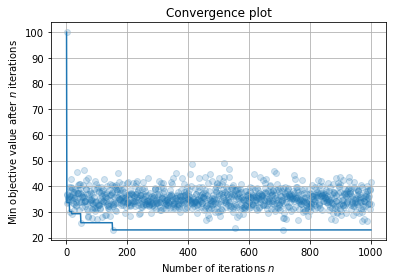

In [7]:
history.plot_convergence()

In [8]:
!pip install pyrfr>=0.5.0


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\shada\anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\shada\\AppData\\Local\\Temp\\pip-install-ufrmb_bk\\pyrfr_66e16e1565034cefa3617071887fef45\\setup.py'"'"'; __file__='"'"'C:\\Users\\shada\\AppData\\Local\\Temp\\pip-install-ufrmb_bk\\pyrfr_66e16e1565034cefa3617071887fef45\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\shada\AppData\Local\Temp\pip-wheel-7a_aw5hf'
       cwd: C:\Users\shada\AppData\Local\Temp\pip-install-ufrmb_bk\pyrfr_66e16e1565034cefa3617071887fef45\
  Complete output (7 lines):
  running bdist_wheel
  running build
  running build_ext
  building 'pyrfr._regression' extension
  swigging pyrfr/regression.i to pyrfr/regression_wrap.cpp
  swig.exe -python -c++ -modern -py3 -features nondynamic -I./include

In [9]:
print(history.get_importance())

[ERROR] [2021-11-05 20:05:09,652] [HistoryContainer] To use get_importance(), please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html


ModuleNotFoundError: No module named 'pyrfr'